# Pacotes & Funções

In [73]:
import warnings
import ppscore as pps
import itertools
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns
import shap
import sklearn
import statsmodels.api as sm
import xgboost as xgb
import yfinance as yf
import statsmodels.api as sm

from scipy.signal import periodogram
from scipy.stats import pearsonr, spearmanr
from scipy.stats import skew, kurtosis, shapiro
from prophet import Prophet
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.structural import UnobservedComponents
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.formula.api import ols
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools import add_constant

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
import mplfinance as mpf

from prophet import Prophet
from arch.unitroot import *
from datetime import timedelta
from hurst import compute_Hc
from hyperopt import fmin, hp, space_eval, STATUS_OK, Trials, tpe
from itertools import product
from math import sqrt
from pandas.plotting import lag_plot
from pmdarima import auto_arima
from scipy.signal import periodogram
from scipy.stats import jarque_bera, kurtosis, pearsonr, shapiro, skew, spearmanr
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from skopt import forest_minimize
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.structural import UnobservedComponents
from xgboost import plot_importance, plot_tree

from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from hyperopt import STATUS_OK
from statsmodels.tsa.stattools import acf,pacf

pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

In [2]:
def missing_values_table(df):
    """
    Cria uma tabela resumindo a quantidade e a porcentagem de valores ausentes em cada coluna do DataFrame.

    Args:
    df (pd.DataFrame): DataFrame para análise de valores ausentes.

    Etapas:
    1. Calcular a quantidade total de valores ausentes por coluna.
    2. Calcular a porcentagem de valores ausentes em relação ao total de linhas.
    3. Concatenar as duas métricas em um novo DataFrame.
    4. Renomear as colunas do DataFrame resultante para maior clareza.
    5. Filtrar e ordenar o DataFrame para mostrar apenas colunas com valores ausentes, em ordem decrescente de porcentagem.
    6. Imprimir um resumo sobre a presença de valores ausentes no DataFrame.

    Returns:
    pd.DataFrame: Uma tabela com o número e a porcentagem de valores ausentes por coluna.
    """
    # Calculando o número total de valores ausentes por coluna.
    mis_val = df.isnull().sum()
    
    # Calculando a porcentagem de valores ausentes.
    mis_val_percent = 100 * mis_val / len(df)
    
    # Criando um DataFrame com o número e a porcentagem de valores ausentes.
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    
    # Renomeando as colunas do DataFrame para clareza.
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    
    # Filtrando o DataFrame para mostrar apenas colunas com valores ausentes e ordenando-as.
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)
    
    # Imprimindo um resumo das colunas com valores ausentes.
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
            " columns that have missing values.")
    
    return mis_val_table_ren_columns

# Calculate RSI
def calculate_rsi(prices, period=14):
    delta = prices.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.ewm(com=period - 1, min_periods=period).mean()
    avg_loss = loss.ewm(com=period - 1, min_periods=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Criando a coluna 'halving_btc'
def categorize_date(date):
    for halving_date in halvings:
        pre_halving_start = halving_date - timedelta(days=180)
        pos_halving_end = halving_date + timedelta(days=180)
        if date == halving_date:
            return 'halving'
        elif pre_halving_start <= date < halving_date:
            return 'pre_halving'
        elif halving_date < date <= pos_halving_end:
            return 'pos_halving'
    return 'status_quo'


# Função para calcular as EMAs
def calculate_ema(data, periods=[15, 30, 200]):
    for period in periods:
        data[f'EMA_{period}'] = data['Close'].ewm(span=period, adjust=False).mean()
    return data

# Função para calcular o Commodity Channel Index (CCI)
def calculate_cci(data, period=20):
    TP = (data['High'] + data['Low'] + data['Close']) / 3
    MA = TP.rolling(window=period).mean()
    MD = TP.rolling(window=period).apply(lambda x: np.abs(x - x.mean()).mean())
    data['CCI'] = (TP - MA) / (0.015 * MD)
    return data

# Função para calcular o On-Balance Volume (OBV)
def calculate_obv(data):
    data['OBV'] = (np.where(data['Close'] > data['Close'].shift(1), data['Volume'],
                            np.where(data['Close'] < data['Close'].shift(1), -data['Volume'], 0))).cumsum()
    return data

## Dummies
def get_one_hot_enc(feature_col: pd.Series, enc: preprocessing.OneHotEncoder, column_name: str) -> pd.DataFrame:
    """
    Aplica codificação one-hot a uma coluna específica de um DataFrame.

    Args:
    feature_col (pd.Series): Coluna do DataFrame para ser codificada.
    enc (preprocessing.OneHotEncoder): Instância do OneHotEncoder treinada.
    column_name (str): Nome da coluna a ser codificada.

    Processo:
    1. Cria um DataFrame com a coluna especificada.
    2. Aplica a transformação one-hot usando o encoder fornecido.
    3. Retorna um DataFrame com as colunas codificadas.

    Returns:
    pd.DataFrame: DataFrame com as colunas resultantes da codificação one-hot.
    """
    unseen_df = pd.DataFrame(feature_col, columns=[column_name])
    encoded_vec = enc.transform(unseen_df).toarray()
    columns = enc.get_feature_names_out([column_name])
    encoded_df = pd.DataFrame(encoded_vec, columns=columns)
    return encoded_df

# Função para salvar um modelo em um arquivo pickle
def save_pickle(model, file_name: str):
    """
    Salva um objeto modelo em um arquivo pickle.

    Args:
    model (any): O modelo a ser salvo.
    file_name (str): Nome do arquivo pickle a ser criado.

    Processo:
    1. Abre o arquivo pickle em modo de escrita binária.
    2. Salva o objeto modelo no arquivo pickle.
    """
    with open(file_name, 'wb') as file:
        pickle.dump(model, file)

# Função para carregar um modelo de um arquivo pickle
def load_pickle(file_name: str) -> any:
    """
    Carrega um objeto a partir de um arquivo pickle.

    Args:
    file_name (str): Nome do arquivo pickle a ser carregado.

    Processo:
    1. Abre o arquivo pickle em modo de leitura binária.
    2. Carrega e retorna o objeto contido no arquivo pickle.

    Returns:
    any: Objeto carregado do arquivo pickle.
    """
    with open(file_name, 'rb') as file:
        return pickle.load(file)

def hipertuning(space):
    """
    Realiza o ajuste de hiperparâmetros de um modelo XGBoost usando validação cruzada para regressão.

    Args:
    space (dict): Dicionário contendo os hiperparâmetros para teste no modelo XGBoost.

    Processo:
    1. Configura o modelo XGBoost com os hiperparâmetros do espaço fornecido.
    2. Usa KFold para divisão do conjunto de dados.
    3. Calcula a média do MSE (Mean Squared Error) usando cross_val_score.
    
    Returns:
    dict: Dicionário contendo o 'loss' (negativo da média do MSE para minimização) e o 'status'.
    """
    # Configuração do modelo com os parâmetros do espaço
    model = xgb.XGBRegressor(
        max_depth=int(space['max_depth']),
        gamma=space['gamma'],
        reg_alpha=int(space['reg_alpha']),
        reg_lambda=space['reg_lambda'],
        min_child_weight=int(space['min_child_weight']),
        colsample_bytree=space['colsample_bytree'],
        random_state=int(space['seed'])
    )

    # KFold para divisão do conjunto de dados
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Avaliação usando cross_val_score
    mse_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
    mean_mse = -mse_scores.mean()
    print("Média MSE: ", mean_mse)

    # A função de perda é o negativo da média do MSE, pois estamos minimizando
    return {'loss': mean_mse, 'status': STATUS_OK}

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha': hp.uniform('reg_alpha', 0, 10),
        'reg_lambda': hp.uniform('reg_lambda', 0, 10),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'seed': 0}


# Extração de dados

In [3]:
# Extraindo dataset
BTC_Ticker = yf.Ticker("BTC-USD")
BTC_Data = BTC_Ticker.history(period="max")
# Salvando dataset extraido
BTC_Data.to_csv('bitcoin.csv')

# Informações básicas do dataset

In [4]:
BTC_Data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3502 entries, 2014-09-17 00:00:00+00:00 to 2024-04-18 00:00:00+00:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          3502 non-null   float64
 1   High          3502 non-null   float64
 2   Low           3502 non-null   float64
 3   Close         3502 non-null   float64
 4   Volume        3502 non-null   int64  
 5   Dividends     3502 non-null   float64
 6   Stock Splits  3502 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 218.9 KB


# Tratamento e calculo de metricas

In [5]:
# Extraindo características temporais: mês, dia da semana, semana do ano e quarter do ano
BTC_Data['Month'] = BTC_Data.index.month
BTC_Data['Weekday'] = BTC_Data.index.weekday
BTC_Data['WeekOfYear'] =BTC_Data.index.isocalendar().week
BTC_Data['Quarter'] = BTC_Data.index.quarter
BTC_Data['MonthName'] = BTC_Data.index.month_name()
BTC_Data['WeekdayName'] = BTC_Data.index.day_name()

# Calculando a volatilidade diária
BTC_Data['Volatility'] = BTC_Data['High'] - BTC_Data['Low']

# Calculando a variação percentual diária dos preços
BTC_Data['PriceChangePercent'] = BTC_Data['Close'].pct_change() * 100

# Calculando a volatilidade com diferentes janelas de tempo
BTC_Data['Volatility_30'] = BTC_Data['PriceChangePercent'].rolling(window=30).std()
BTC_Data['Volatility_90'] = BTC_Data['PriceChangePercent'].rolling(window=90).std()

# Exemplo para Pearson em um lag específico (e.g., lag=1)
BTC_Data['Lag_1'] = BTC_Data['Close'].shift(1)
BTC_Data['Lag_7'] = BTC_Data['Close'].shift(7)
BTC_Data['Lag_30'] = BTC_Data['Close'].shift(30)
BTC_Data['Lag_60'] = BTC_Data['Close'].shift(60)
BTC_Data['Lag_90'] = BTC_Data['Close'].shift(90)
BTC_Data['Lag_365'] = BTC_Data['Close'].shift(365)

# Drop colunas não utilizadas
BTC_Data = BTC_Data.drop(columns =['Dividends','Stock Splits'])

# Criação de Lag_1 para Open,High, Low, Volume
BTC_Data['Lag_1_Open'] = BTC_Data['Open'].shift(1)
BTC_Data['Lag_1_High'] = BTC_Data['High'].shift(1)
BTC_Data['Lag_1_Low'] = BTC_Data['Low'].shift(1)
BTC_Data['Lag_1_Volume'] = BTC_Data['Volume'].shift(1)
BTC_Data['Lag_1_Volatility'] = BTC_Data['Volatility'].shift(1)

# Aplicando a primeira diferenciação 
# Abaixo foi realizado o teste para verificar se era uma série estocástica, a serie foi reprovada no teste por isso do calculo da diferenciação
BTC_Data['Close_diff'] = BTC_Data['Close'].diff()

# Calcular as médias móveis de 50 e 200 dias
BTC_Data['MA50'] = BTC_Data['Close'].rolling(window=50).mean()
BTC_Data['MA200'] = BTC_Data['Close'].rolling(window=200).mean()

# Aplicando a transformação logarítmica na série de preço de fechamento
BTC_Data['Close_log_1'] = np.log(BTC_Data['Close'])
BTC_Data['Close_log_2'] = np.log(BTC_Data['Close_log_1'])

#
BTC_Data = BTC_Data.reset_index()

# Convertendo a coluna 'Date' para datetime e removendo informações de fuso horário
BTC_Data['Date'] = pd.to_datetime(BTC_Data['Date']).dt.tz_localize(None)

# Supondo que bitcoin_trat_df é o seu DataFrame e 'Date' já está convertida para datetime
BTC_Data['Year'] = BTC_Data['Date'].dt.year
BTC_Data['DayOfYear'] = BTC_Data['Date'].dt.dayofyear

# Definindo as datas de halving
halvings = {
    '2012-11-28': 'Primeiro Halving',
    '2016-07-09': 'Segundo Halving',
    '2020-05-11': 'Terceiro Halving'
}

# Convertendo strings para datetime
halvings = {pd.to_datetime(date): event for date, event in halvings.items()}

BTC_Data['halving_btc'] = BTC_Data['Date'].apply(categorize_date)

# Aplicando a função para calcular o RSI no preço de fechamento
# RSI do inglês Relative Strength Index
BTC_Data['RSI'] = calculate_rsi(BTC_Data['Close'])

BTC_Data = calculate_ema(BTC_Data, periods=[15, 30, 200])
BTC_Data = calculate_cci(BTC_Data, period=20)
BTC_Data = calculate_obv(BTC_Data)

## Salvando os dados tratados

In [7]:
BTC_Data.to_csv('bitcoin_trat.csv', index=False)

# Análise exploratória

## Carregando dataset tratado

- Date: Data da observação. <br>
- Open, High, Low, Close: Preço de abertura, máxima, mínima e de fechamento do Bitcoin na data especificada. <br>
- Volume: Volume de negociações na data. <br>
- Dividends, Stock Splits: Colunas com valores constantes, não parecem relevantes. <br>
- Month, Weekday, WeekOfYear, Quarter, MonthName, WeekdayName: Informações de data detalhadas. <br>
- Volatility: Volatilidade do preço na data. <br>
- PriceChangePercent, Volatility_30, Volatility_90: Percentual de mudança de preço e volatilidade calculada em diferentes períodos. <br>
- Close_log: Logaritmo do preço de fechamento. <br>
- Lag_1, Lag_7, Lag_30, Lag_60, Lag_90, Lag_365: Preço de fechamento defasado em 1, 7, 30, 60, 90 e 365 dias. <br>
- Close_diff: Diferença do preço de fechamento em relação ao dia anterior. <br>
- MA50, MA200: Médias móveis de 50 e 200 dias. <br>
- Lag_1_Open, Lag_1_High, Lag_1_Low, Lag_1_Volume: Representam os valores de abertura, máxima, mínima e volume do dia anterior. <br>
- Close_diff: Refere-se à diferença entre o preço de fechamento do dia atual e o do dia anterior. Este é um indicador direto de como o preço mudou de um dia para o outro.<br>
- MA50, MA200: Médias móveis calculadas sobre 50 e 200 dias, respectivamente. Estas são importantes para analisar tendências de médio e longo prazo no preço do Bitcoin, ajudando a suavizar flutuações de curto prazo para uma melhor percepção da direção do mercado.<br>
- Close_log_1, Close_log_2: São variantes do logaritmo do preço de fechamento. O logaritmo do preço é frequentemente utilizado para normalizar a distribuição de dados com grande amplitude e para simplificar a modelagem de crescimentos exponenciais.<br>
- Year, DayOfYear: Indicam o ano e o número do dia no ano da observação, respectivamente.<br>
- halving_btc: Indica se a data observada ocorre em um ano de halving do Bitcoin, que é um evento que reduz pela metade a recompensa por bloco minerado, ocorrendo aproximadamente a cada quatro anos. Isso é significativo, pois os halvings tendem a ter um impacto significativo sobre o preço e a economia do Bitcoin devido à redução da oferta.<br>

In [8]:
# Carregando dataset tratado
bitcoin_trat_df = pd.read_csv('bitcoin_trat.csv')

# Tratamento da coluna data
bitcoin_trat_df['Date'] = pd.to_datetime(bitcoin_trat_df['Date'])

# Setando data como index
bitcoin_trat_df.set_index('Date', inplace=True)

# Configurando o estilo do gráfico
dic = {
    'font.sans-serif': ['Arial'],  # Fonte
    'font.family': ['Arial']}
sns.set_style(rc=dic)
plt.style.use('ggplot')
# Plotando a tendência dos preços de Abertura e Fechamento ao longo do tempo
#plt.figure(figsize=(14, 7))

## Describe dos dados

In [9]:
bitcoin_trat_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3502 entries, 2014-09-17 to 2024-04-18
Data columns (total 40 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Open                3502 non-null   float64
 1   High                3502 non-null   float64
 2   Low                 3502 non-null   float64
 3   Close               3502 non-null   float64
 4   Volume              3502 non-null   int64  
 5   Month               3502 non-null   int64  
 6   Weekday             3502 non-null   int64  
 7   WeekOfYear          3502 non-null   int64  
 8   Quarter             3502 non-null   int64  
 9   MonthName           3502 non-null   object 
 10  WeekdayName         3502 non-null   object 
 11  Volatility          3502 non-null   float64
 12  PriceChangePercent  3501 non-null   float64
 13  Volatility_30       3472 non-null   float64
 14  Volatility_90       3412 non-null   float64
 15  Lag_1               3501 non-null   f

In [10]:
bitcoin_trat_df.describe()

Open          High           Low         Close        Volume  \
count   3502.000000   3502.000000   3502.000000   3502.000000  3.502000e+03   
mean   15849.036234  16220.306898  15452.488725  15865.739463  1.711501e+10   
std    17569.933379  17993.376083  17102.446859  17583.857630  1.928799e+10   
min      176.897003    211.731003    171.509995    178.102997  5.914570e+06   
25%     1006.570023   1035.519989    982.927765   1008.559982  2.083145e+08   
50%     8664.668945   8836.516113   8394.783691   8664.410156  1.275175e+10   
75%    26746.813965  27119.638672  26342.790527  26756.169434  2.762574e+10   
max    73079.375000  73750.070312  71334.093750  73083.500000  3.509679e+11   

             Month      Weekday   WeekOfYear      Quarter    Volatility  \
count  3502.000000  3502.000000  3502.000000  3502.000000   3502.000000   
mean      6.520274     2.999714    26.587379     2.507995    767.818173   
std       3.509568     1.999786    15.338630     1.136408   1181.885080   
min       1.000000     0.000000     1.000000     1.000000      1.028000   
25%       3.000000     1.000000    13.000000     1.000000     38.431923   
50%       7.000000     3.000000    27.000000     3.000000    297.920105   
75%      10.000000     5.000000    40.000000     4.000000    964.838379   
max      12.000000     6.000000    53.000000     4.000000  12864.621094   

       PriceChangePercent  Volatility_30  Volatility_90         Lag_1  \
count         3501.000000    3472.000000    3412.000000   3501.000000   
mean             0.209362       3.347703       3.482283  15852.174613   
std              3.683360       1.508335       1.177902  17568.034026   
min            -37.169539       0.709489       1.219138    178.102997   
25%             -1.247791       2.293442       2.698077   1007.479980   
50%              0.139729       3.129781       3.308009   8660.700195   
75%              1.721406       4.165370       4.079334  26754.281250   
max             25.247169       9.133050       7.473960  73083.500000   

              Lag_7        Lag_30        Lag_60        Lag_90       Lag_365  \
count   3495.000000   3472.000000   3442.000000   3412.000000   3137.000000   
mean   15769.153787  15419.510257  15008.921416  14746.046809  13247.946448   
std    17468.170214  16986.615384  16464.591638  16290.716046  16045.802560   
min      178.102997    178.102997    178.102997    178.102997    178.102997   
25%     1004.500000    988.935760    964.488480    921.445526    729.793030   
50%     8657.642578   8569.259277   8383.864258   8273.409668   7400.899414   
75%    26594.130859  26305.726074  25888.958008  24339.722168  19154.230469   
max    73083.500000  73083.500000  67566.828125  67566.828125  67566.828125   

         Lag_1_Open    Lag_1_High     Lag_1_Low  Lag_1_Volume  \
count   3501.000000   3501.000000   3501.000000  3.501000e+03   
mean   15836.059135  16206.625038  15439.502245  1.710934e+10   
std    17555.649704  17977.718096  17087.611940  1.928784e+10   
min      176.897003    211.731003    171.509995  5.914570e+06   
25%     1006.210022   1033.869995    982.830017  2.079820e+08   
50%     8661.760742   8836.190430   8394.459961  1.275080e+10   
75%    26737.578125  27092.697266  26339.314453  2.759567e+10   
max    73079.375000  73750.070312  71334.093750  3.509679e+11   

       Lag_1_Volatility   Close_diff          MA50         MA200  Close_log_1  \
count       3501.000000  3501.000000   3453.000000   3303.000000  3502.000000   
mean         767.122793    17.965995  15609.856167  15178.624275     8.648172   
std         1181.337189   839.331795  16924.122017  15572.556247     1.777223   
min            1.028000 -7554.039062    232.261620    245.701329     5.182362   
25%           38.399902   -89.900146   1100.633877   1484.094854     6.916277   
50%          297.869995     1.600006   8575.062822   8708.217803     9.066979   
75%          963.708984   120.791016  26913.761992  26917.319858    10.194520   
max        12864.621094

## Gráficos

Os dados missing já eram esperaados. Os tratamentos realizados faz com que as colunas criadas tenham perda de dados, por exmeplo, Lag de 365 dias (essa coluna possui 365 linhas com dados missing), média móvel de 50 dias ou 200 dias que possuem 49 e 199 registros de dados missing respectivamente. 

### Dados Missing

In [11]:
# Chamando a função 'missing_values_table' para obter um resumo dos valores ausentes no DataFrame.
# Esta função fornece o número e a porcentagem de valores ausentes por coluna.
missing_values_table(bitcoin_trat_df)

Your selected dataframe has 40 columns.
There are 19 columns that have missing values.


Missing Values  % of Total Values
Lag_365                        365               10.4
MA200                          199                5.7
Volatility_90                   90                2.6
Lag_90                          90                2.6
Lag_60                          60                1.7
MA50                            49                1.4
Lag_30                          30                0.9
Volatility_30                   30                0.9
CCI                             19                0.5
RSI                             13                0.4
Lag_7                            7                0.2
Lag_1_Volatility                 1                0.0
Close_diff                       1                0.0
PriceChangePercent               1                0.0
Lag_1_Volume                     1                0.0
Lag_1_Low                        1                0.0
Lag_1_High                       1                0.0
Lag_1                            1                0.0
Lag_1_Open                       1                0.0

<Axes: >

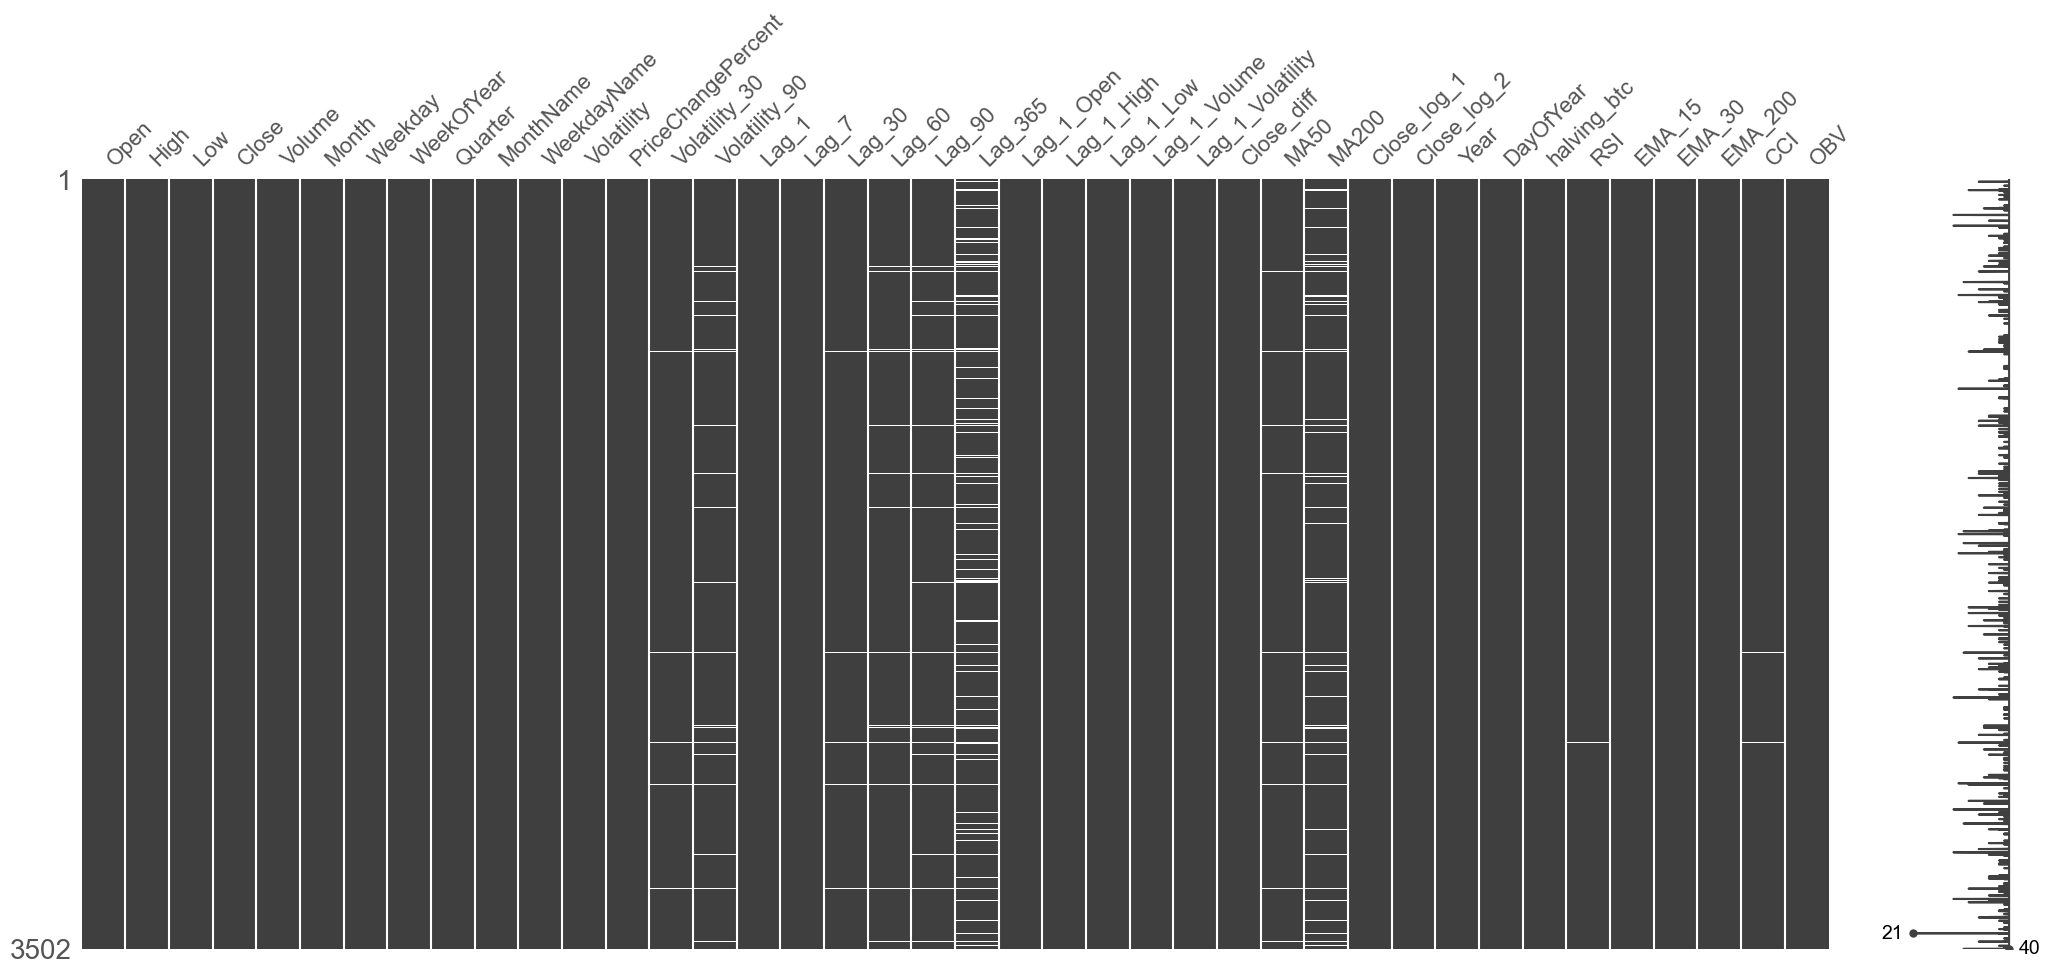

In [12]:
# Visualizando os valores ausentes no DataFrame com a biblioteca 'missingno'.
# O gráfico de matriz mostra a presença ou ausência de dados (valores não nulos) em cada coluna.
msno.matrix(bitcoin_trat_df.sample([bitcoin_trat_df.shape][0][0]))

### Comportamento Temporal

#### Fechamento do preço do BTC normal/transformado em log/diferenciação

Os gráficos abaixo permitem visualizar o comportamento da nossa variável preditiva ao longo do tempo. Temos visualizações no formato em que os dados foram extraídos, após transformação de log para suavizar as curvas acentuadas e por fim o fechamento após o tratamento de diferenciação.

Esses gráficos nos permitem compreender principalmente a evolução do bitcoin como ativo ao longo dos anos. 

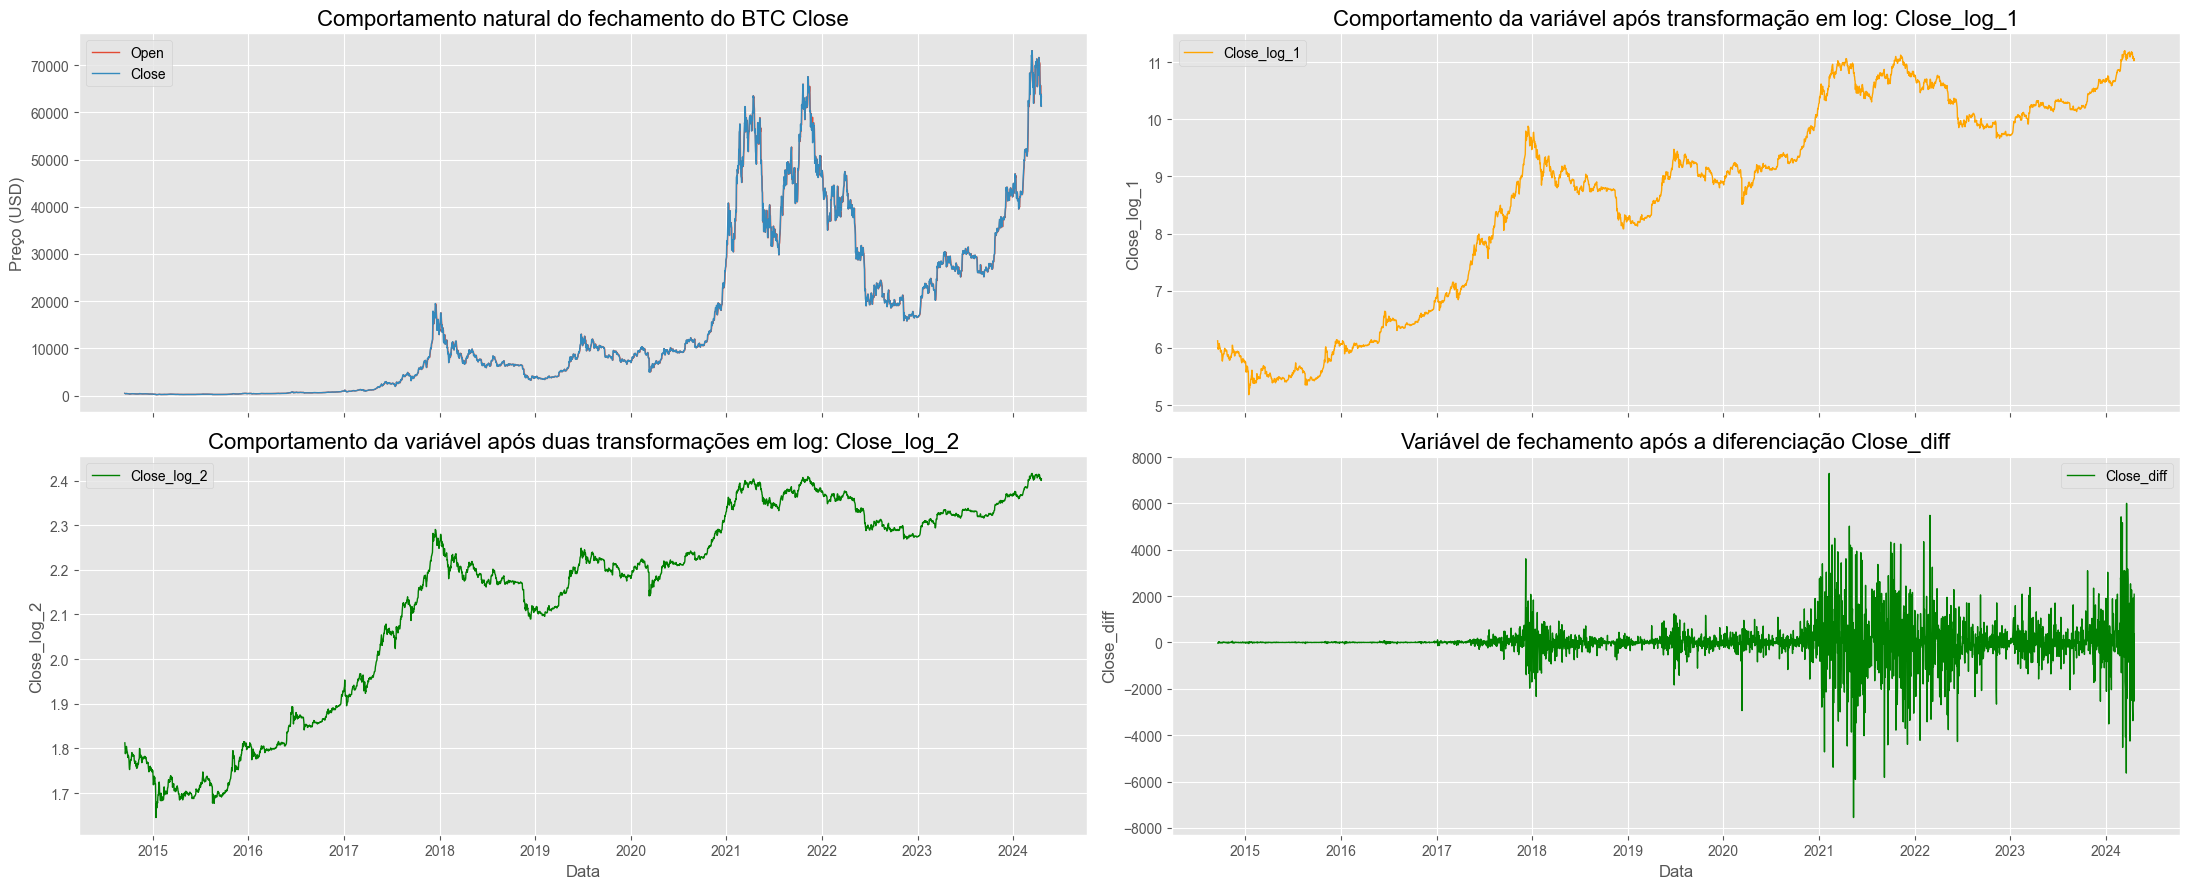

In [13]:
# Configurando um ambiente de plotagem com subgráficos.
fig, axes = plt.subplots(2, 2, figsize=(22, 9), sharex=True)

# Plotando a tendência dos preços de Abertura e Fechamento ao longo do tempo no primeiro subgráfico
sns.lineplot(data=bitcoin_trat_df, x=bitcoin_trat_df.index, y='Open', label='Open', linewidth=1, ax=axes[0, 0])
sns.lineplot(data=bitcoin_trat_df, x=bitcoin_trat_df.index, y='Close', label='Close', linewidth=1, ax=axes[0, 0])
axes[0, 0].set_title('Comportamento natural do fechamento do BTC Close', fontsize=16)
axes[0, 0].set_xlabel('Data')
axes[0, 0].set_ylabel('Preço (USD)')

# Plotando a volatilidade ao longo do tempo no segundo subgráfico
# Aqui, você precisa calcular a 'Volatility' se ainda não estiver no seu DataFrame.
sns.lineplot(data=bitcoin_trat_df, x=bitcoin_trat_df.index, y='Close_log_1', label='Close_log_1', linewidth=1, color='orange',ax=axes[0, 1])
axes[0, 1].set_title('Comportamento da variável após transformação em log: Close_log_1', fontsize=16)
axes[0, 1].set_xlabel('Data')

# Plotando o volume de negociação ao longo do tempo no terceiro subgráfico
sns.lineplot(data=bitcoin_trat_df, x=bitcoin_trat_df.index, y='Close_log_2', label='Close_log_2', color='green', linewidth=1, ax=axes[1, 0])
axes[1, 0].set_title('Comportamento da variável após duas transformações em log: Close_log_2', fontsize=16)
axes[1, 0].set_xlabel('Data')


# Plotando o volume de negociação ao longo do tempo no terceiro subgráfico
sns.lineplot(data=bitcoin_trat_df, x=bitcoin_trat_df.index, y='Close_diff', label='Close_diff', color='green', linewidth=1, ax=axes[1, 1])
axes[1, 1].set_title('Variável de fechamento após a diferenciação Close_diff', fontsize=16)
axes[1, 1].set_xlabel('Data')


plt.tight_layout()
plt.show()

#### Comportamento anual do preço

Abaixo podemos visualizar o comportamento anual do fechamento do bitcoin. Podemos visualizar o comportamento sazonal tendo em via o dia do ano. 

Temos alguns anos onde vemos o ativo cresce o seu valor nós últimos meses do ano e alguns casos onde a volatilidade foi alta dentro proprio ano igual em 2021. Outra evidência que temos com os gráficos é a ocorrência de ciclos de altas. Por fim, outra informação que já podemos ter em mente é o fato do bitcoin ser um ativo volátil

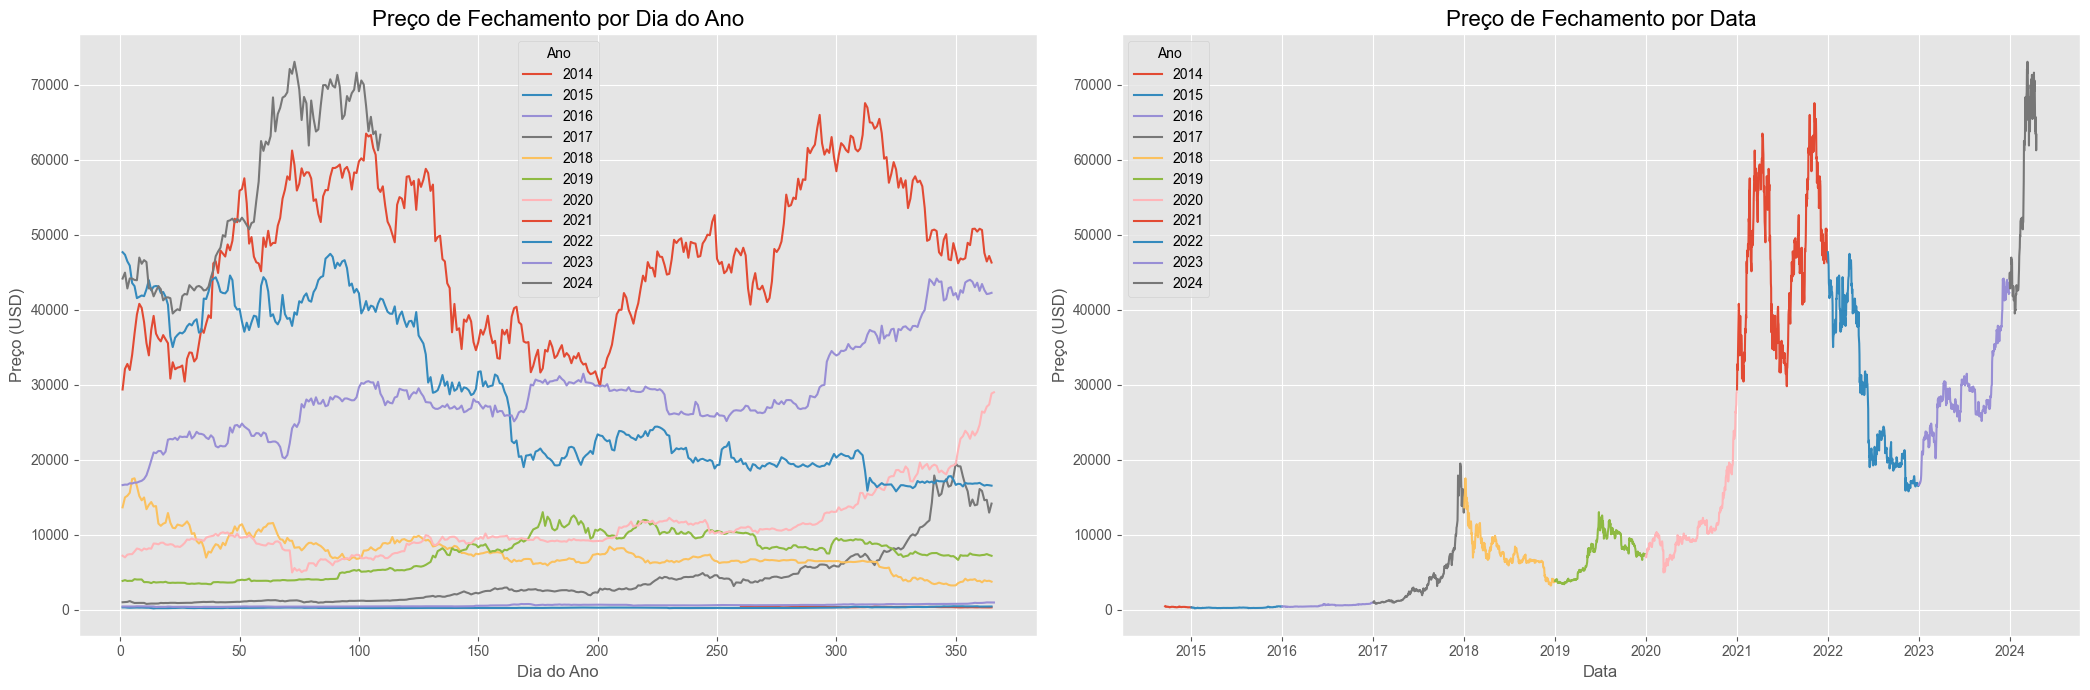

In [14]:
# Configurando um ambiente de plotagem com subgráficos lado a lado.
fig, axes = plt.subplots(1, 2, figsize=(21, 7))  # Dois gráficos lado a lado

bitcoin_trat_df = bitcoin_trat_df.reset_index()

# Obtenha a lista de anos únicos
years = bitcoin_trat_df['Year'].unique()

# Loop através de cada ano e plote os dados para o preço de fechamento por dia do ano
for year in years:
    # Filtre os dados para o ano específico
    data_for_year = bitcoin_trat_df[bitcoin_trat_df['Year'] == year]
    axes[0].plot(data_for_year['DayOfYear'], data_for_year['Close'], label=str(year))

axes[0].set_title('Preço de Fechamento por Dia do Ano', fontsize=16)
axes[0].set_xlabel('Dia do Ano')
axes[0].set_ylabel('Preço (USD)')
axes[0].legend(title='Ano')

# Loop através de cada ano e plote os dados para o preço de fechamento por data real
for year in years:
    data_for_year = bitcoin_trat_df[bitcoin_trat_df['Year'] == year]
    axes[1].plot(data_for_year['Date'], data_for_year['Close'], label=str(year))

axes[1].set_title('Preço de Fechamento por Data', fontsize=16)
axes[1].set_xlabel('Data')
axes[1].set_ylabel('Preço (USD)')
axes[1].legend(title='Ano')

plt.tight_layout()  # Ajustar o layout
plt.show()


### Gráficos de volume, volatilidade, abertura e fechamento

Olhando os gráficos abaixo podemos confirmar que o biticoin é um ativo muito volatil, basta olhar para a volatilidade diária do preço. É possivel visualizar períodos onde o volume diário é alto e coincide com os ciclos de alta, uma consequência comum ao preço é que o volume acaba se tornando uma variável volátil. Altos volumes acompanhados por grandes mudanças percentuais de preço podem sinalizar pontos de entrada ou saída para traders. Eles também podem indicar eventos de mercado importantes

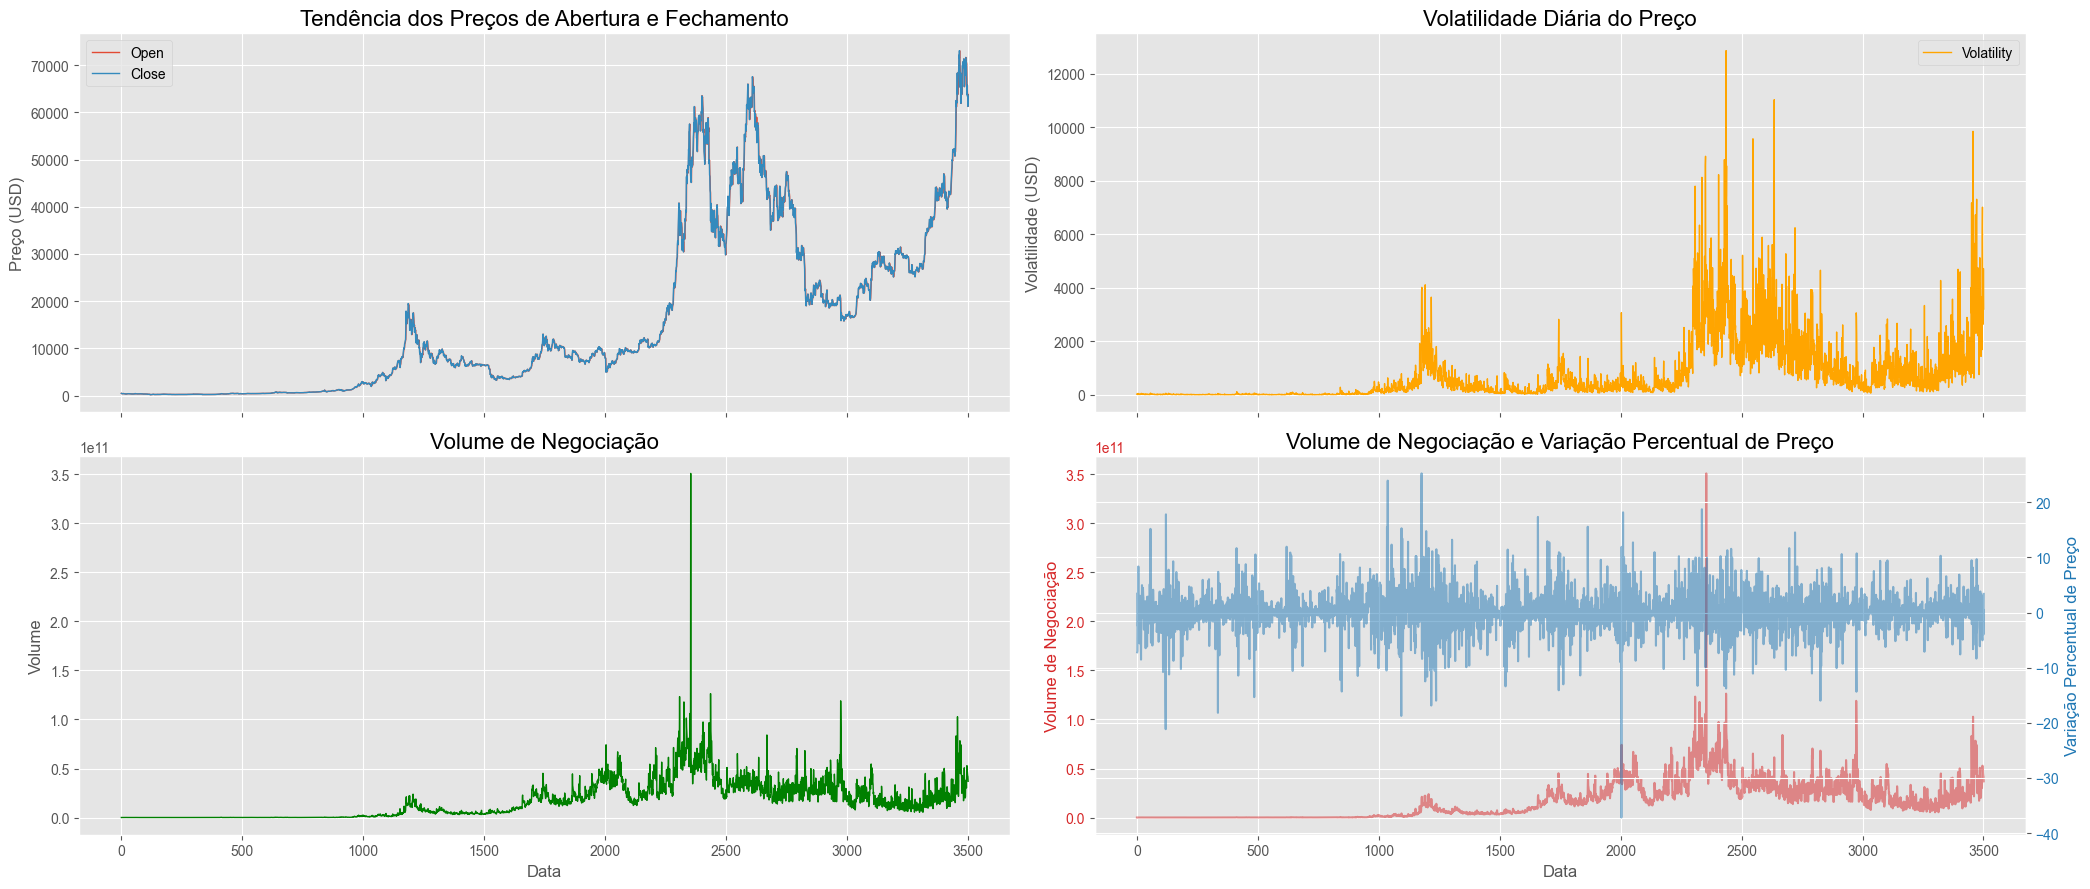

In [15]:
# Configurando um ambiente de plotagem com subgráficos.
fig, axes = plt.subplots(2, 2, figsize=(21, 9), sharex=True)

# Plotando a tendência dos preços de Abertura e Fechamento ao longo do tempo no primeiro subgráfico
sns.lineplot(data=bitcoin_trat_df, x=bitcoin_trat_df.index, y='Open', label='Open', linewidth=1, ax=axes[0, 0])
sns.lineplot(data=bitcoin_trat_df, x=bitcoin_trat_df.index, y='Close', label='Close', linewidth=1, ax=axes[0, 0])
axes[0, 0].set_title('Tendência dos Preços de Abertura e Fechamento', fontsize=16)
axes[0, 0].set_xlabel('Data')
axes[0, 0].set_ylabel('Preço (USD)')

# Plotando a volatilidade ao longo do tempo no segundo subgráfico
# Aqui, você precisa calcular a 'Volatility' se ainda não estiver no seu DataFrame.
sns.lineplot(data=bitcoin_trat_df, x=bitcoin_trat_df.index, y='Volatility', label='Volatility', color='orange', linewidth=1, ax=axes[0, 1])
axes[0, 1].set_title('Volatilidade Diária do Preço', fontsize=16)
axes[0, 1].set_xlabel('Data')
axes[0, 1].set_ylabel('Volatilidade (USD)')

# Plotando o volume de negociação ao longo do tempo no terceiro subgráfico
sns.lineplot(data=bitcoin_trat_df, x=bitcoin_trat_df.index, y='Volume', color='green', linewidth=1, ax=axes[1, 0])
axes[1, 0].set_title('Volume de Negociação', fontsize=16)
axes[1, 0].set_xlabel('Data')
axes[1, 0].set_ylabel('Volume')

# Combinando Volume de Negociação e Variação Percentual de Preço no quarto subgráfico
# Aqui, você precisa calcular 'PriceChangePercent' se ainda não estiver no seu DataFrame.
color = 'tab:red'
axes[1, 1].set_xlabel('Data')
axes[1, 1].set_ylabel('Volume de Negociação', color=color)
axes[1, 1].plot(bitcoin_trat_df.index, bitcoin_trat_df['Volume'], color=color, alpha=0.5)
axes[1, 1].tick_params(axis='y', labelcolor=color)

ax2 = axes[1, 1].twinx()
color = 'tab:blue'
ax2.set_ylabel('Variação Percentual de Preço', color=color)
ax2.plot(bitcoin_trat_df.index, bitcoin_trat_df['PriceChangePercent'], color=color, alpha=0.5)
ax2.tick_params(axis='y', labelcolor=color)
axes[1, 1].set_title('Volume de Negociação e Variação Percentual de Preço', fontsize=16)

plt.tight_layout()
plt.show()

Atendência de um ativo é que a volatilidade diminua ao longo do tempo e que seu preço estabilize dentro de uma faixa. Ativos financeiros consolidados já possuem essas caracteristicas, só tendo grandes alterações em caso de um evento atipico. O heatmap baixo permite visualizar que os últimos dias (podemos entender meses e anos) foram menos voláteis do que 6 anos atrás por exmeplo. 

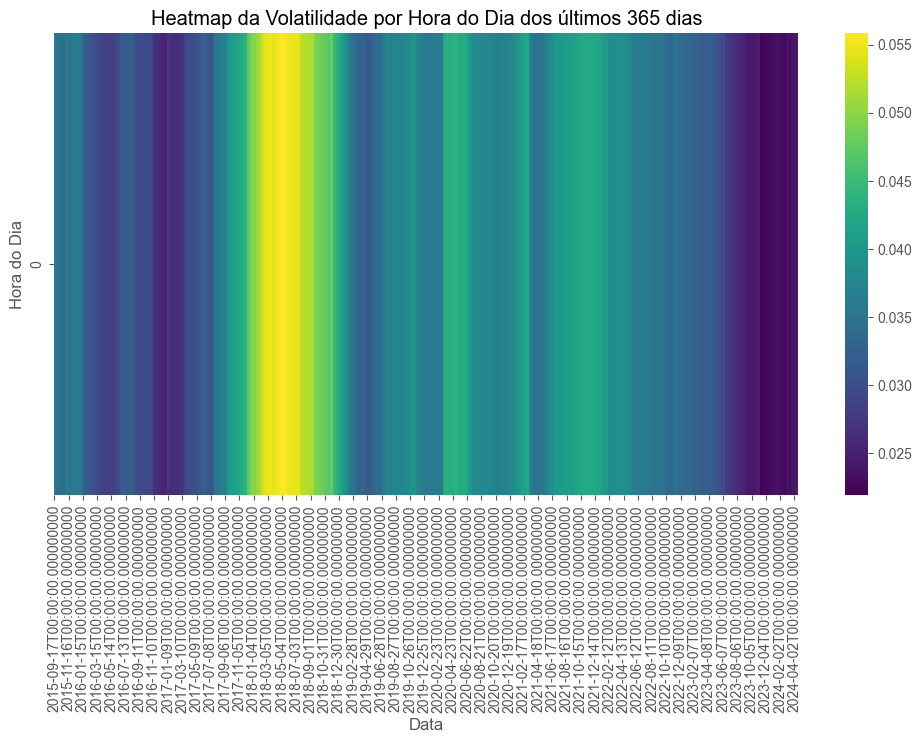

In [16]:
# Supondo que 'Hour' é uma coluna com as horas, se não, adaptar conforme os dados
bitcoin_trat_df['Hour'] = bitcoin_trat_df['Date'].dt.hour
bitcoin_trat_df['Volatility'] = bitcoin_trat_df['Close'].pct_change().rolling(window=365).std()

# Pivot table para o heatmap
volatility_pivot = bitcoin_trat_df.pivot_table(values='Volatility', index='Hour', columns='Date', aggfunc='mean')

plt.figure(figsize=(12, 6))
sns.heatmap(volatility_pivot, cmap='viridis')
plt.title('Heatmap da Volatilidade por Hora do Dia dos últimos 365 dias')
plt.xlabel('Data')
plt.ylabel('Hora do Dia')
plt.show()

### Média movel e outros

A volatilidade varia com o tempo e é evidente que há períodos de maior e menor volatilidade, que podem estar relacionados a eventos externos, por exemplo halving evento que acontece aproximadamente de 4 em 4 anos. O gráfico com médias móveis ajudam a identificar a tendência do mercado e pontos de virada potenciais quando o preço cruza essas médias.

O gráfico distribuição de retornos sugere que a maioria dos retornos diários está próxima de zero, mas com caudas pesadas indicando a ocorrência de variações de preços grandes, embora menos frequentes. E temos uma alta correlação entre o preço de abertura e de fechamento. 

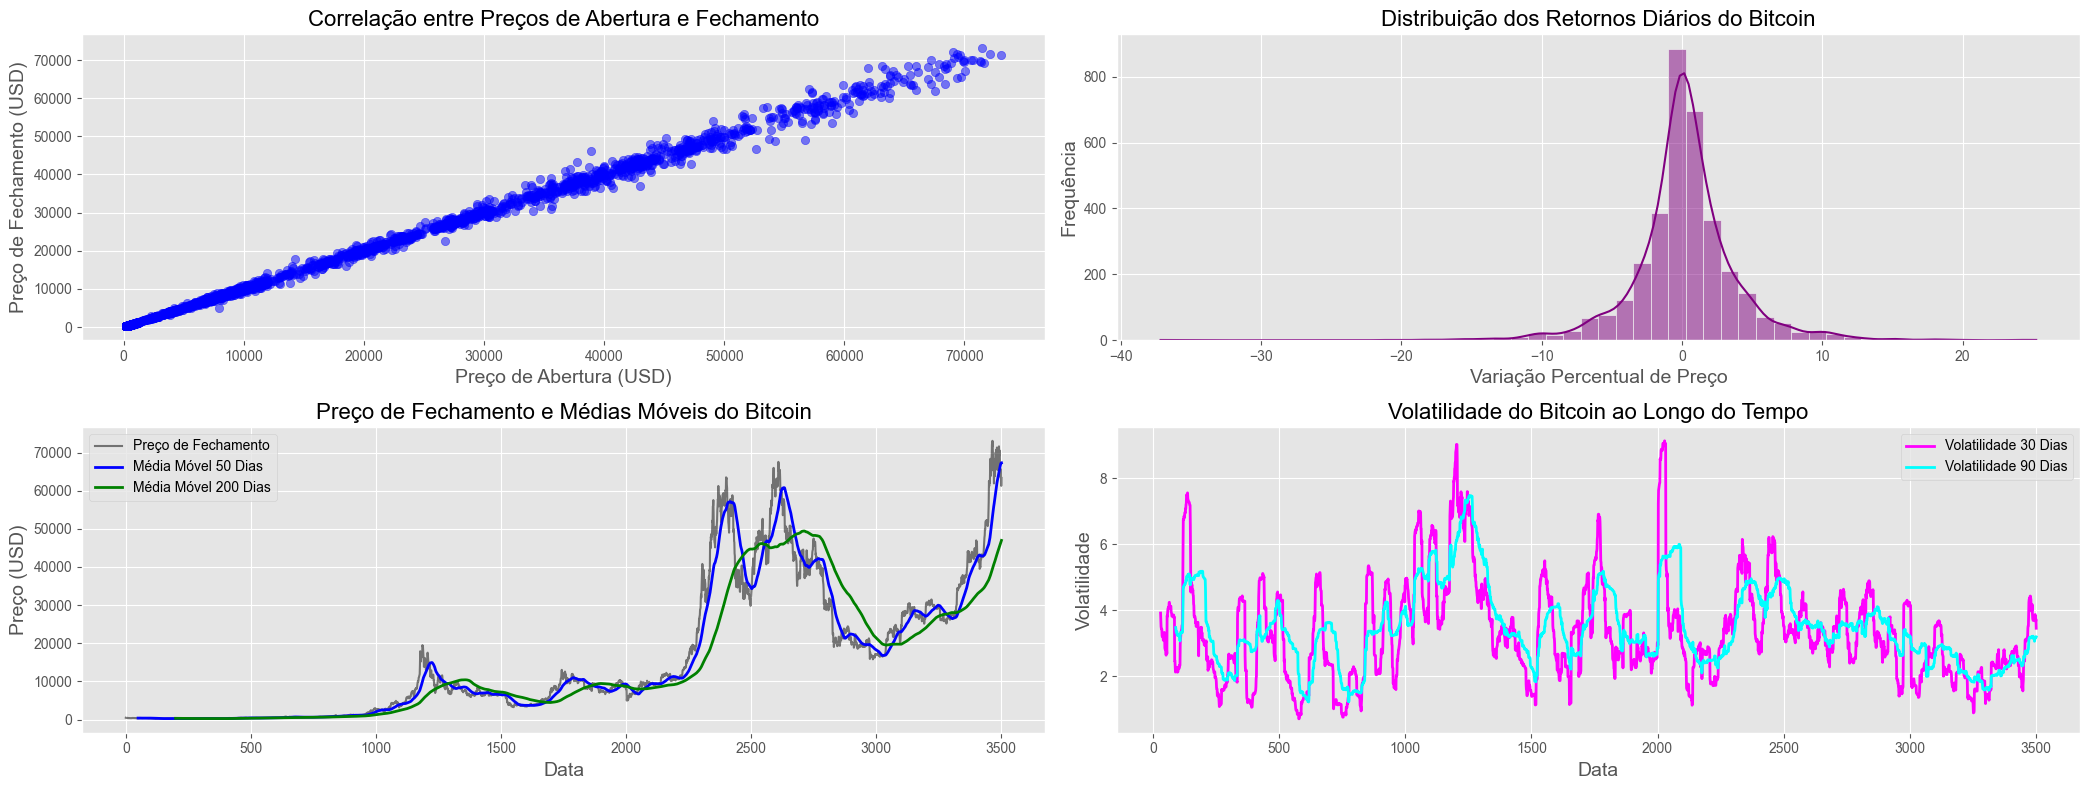

In [17]:
# Configurando um ambiente de plotagem com subgráficos.
fig, axes = plt.subplots(2, 2, figsize=(21, 8))

# Gráfico de dispersão para correlação entre preços de Abertura e Fechamento
sns.scatterplot(data=bitcoin_trat_df, x='Open', y='Close', alpha=0.5, edgecolor=None, color='blue', ax=axes[0, 0])
axes[0, 0].set_title('Correlação entre Preços de Abertura e Fechamento', fontsize=16)
axes[0, 0].set_xlabel('Preço de Abertura (USD)', fontsize=14)
axes[0, 0].set_ylabel('Preço de Fechamento (USD)', fontsize=14)

# Histograma dos retornos diários
sns.histplot(bitcoin_trat_df['PriceChangePercent'], bins=50, kde=True, color='purple', ax=axes[0, 1])
axes[0, 1].set_title('Distribuição dos Retornos Diários do Bitcoin', fontsize=16)
axes[0, 1].set_xlabel('Variação Percentual de Preço', fontsize=14)
axes[0, 1].set_ylabel('Frequência', fontsize=14)

# Preço de Fechamento e Médias Móveis
axes[1, 0].plot(bitcoin_trat_df.index, bitcoin_trat_df['Close'], label='Preço de Fechamento', alpha=0.5, color='black',)
axes[1, 0].plot(bitcoin_trat_df.index, bitcoin_trat_df['MA50'], label='Média Móvel 50 Dias', color='blue', linewidth=2)
axes[1, 0].plot(bitcoin_trat_df.index, bitcoin_trat_df['MA200'], label='Média Móvel 200 Dias', color='green', linewidth=2)
axes[1, 0].set_title('Preço de Fechamento e Médias Móveis do Bitcoin', fontsize=16)
axes[1, 0].set_xlabel('Data', fontsize=14)
axes[1, 0].set_ylabel('Preço (USD)', fontsize=14)
axes[1, 0].legend()

# Volatilidade do Bitcoin ao Longo do Tempo
axes[1, 1].plot(bitcoin_trat_df.index, bitcoin_trat_df['Volatility_30'], label='Volatilidade 30 Dias', color='magenta', linewidth=2)
axes[1, 1].plot(bitcoin_trat_df.index, bitcoin_trat_df['Volatility_90'], label='Volatilidade 90 Dias', color='cyan', linewidth=2)
axes[1, 1].set_title('Volatilidade do Bitcoin ao Longo do Tempo', fontsize=16)
axes[1, 1].set_xlabel('Data', fontsize=14)
axes[1, 1].set_ylabel('Volatilidade', fontsize=14)
axes[1, 1].legend()

plt.tight_layout()
plt.show()

### Tendência dos Preços de Abertura e Fechamento (Mensal, Trimestre, Semanal)

Nos gráficos dessa sessão temos gráficos que nos permitem desconfiar da existência de uma sazonalizadade anual. Temos uma clara variação na média de preços ao longo dos meses, porém vale destacar que os valores são uma média de todos os meses do nosso dataset. Quando olhamos para os dados agrupados por trimestre também vemos um comportamento indicando uma possivel sazonalidade.

Por outro lado não temos a mesma conclusão quando olhamos para o dia da semana não vemos nenhum indício de sazonalidade, sendo um comportamento homogêneo durante os dias do ano. 

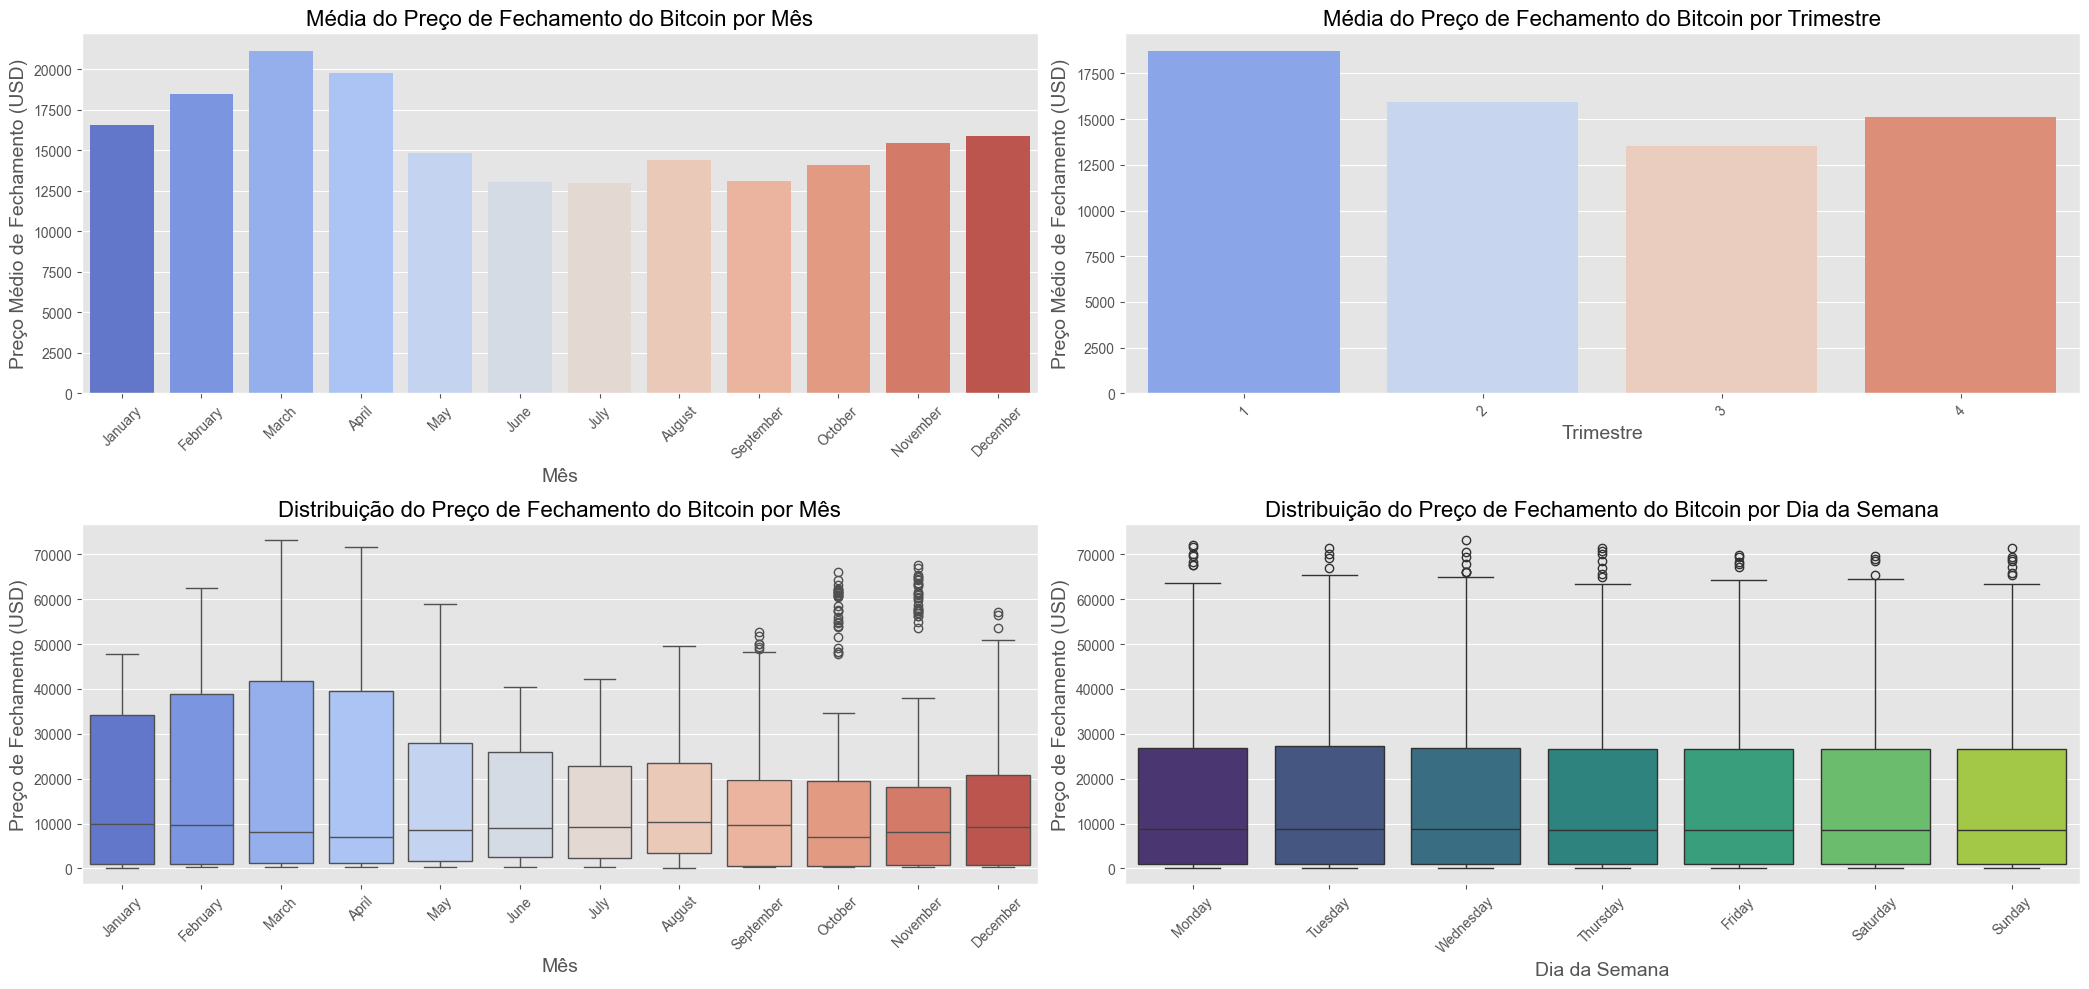

In [18]:
# Configurando um ambiente de plotagem com subgráficos.
fig, axes = plt.subplots(2, 2, figsize=(21, 10))

bitcoin_trat_df = bitcoin_trat_df.set_index('Date')
bitcoin_trat_df['Month'] = bitcoin_trat_df.index.month

# Definindo a ordem correta para os meses e dias da semana
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# Criando um mapeamento para os trimestres de forma que possamos mapeá-los a uma lista ordenada
quarter_mapping = {1: 'Q1', 2: 'Q2', 3: 'Q3', 4: 'Q4'}

# Convertendo para categorias ordenadas
bitcoin_trat_df['MonthName'] = pd.Categorical(bitcoin_trat_df['MonthName'], categories=month_order, ordered=True)
bitcoin_trat_df['WeekdayName'] = pd.Categorical(bitcoin_trat_df['WeekdayName'], categories=weekday_order, ordered=True)

# Calculando a média do preço de fechamento por mês e por trimestre
monthly_avg = bitcoin_trat_df.groupby('Month')['Close'].mean()
quarterly_avg = bitcoin_trat_df['Close'].resample('Q').mean()

# Agrupando os dados por trimestre e obtendo a média
quarterly_avg_grouped = bitcoin_trat_df.groupby('Quarter')['Close'].mean()

# Criando uma Series com o nome do mês como índice para garantir a ordem cronológica correta
# Usando a lista 'month_order' para garantir a ordem correta dos meses
monthly_avg_ordered = pd.Series(index=month_order, dtype=float)
for month in month_order:
    month_number = pd.to_datetime(month, format='%B').month
    monthly_avg_ordered[month] = monthly_avg.get(month_number, float('nan'))

sns.barplot(x=monthly_avg_ordered.index, y=monthly_avg.values, palette='coolwarm', ax=axes[0, 0])
axes[0, 0].set_title('Média do Preço de Fechamento do Bitcoin por Mês', fontsize=16)
axes[0, 0].set_xlabel('Mês', fontsize=14)
axes[0, 0].set_ylabel('Preço Médio de Fechamento (USD)', fontsize=14)
axes[0, 0].tick_params(axis='x', rotation=45)

# Plotando a média do preço de fechamento por trimestre
bitcoin_trat_df['Quarter'] = bitcoin_trat_df.index.quarter.map(quarter_mapping)
sns.barplot(x=quarterly_avg_grouped.index, y=quarterly_avg_grouped.values, palette='coolwarm', ax=axes[0, 1])
axes[0, 1].set_title('Média do Preço de Fechamento do Bitcoin por Trimestre', fontsize=16)
axes[0, 1].set_xlabel('Trimestre', fontsize=14)
axes[0, 1].set_ylabel('Preço Médio de Fechamento (USD)', fontsize=14)
axes[0, 1].tick_params(axis='x', rotation=45)

# Plotando o boxplot do preço de fechamento por mês
sns.boxplot(data=bitcoin_trat_df, x='MonthName', y='Close', palette='coolwarm', ax=axes[1, 0])
axes[1, 0].set_title('Distribuição do Preço de Fechamento do Bitcoin por Mês', fontsize=16)
axes[1, 0].set_xlabel('Mês', fontsize=14)
axes[1, 0].set_ylabel('Preço de Fechamento (USD)', fontsize=14)
axes[1, 0].tick_params(axis='x', rotation=45)

# Plotando o boxplot do preço de fechamento por dia da semana
sns.boxplot(data=bitcoin_trat_df, x='WeekdayName', y='Close', palette='viridis', ax=axes[1, 1])
axes[1, 1].set_title('Distribuição do Preço de Fechamento do Bitcoin por Dia da Semana', fontsize=16)
axes[1, 1].set_xlabel('Dia da Semana', fontsize=14)
axes[1, 1].set_ylabel('Preço de Fechamento (USD)', fontsize=14)
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Boxplot com a oscilação do preço anual

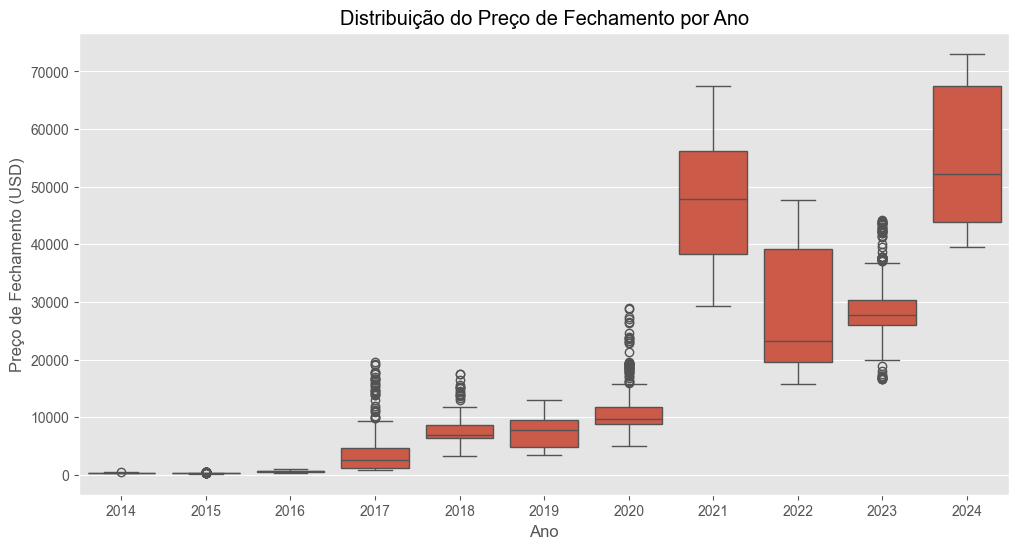

In [19]:
bitcoin_trat_df = bitcoin_trat_df.reset_index()
bitcoin_trat_df['Date'] = pd.to_datetime(bitcoin_trat_df['Date'])
bitcoin_trat_df['Year'] = bitcoin_trat_df['Date'].dt.year
bitcoin_trat_df['Month'] = bitcoin_trat_df['Date'].dt.month

plt.figure(figsize=(12, 6))
sns.boxplot(x='Year', y='Close', data=bitcoin_trat_df)
plt.title('Distribuição do Preço de Fechamento por Ano')
plt.xlabel('Ano')
plt.ylabel('Preço de Fechamento (USD)')
plt.show()

### Japanese Candlestick 

O gráfico de candlestick japonês, ou candlestick, é uma técnica de representação gráfica de dados financeiros usada para descrever movimentos de preços de um ativo. Cada "candle" mostra o preço de abertura, fechamento, máximo e mínimo dentro de um período específico. A cor e o tamanho do corpo do candle fornecem insights sobre a dinâmica do mercado: um corpo grande indica uma forte venda ou compra, enquanto um corpo pequeno sugere menor volatilidade. Candles de cores diferentes representam movimentos de preço ascendentes ou descendentes

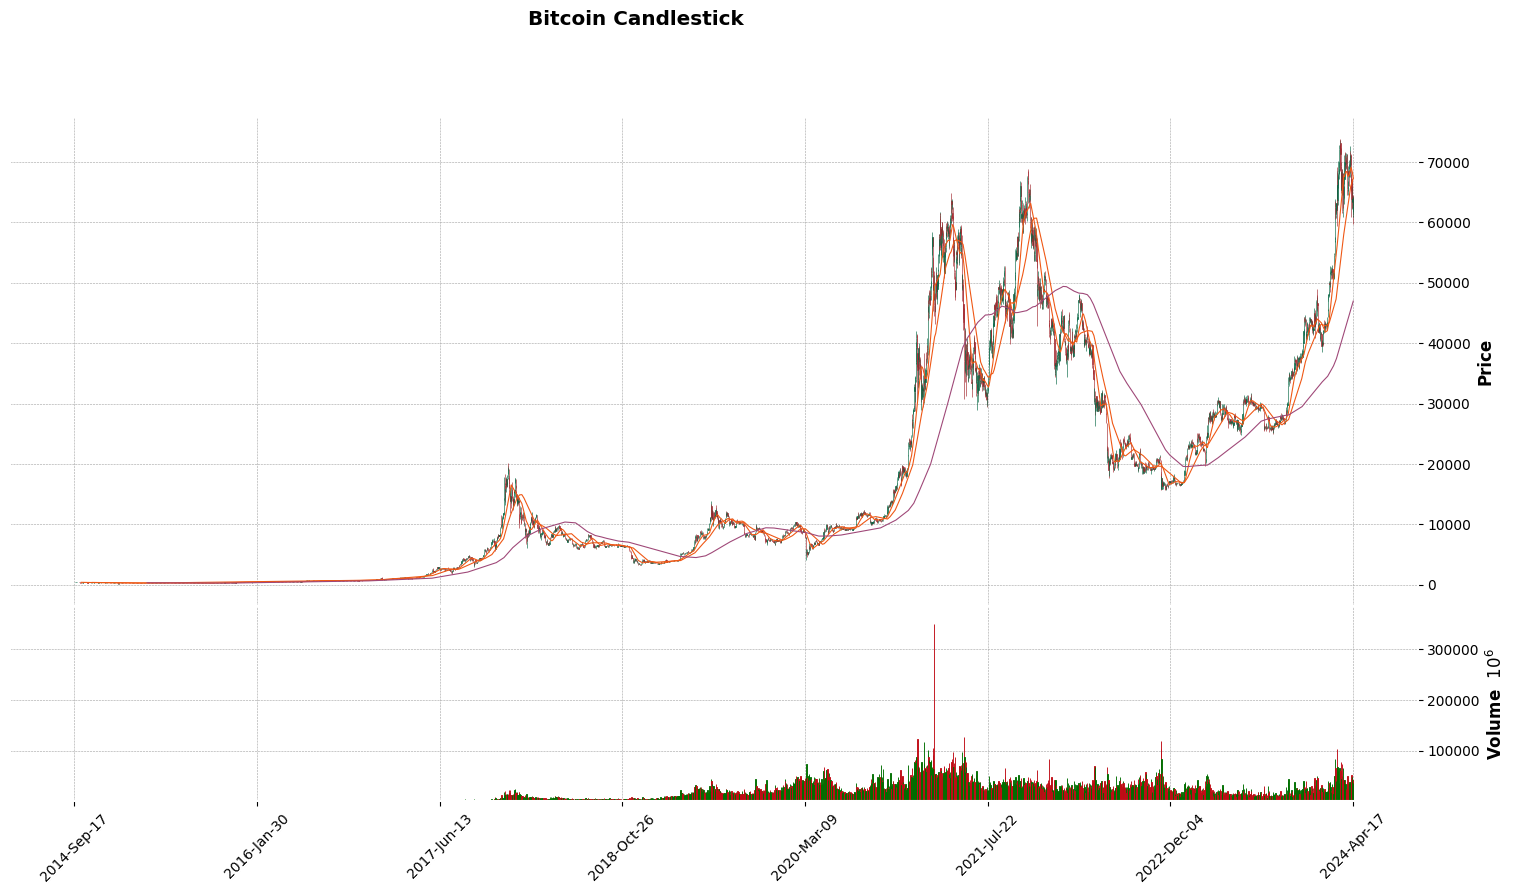

In [20]:
bitcoin_trat_df = bitcoin_trat_df.set_index('Date')
kwargs = dict(type='candle',mav=(20,50,200),volume=True,figratio=(40,20),figscale=1.7)
mpf.plot(bitcoin_trat_df[['Open', 'High', 'Low', 'Close', "Volume"]],**kwargs,style='charles', title='Bitcoin Candlestick')

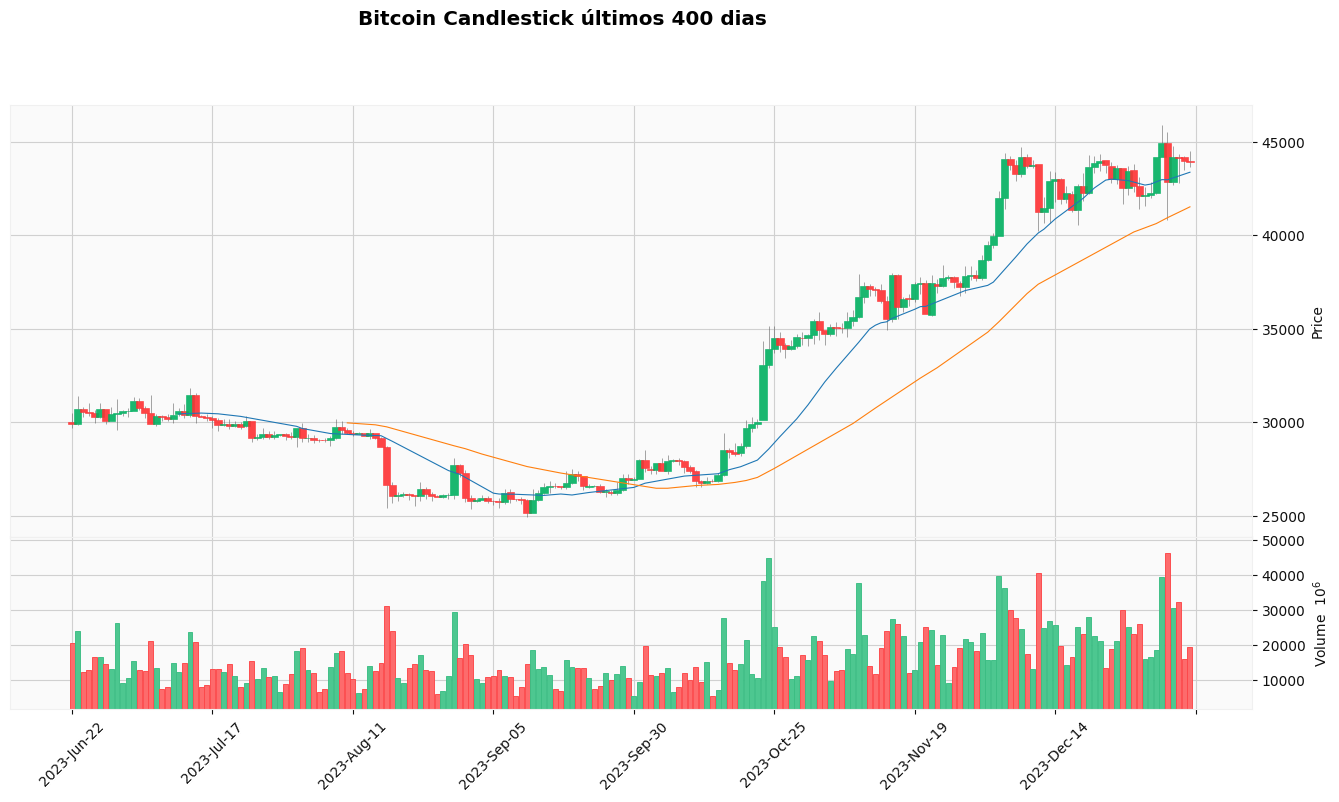

In [21]:
# Crie o gráfico de velas japonesas
kwargs = dict(type='candle',mav=(20,50,200),volume=True,figratio=(40,20),figscale=1.5)
mpf.plot(bitcoin_trat_df[['Open', 'High', 'Low', 'Close', "Volume"]].iloc[3200:3400] ,**kwargs,  style='yahoo',
         title='Bitcoin Candlestick últimos 400 dias', update_width_config=dict(candle_linewidth=0.4,candle_width=1.3))

### Periodograma do preço de fechamento do BTC

Periodograma é uma estimativa da densidade espectral de um sinal, neste caso, do preço de fechamento do Bitcoin. O periodograma é útil para identificar a presença de periodicidades ou frequências dominantes em dados temporais.

Temos um pico acentuado na extremidade mais baixa do espectro de frequências, indicando que a maior parte da energia (ou variação) do sinal está concentrada em movimentos de longo prazo. O decaimento suave e consistente conforme a frequência aumenta sugere que as variações de preço de curto prazo têm menos influência no sinal total em comparação com as tendências de longo prazo.

Por fim, a falta de picos em frequências mais altas sugere que não há periodicidades curtas fortes e regulares no preço de fechamento do Bitcoin. Pois as características  sãopossuem são de séries temporais que não possuem oscilações periódicas significativas ou sazonais e sim tendências de longo prazo.


In [23]:
# Configurando o estilo do gráfico
dic = {
    'font.sans-serif': ['Arial'],  # Fonte
    'font.family': ['Arial']}
sns.set_style(rc=dic)
plt.style.use('ggplot')

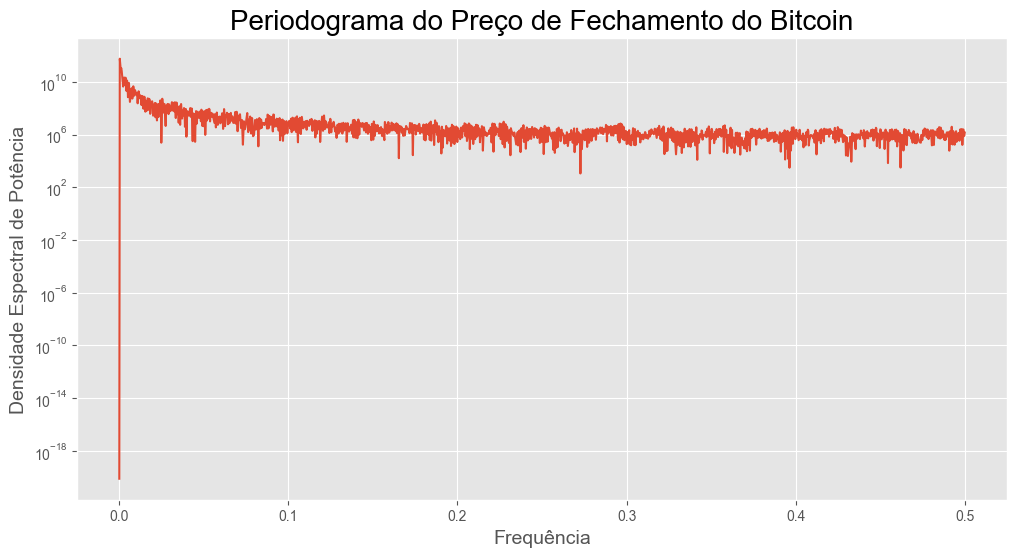

In [24]:
plt.figure(figsize=(12, 6))
freqs, power = periodogram(bitcoin_trat_df['Close'])
plt.semilogy(freqs, power)
plt.title('Periodograma do Preço de Fechamento do Bitcoin', fontsize=20)
plt.xlabel('Frequência', fontsize=14)
plt.ylabel('Densidade Espectral de Potência', fontsize=14)
plt.show()

# Modelagem

## Correlação de Pearson

No gráfico de correlação de pearson podemos visualizar as variáveis que possuem uma alta correlação com a variável de fechamento de preço do bitcoin. Podemos concluir que variáveis como Open, High, Low, Close, Lag_1 e outras possuem alta correlação, isso serve como um alerta para um contexto de  multicolinearidade 

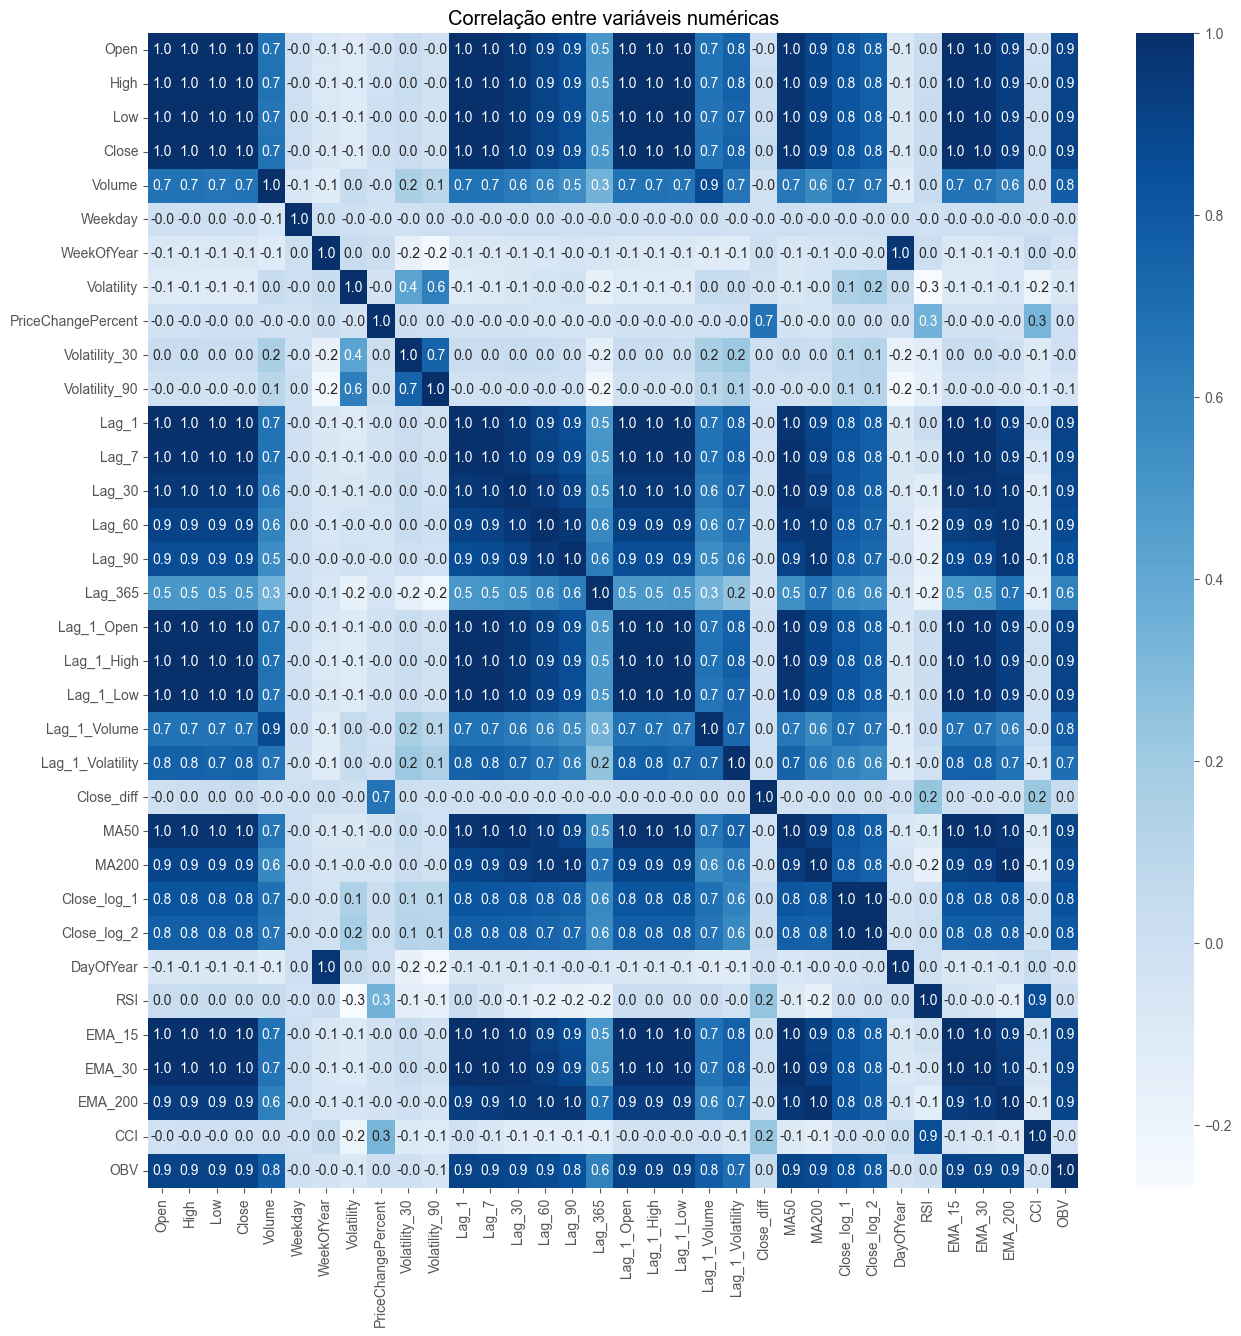

In [25]:
# Selecionar apenas colunas numéricas para a correlação
colunas_numericas = bitcoin_trat_df.select_dtypes(include=['float64', 'int64'])

# Calcular a matriz de correlação apenas com as colunas numéricas
corr = colunas_numericas.corr()

# Criar um heatmap com a matriz de correlação
plt.rcParams['figure.figsize'] = [15, 15]
sns.heatmap(corr, annot=True, fmt='.1f', cmap='Blues')
plt.title('Correlação entre variáveis numéricas')
plt.show()

## Power Predict Score (PPscore)

O heatmap abaixo nos permite visualizar o poder preditivo das variáriaveis do eixo Y sobre as variáveis do eixo X. Diferentemente da correlação que nos mostra a relação linear entre duas variáveis o PPScore nos permite testar outros padrões de relação entre duas variáveis. 

Aqui já conseguimos ver a importância do halving, Quarter, MonthName, volatilidade e um peso menor em Volume e Lags acima de 30. 

CPU times: total: 31.5 s
Wall time: 37.8 s


<Axes: >

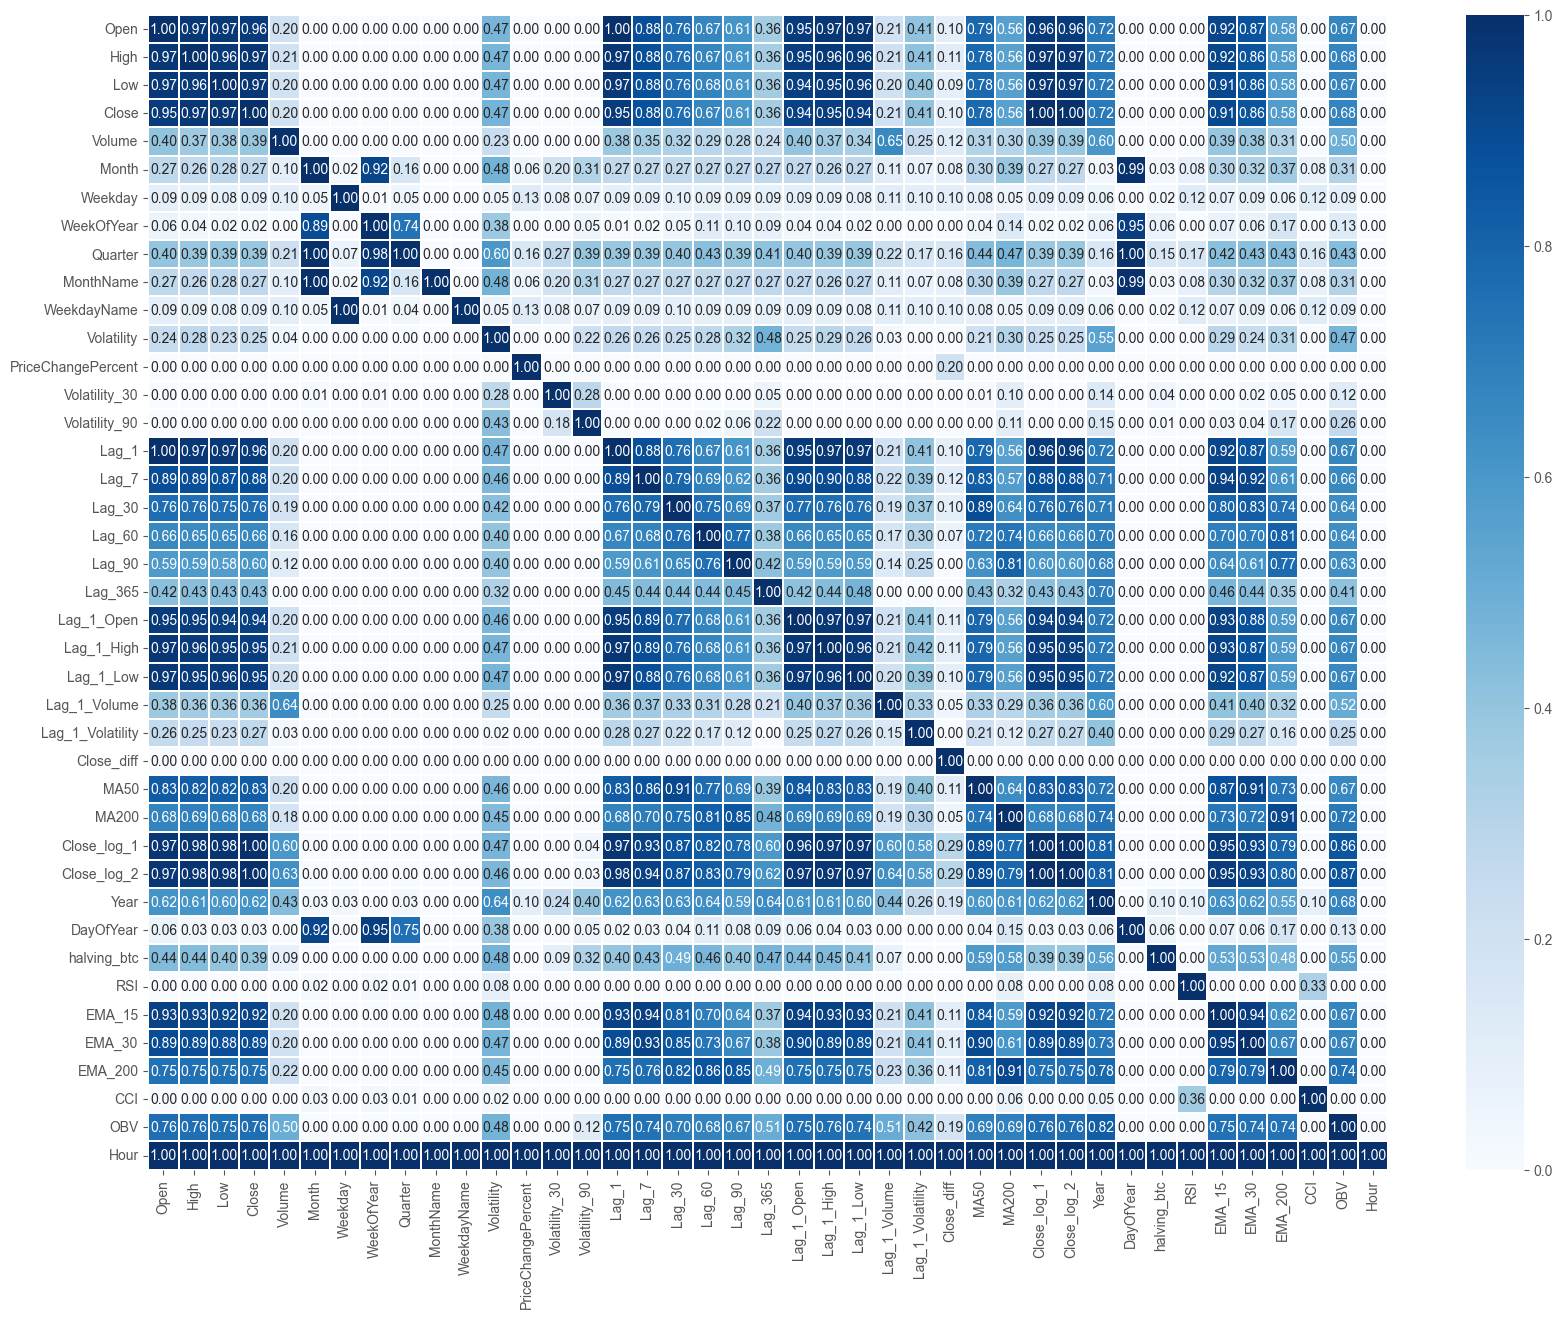

In [26]:
%%time

plt.rcParams['figure.figsize'] = [20, 15]
# Calculando e visualizando a matriz de preditividade de poder (Predictive Power Score - PPS).
# PPS é uma alternativa ao coeficiente de correlação de Pearson para medir a relação não linear entre variáveis.
# A pontuação varia de 0 (sem poder preditivo) a 1 (poder preditivo perfeito). Pode ser utilizado como alternativa à correlação (matriz).
df_matrix = pps.matrix(bitcoin_trat_df)

# Criando um mapa de calor com os valores PPS.
# Valores de PPS variam de 0 a 1, onde 1 indica uma relação previsível perfeita entre duas variáveis.
sns.heatmap(df_matrix, vmin=0, vmax=1, annot=True, fmt='.2f', cmap="Blues", linewidths=0.15)

# Sobre o PPScore
# https://research.macrosynergy.com/the-predictive-power-score/
# https://pypi.org/project/ppscore/#:~:text=The%20PPS%20is%20an%20asymmetric,to%20the%20correlation%20(matrix).
# https://machinelearningknowledge.ai/predictive-power-score-vs-correlation-with-python-implementation/

## Decomposição da serie temporal

Existem dois modelos de decomposição temporal, são eles o aditivo e o multiplicativo. Nós utilizamos o <br>
- Aditivo: Quando as flutuações sazonais são aproximadamente constantes ao longo da série.<br>
- Multiplicativo: Quando as flutuações sazonais aumentam ou diminuem proporcionalmente ao nível da série.<br>

O que é cada sub-gráfico (subplot)?

- Componente de Tendência: Mostra a tendência de longo prazo da série temporal. No seu gráfico, a tendência é claramente ascendente, o que significa que, ao longo do tempo, o valor do Bitcoin em logaritmo tem aumentado.

- Componente Sazonal: Esta parte do gráfico mostra padrões que se repetem em intervalos regulares de tempo. No caso do seu gráfico, a sazonalidade parece ser bastante volátil, mas não apresenta um padrão claro e regular que se repita ao longo do tempo, o que é comum em dados financeiros como os preços de criptomoedas, pois são influenciados por diversos fatores de mercado que variam muito e nem sempre são sazonais.

- Componente de Resíduo: Representa o que resta depois de remover a tendência e a sazonalidade dos dados. É a parte da série que não pode ser explicada pelos modelos de tendência e sazonalidade, podendo incluir o efeito de variáveis aleatórias e ruído. O resíduo no gráfico parece estar centrado em torno de um valor constante sem padrões claros, o que sugere que a decomposição foi bastante efetiva em isolar a tendência e a sazonalidade.

### Variavel sem ter sido transformada

Conclusões e Insights:<br>
Tendência: <br>
- O mercado do Bitcoin é fortemente influenciado pela tendência de longo prazo. Um destaque importante é que os dados (da variãvel de fechamento) não são estacionários, logo a decomposição da serie temporal pode refletir no gráfico tendência. <br>

Sazonalidade: <br>
- O componente sazonal não é o mais proeminente.<br>

- Resíduos:<br>
Há uma quantidade significativa de variação nos dados que é capturada no termo residual. Outra consequência da variável não ser transformada é na volatilidade dos resíduos  <br>

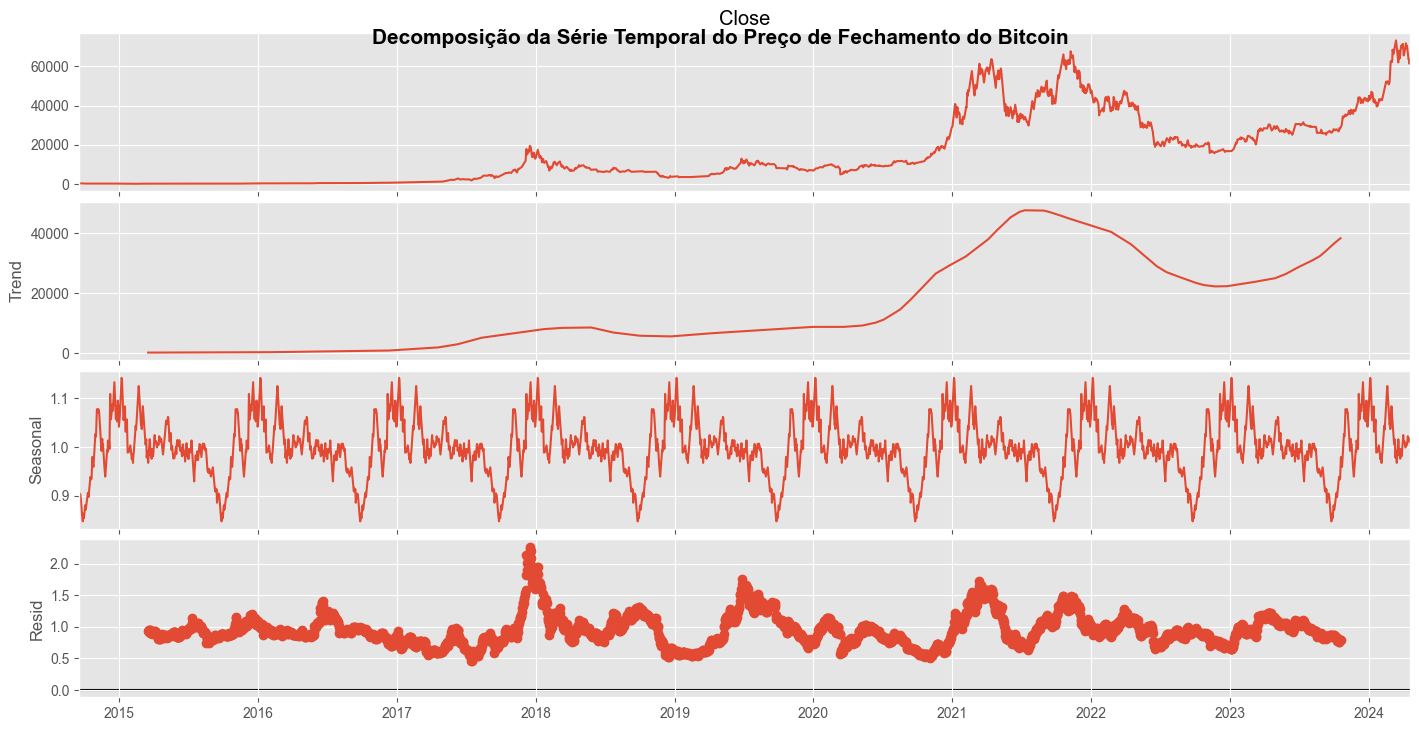

In [27]:
# Decompondo a série temporal do preço de fechamento diário
decomposition = seasonal_decompose(bitcoin_trat_df['Close'], model='multiplicative', period=365)

# Plotando os componentes da decomposição
fig = decomposition.plot()
fig.set_size_inches(14, 7)
fig.suptitle('Decomposição da Série Temporal do Preço de Fechamento do Bitcoin', fontsize=15)
plt.show()

### Decomposição com a variável após transformaação de log

A ideia de utilizar uma transformação de logaritmo é com o intuito de suavizar a variância. O primeiro gráfico da decomposição nos permite acompanhar a evolução do bitcoin ao longo dos anos, podemos concluir que o ativo está em crescimento.<br>
Tendência (Trend):<br>
- Podemos ver que a tendência geral é de alta, indicando que, ao longo do tempo, o valor do Bitcoin tem aumentado.<br>
Sazonalidade (Seasonal):<br>
- Esta série não parece ter um padrão sazonal claro e constante. Em vez disso, há flutuações que se repetem, mas sem um padrão regular e previsível. A ausência de uma sazonalidade forte e consistente pode indicar que o Bitcoin é menos afetado por fatores sazonais do que por eventos específicos<br>
Resíduos (Residual):<br>
- Os resíduos parecem ser relativamente estáveis e giram em torno de um valor constante (perto de 1, após a transformação logarítmica), o que sugere que a maior parte das variações foi capturada pela tendência e que os resíduos representam o ruído aleatório ou os efeitos de eventos pontuais.<br>

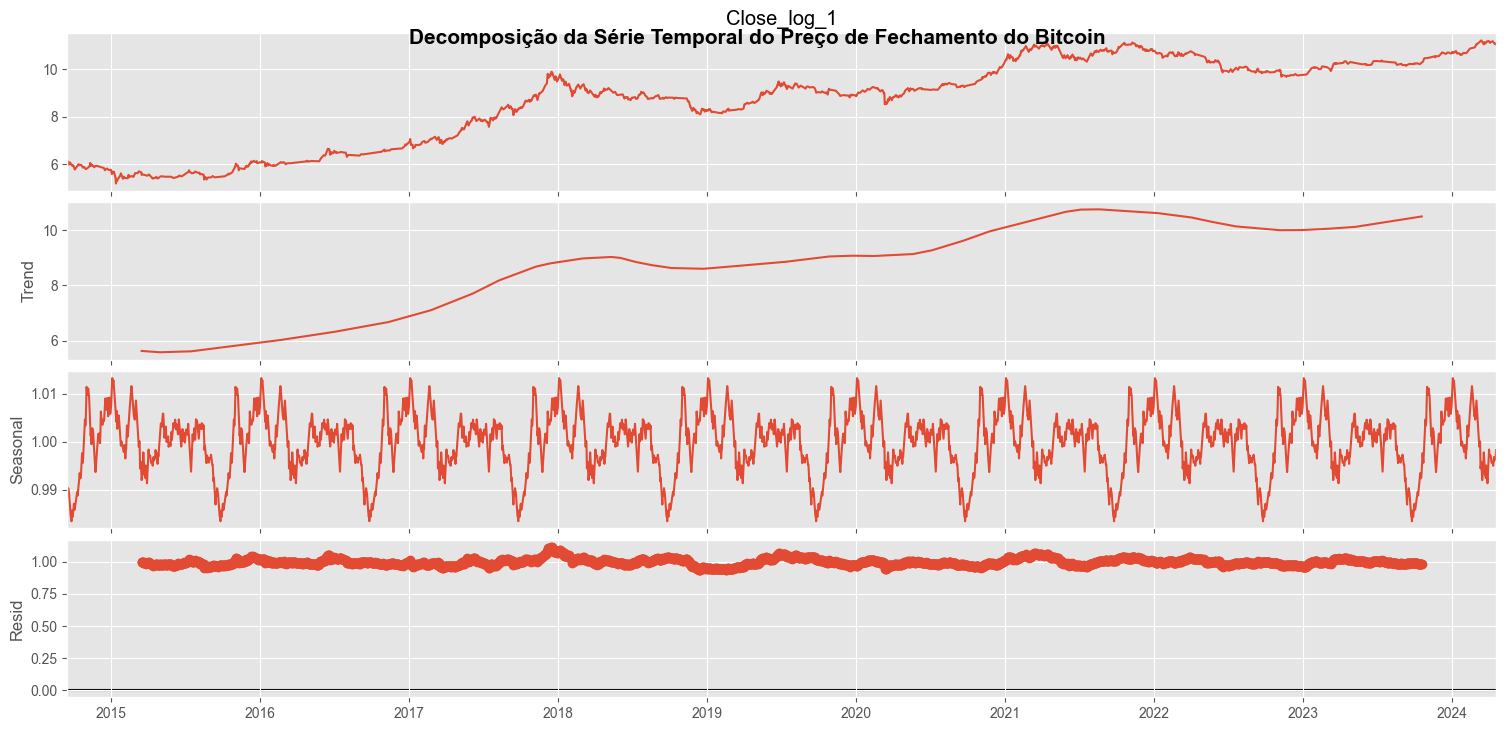

In [28]:
# Decompondo a série temporal do preço de fechamento diário
decomposition = seasonal_decompose(bitcoin_trat_df['Close_log_1'], model='multiplicative', period=365)

# Plotando os componentes da decomposição
fig = decomposition.plot()
fig.set_size_inches(15, 7)
fig.suptitle('Decomposição da Série Temporal do Preço de Fechamento do Bitcoin', fontsize=15)
plt.show()

## Testes estatísticos úteis para série temporal

Teste de Memória da Série são em séries temporais, são métodos estatísticos usados para determinar se as observações passadas de uma série temporal influenciam as futuras em um período de tempo estendido. Em outras palavras, verifica-se se existe persistência ou dependência a longo prazo entre os valores na série.

Antipersistente (H < 0.5) H<0.5, a série temporal exibe reversão à média (Anti-persistent behavior)<br>
Aleatória (H ≈ 0.5) H=0.5, a série temporal age como um passeio aleatório (Geometric Brownian Motion<br>
Persistente (H > 0.5) H>0.5, a série temporal mostra persistência (Trend-following behavior).<br>

heteroscedasticidade (variância não constante)

### Teste de Hurst

In [30]:
from hurst import compute_Hc 

# Sua série temporal
series = bitcoin_trat_df.Close_log_1

# Calcule o Exponente de Hurst
H, c, data = compute_Hc(series, kind='price', simplified=True)

# Imprima o resultado
print('Exponente de Hurst:', H)

Exponente de Hurst: 0.7110165424719302


Teste de Hurst: O valor acima de 0.5 sugere persistência na série temporal, o que é uma informação útil para entender o comportamento da série e pode justificar o uso de um modelo autorregressivo.

### Teste de Variância Reescalonada

Teste de Variância Reescalonada: Se refere a mudanças na variabilidade da série ao longo do tempo, indicando que a série pode ter volatilidade condicional que pode ser modelada por um modelo GARCH se persistir após a modelagem ARIMA.

In [ ]:
def rescaled_range_analysis(series, max_scale=20):
    """ Calculate the Rescaled Range (R/S) analysis of a time series. """
    n = len(series)
    log_rs = []
    scales = np.logspace(1, max_scale, num=max_scale, base=2).astype(int)
    scales = np.unique(scales)  # Ensure unique scales only

    for scale in scales:
        if scale > n:
            break
        scaled_series = [series[i:i + scale] for i in range(0, n, scale)]
        rs_values = []
        
        for subseries in scaled_series:
            if len(subseries) < scale:
                break
            mean_sub = np.mean(subseries)
            range_sub = np.ptp(np.cumsum(subseries - mean_sub))
            std_sub = np.std(subseries)
            rs_values.append(range_sub / std_sub if std_sub != 0 else 0)

        if rs_values:
            log_rs.append([np.log2(scale), np.log2(np.mean(rs_values))])

    log_rs = np.array(log_rs)
    H, c = np.polyfit(log_rs[:, 0], log_rs[:, 1], 1)
    return H, c, log_rs

# Calculating the Rescaled Range analysis for 'Close' series
H, c, log_rs_data = rescaled_range_analysis(bitcoin_trat_df['Close_log_1'].values, max_scale=10)

print(H,c,log_rs_data)

# Plotting the Rescaled Range analysis
plt.figure(figsize=(10, 6))
plt.plot(log_rs_data[:, 0], log_rs_data[:, 1], marker='o', linestyle='-')
plt.plot(log_rs_data[:, 0], H * log_rs_data[:, 0] + c, color='blue', label=f'Linear fit H={H:.4f}')
plt.xlabel('log(Scale)')
plt.ylabel('log(R/S)')
plt.title('Rescaled Range Analysis of Bitcoin Close Prices')
plt.legend()
plt.grid(True)
plt.show()




### Teste de Ljung-Box

In [31]:
#https://en.wikipedia.org/wiki/Ljung%E2%80%93Box_test

Análise do teste de Ljung-Box do Lag 1/Lag 7/Lag 60/Lag 90:<br>
O resultado do teste de Ljung-Box e o p-value (rejeição da hipotese nula) dele indica que há autocorrelação nós 4 lags testados, há uma forte indicação de autocorrelação, que pode ser devido a padrões sazonais ou cíclicos trimestrais.<br>
<br>

Ljung-Box test value (Lag 1): 8.904438560170462
Ljung-Box test p-value (Lag 1): 0.0028447832973085467
Ljung-Box test value (Lag 7): 19.629841126583205
Ljung-Box test p-value (Lag 7): 0.006427240324782751
Ljung-Box test value (Lag 60): 278.8451621665378
Ljung-Box test p-value (Lag 60): 6.150780392216115e-30
Ljung-Box test value (Lag 90): 334.2283740795779
Ljung-Box test p-value (Lag 90): 8.763760427360432e-30


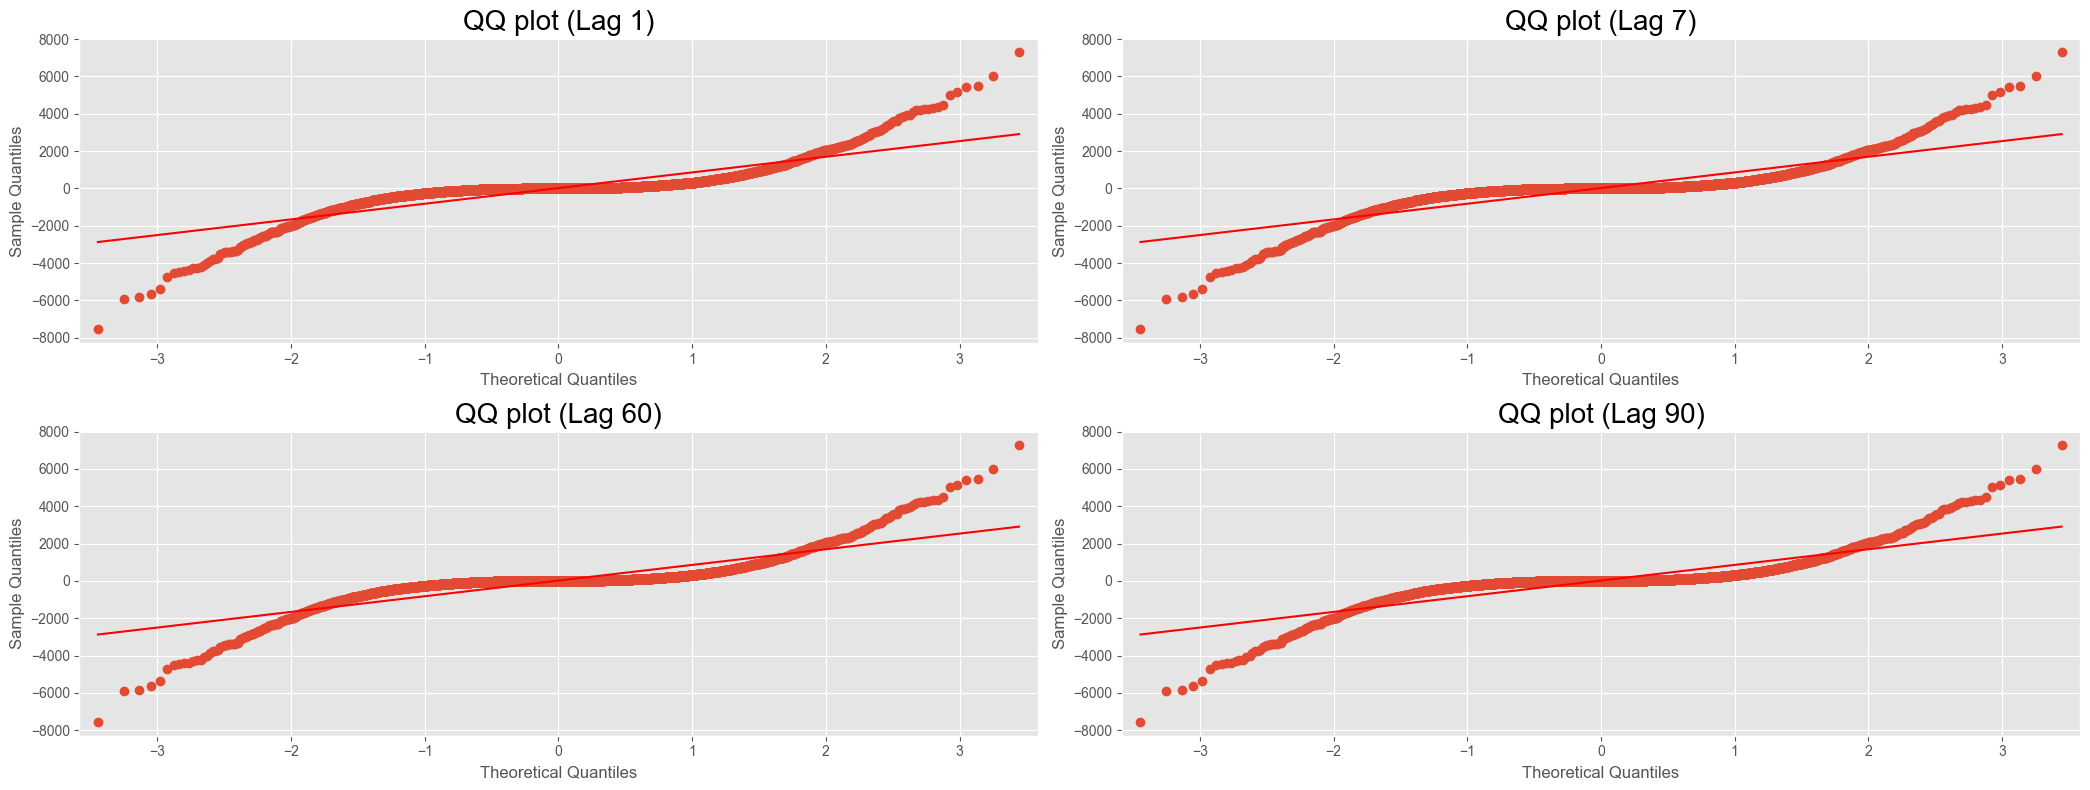

In [32]:
# Dados
close = bitcoin_trat_df['Close_diff'].dropna()

# Configurando a área de plotagem
fig, axes = plt.subplots(2, 2, figsize=(21, 8))

# Lags que queremos testar
lags = [1, 7, 60, 90]

# Iterando sobre os lags e criando os gráficos
for i, lag in enumerate(lags):
    # Criando o QQ plot no subplot correspondente
    ax = axes[i // 2, i % 2]  # Isso seleciona o eixo correto na matriz de plots
    qqplot(close, line='s', ax=ax)
    ax.set_title(f'QQ plot (Lag {lag})', fontsize=20)

    # Realizando o teste de Ljung-Box para o lag correspondente
    df_gr = acorr_ljungbox(close, lags=[lag], return_df=False)

    # Imprimindo os resultados do teste de Ljung-Box
    print(f"Ljung-Box test value (Lag {lag}): {df_gr['lb_stat'].values[0]}")
    print(f"Ljung-Box test p-value (Lag {lag}): {df_gr['lb_pvalue'].values[0]}")

# Mostrando os plots
plt.tight_layout()
plt.show()

### Teste Dickey-Fuller

O teste ADF é usado para determinar se uma série temporal possui uma tendência estocástica ou determinística, indicada pela presença de uma raiz unitária. Se uma série temporal possui uma raiz unitária, significa que a série pode ser não estacionária, ou seja, sua média, variância e covariância não são constantes ao longo do tempo.

Hipóteses do teste:

Hipótese nula (H0): A série temporal possui uma raiz unitária (não estacionária).

Hipótese alternativa (H1): A série temporal não possui raiz unitária (estacionária).

Análise do resultado do teste dickey-fuller aumentativo (ADF)<br>
'Close': O valor-p é 0.8167, o que significa que não podemos rejeitar a hipótese nula de que há uma raiz unitária, indicando que a série não é estacionária.<br>
'Close_diff': O valor-p é extremamente baixo (2.845e-14), permitindo rejeitar a hipótese nula e concluir que a série diferenciada é estacionária.<br>
'Close_log_1': O valor-p é 0.8103, semelhante ao da série 'Close', indicando que a série também não é estacionária.<br>

In [33]:
# Realizando o teste Dickey-Fuller Aumentado (ADF)
adf_test = adfuller(bitcoin_trat_df['Close'], autolag='AIC')

# Exibindo os resultados
print(f'Valor-p: {adf_test[1]}')
if adf_test[1] <= 0.05:
    print("A série é estacionária.")
else:
    print("A série não é estacionária.")

# Mostrando os resultados detalhados
print("Resultado Detalhado do Teste ADF:")
print(f"Statistic: {adf_test[0]}")
print(f"Valor-p: {adf_test[1]}")
print("Valores Críticos:")
for key, value in adf_test[4].items():
    print(f'    {key}: {value}')

# Realizando o teste Dickey-Fuller Aumentado (ADF)
adf_test_diff = adfuller(bitcoin_trat_df['Close_diff'].dropna(), autolag='AIC')

# Exibindo os resultados
print(f'Valor-p: {adf_test_diff[1]}')
if adf_test_diff[1] <= 0.05:
    print("\nApós a diferenciação a série é estacionária. (Close_diff)")
else:
    print("\nApós a diferenciação a série não é estacionária.(Close_diff)")

# Mostrando os resultados detalhados
print("Resultado Detalhado do Teste ADF na Variavel Close_diff:")
print(f"Statistic: {adf_test_diff[0]}")
print(f"Valor-p: {adf_test_diff[1]}")
print("Valores Críticos:")
for key, value in adf_test_diff[4].items():
    print(f'    {key}: {value}')

# Realizando o teste Dickey-Fuller Aumentado (ADF)
adf_test_diff = adfuller(bitcoin_trat_df['Close_log_1'].dropna(), autolag='AIC')

# Exibindo os resultados
print(f'Valor-p: {adf_test_diff[1]}')
if adf_test_diff[1] <= 0.05:
    print("\nApós a diferenciação a série é estacionária. (Close_log_1)")
else:
    print("\nApós a diferenciação a série não é estacionária.(Close_log_1)")

# Mostrando os resultados detalhados
print("Resultado Detalhado do Teste ADF na Variavel Close_log_1:")
print(f"Statistic: {adf_test_diff[0]}")
print(f"Valor-p: {adf_test_diff[1]}")
print("Valores Críticos:")
for key, value in adf_test_diff[4].items():
    print(f'    {key}: {value}')

Valor-p: 0.8125925229455087
A série não é estacionária.
Resultado Detalhado do Teste ADF:
Statistic: -0.8219391255353901
Valor-p: 0.8125925229455087
Valores Críticos:
    1%: -3.432234833314157
    5%: -2.8623728118639256
    10%: -2.567213320577125
Valor-p: 2.1621145092638264e-14

Após a diferenciação a série é estacionária. (Close_diff)
Resultado Detalhado do Teste ADF na Variavel Close_diff:
Statistic: -8.797059683112064
Valor-p: 2.1621145092638264e-14
Valores Críticos:
    1%: -3.432235920478648
    5%: -2.862373292074422
    10%: -2.5672135762276906
Valor-p: 0.812563944162193

Após a diferenciação a série não é estacionária.(Close_log_1)
Resultado Detalhado do Teste ADF na Variavel Close_log_1:
Statistic: -0.8220339071127064
Valor-p: 0.812563944162193
Valores Críticos:
    1%: -3.4322245674254277
    5%: -2.8623682773183745
    10%: -2.5672109065140374


### Teste de Kpss

O teste KPSS é utilizado para testar a hipótese nula de que uma série temporal é estacionária em torno de uma média constante (versão sem tendência) ou de uma tendência linear (versão com tendência). Esse teste é útil porque complementa o teste ADF, ajudando a identificar diferentes tipos de não estacionariedade. Enquanto o ADF foca em raízes unitárias, o KPSS testa a estacionariedade assumindo que a série pode ter uma raiz unitária como componente de tendência ou drift.<br><br>

Hipótese nula (H0): A série temporal é estacionária (em torno de uma média ou tendência).<br>
Se a estatística de teste for menor ou igual ao valor crítico para um dado nível de significância, então você não rejeita a hipótese nula de estacionariedade.<br>

Hipótese alternativa (H1): A série temporal não é estacionária (tem raiz unitária).<br>
Se a estatística de teste for maior do que o valor crítico, então a hipótese nula é rejeitada, sugerindo que a série é não estacionária<br>.

In [34]:
# Teste de Kpss
kpss_test = kpss(bitcoin_trat_df['Close'].dropna())
print(f'\nValor-p: {kpss_test[1]} do teste kpss para variavel Close \n')

# Teste de Kpss
kpss_test = kpss(bitcoin_trat_df['Close_diff'].dropna())
print(f'Valor-p: {kpss_test[1]} do teste kpss para variavel Close_diff\n')

# Teste de Kpss
kpss_test = kpss(bitcoin_trat_df['Close_log_1'].dropna())
print(f'Valor-p: {kpss_test[1]} do teste kpss para variavel Close_log_1\n')


Valor-p: 0.01 do teste kpss para variavel Close 

Valor-p: 0.1 do teste kpss para variavel Close_diff

Valor-p: 0.01 do teste kpss para variavel Close_log_1



'Close': O valor-p é 0.01, indicando que rejeitamos a hipótese nula de estacionariedade, o que sugere que a série é não estacionária.<br>
'Close_diff': O valor-p é 0.1, o que não permite rejeitar a hipótese nula de estacionariedade, indicando que a série é estacionária.<br>
'Close_log_1': O valor-p é 0.01, rejeitando a hipótese nula de estacionariedade, o que sugere que a série é não estacionária.<br>

### Teste Phillips-Perron

O teste Phillips-Perron é uma abordagem para testar a presença de uma raiz unitária em uma série temporal, semelhante ao teste Dickey-Fuller Aumentado (ADF). A principal diferença é que o teste Phillips-Perron faz ajustes na estatística do teste para contabilizar formas mais gerais de autocorrelação e dependência heterogênea nos resíduos, sem a necessidade de especificar um modelo AR específico para a série temporal.<br>


Características do Teste Phillips-Perron:<br>
Não necessita de um modelo de autocorrelação: Ao contrário do ADF, que utiliza um processo autorregressivo para modelar os resíduos, o teste Phillips-Perron corrige diretamente a estatística de teste para possíveis autocorrelações e heteroscedasticidade nos resíduos.<br>
Tendência: Pode ser aplicado a séries temporais com ou sem tendência e/ou intercepto, escolhendo-se o termo 'ct' (tendência constante e linear).<br>
Hipóteses: A hipótese nula é que a série contém uma raiz unitária (não é estacionária), enquanto a hipótese alternativa é que a série é estacionária.<br>

A interpretação do teste PP é semelhante à do teste ADF:<br>

Hipótese nula (H0): A série temporal possui uma raiz unitária (não estacionária).<br>
Se a estatística de teste for mais negativa do que o valor crítico para um nível de significância específico, então você rejeita a hipótese nula de raiz unitária, concluindo que a série é estacionária.<br><br>
Hipótese alternativa (H1): A série temporal não possui raiz unitária (estacionária).<br>
Se a estatística de teste não for mais negativa do que o valor crítico, então você não rejeita a hipótese nula, indicando que a série pode não ser estacionária.<br>



In [35]:
# https://vsevolodkotenyov.medium.com/providing-unit-root-testing-for-time-series-with-python-arch-library-adf-kpss-phillips-perron-b80d21e68892
php_ct = PhillipsPerron(bitcoin_trat_df['Close'], trend = 'ct')
print('Close')
print(php_ct.summary() )

# https://vsevolodkotenyov.medium.com/providing-unit-root-testing-for-time-series-with-python-arch-library-adf-kpss-phillips-perron-b80d21e68892
php_ct_Close_diff = PhillipsPerron(bitcoin_trat_df['Close_diff'].dropna(), trend = 'ct')
print( '\n\nClose_diff')
print(php_ct_Close_diff.summary())

# https://vsevolodkotenyov.medium.com/providing-unit-root-testing-for-time-series-with-python-arch-library-adf-kpss-phillips-perron-b80d21e68892
php_ct_Close_log_1 = PhillipsPerron(bitcoin_trat_df['Close_log_1'].dropna(), trend = 'ct')
print( '\n\nClose_log_1')
print(php_ct_Close_log_1.summary())

Close
     Phillips-Perron Test (Z-tau)    
Test Statistic                 -2.011
P-value                         0.595
Lags                               30
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -3.96 (1%), -3.41 (5%), -3.13 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


Close_diff
     Phillips-Perron Test (Z-tau)    
Test Statistic                -62.170
P-value                         0.000
Lags                               30
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -3.96 (1%), -3.41 (5%), -3.13 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


Close_log_1
     Phillips-Perron Test (Z-tau)    
Test Statistic                 -1.723
P-value                         0.741
Lags                               30
---------------------------------

Análise do Resultado do teste de Phillips-Perron<br>
'Close': O valor-p é 0.575, indicando que não podemos rejeitar a hipótese nula de raiz unitária, logo a série não é estacionária.<br>
'Close_diff': O valor-p é praticamente 0 (indicado como 0.000), permitindo rejeitar a hipótese nula de raiz unitária, o que indica que a série diferenciada é estacionária.<br>
'Close_log_1': O valor-p é 0.742, também indicando que não podemos rejeitar a hipótese nula de raiz unitária, logo a série não é estacionária.<br>

### Teste de Shapiro-Wilk

Shapiro-Wilk é um procedimento estatístico popular usado para avaliar a normalidade de uma distribuição de dados. É utilizado o teste de Shapiro-Wilk quando precisar testar a normalidade dos dados, e isso é uma pré-condição para a análise que você deseja realizar. <br>

O teste de Shapiro-Wilk é frequentemente usado para verificar a normalidade dos resíduos em modelos de regressão e outras análises estatísticas onde a normalidade é uma suposição importante. Uma suposição de normalidade é crucial em muitos testes estatísticos, incluindo análises de variância (ANOVA, ou seja, testes parametricos), alguns testes de correlação e testes que dependem de técnicas de inferência paramétrica.<br>

In [36]:
# Realizando o teste de Shapiro-Wilk para a coluna 'Close'
shapiro_test = shapiro(bitcoin_trat_df['Close'])
print(f'\nshapiro test na variavel Close: {shapiro_test} ')

# Realizando o teste de Shapiro-Wilk para a coluna 'Close'
shapiro_test = shapiro(bitcoin_trat_df['Close_diff'].dropna())
print(f'shapiro test na variavel Close_diff: {shapiro_test} ')

# Realizando o teste de Shapiro-Wilk para a coluna 'Close'
shapiro_test = shapiro(bitcoin_trat_df['Close_log_1'].dropna())
print(f'shapiro test na variavel Close_log_1: {shapiro_test} ')


shapiro test na variavel Close: ShapiroResult(statistic=0.8274339437484741, pvalue=0.0) 
shapiro test na variavel Close_diff: ShapiroResult(statistic=0.7069796323776245, pvalue=0.0) 
shapiro test na variavel Close_log_1: ShapiroResult(statistic=0.903275191783905, pvalue=1.57085557850812e-42) 


'Close': O valor da estatística é menor que 1 e o valor-p é 0, indicando que podemos rejeitar a hipótese nula de normalidade. Isso sugere que a distribuição dos preços de fechamento não é normal.<br>
'Close_diff': A estatística é ainda menor que a da série 'Close' e o valor-p continua sendo 0, indicando uma rejeição ainda mais forte da normalidade. A série diferenciada mostra uma distribuição que está longe de ser normal, o que é típico para dados de retorno financeiro que frequentemente exibem caudas pesadas e assimetria.<br>
'Close_log_1':  Apesar de a estatística estar mais próxima de 1, indicando uma forma mais próxima da distribuição normal comparada às outras séries, o valor-p ainda é extremamente baixo, levando à rejeição da hipótese nula de normalidade. Isto sugere que, embora a transformação logarítmica tenha ajudado a aproximar a distribuição de uma forma normal, ainda existem desvios significativos da normalidade.<br>

Tendo em vista os resultados e as conclusões podemos concluir que nenhum das séries possuem umaa distribuição normal. Isso já era um pouco esperado tendo em vista que os dados utilizados são finceiros. Geralmente dados financeiros possuem uma direção de cauda mais proeminente e picos mais pronunciados e caudas mais grossas do que seria esperado em uma distribuição normal. Abaixo utilizando o teste de kewness e Kurtosis conseguimos evidenciar o comportamento dessa distribuição

### Teste de Skewness e Kurtosis

Skewness (Assimetria) e Kurtosis<br>
Assimetria: 1.1845 - A série tem uma assimetria positiva, indicando uma cauda mais pesada à direita.<br>
Curtose: 0.4189 - A curtose é próxima de zero, sugerindo que a distribuição tem caudas semelhantes à normal, mas isso pode ser enganoso dado o valor de assimetria e os resultados do teste de Shapiro-Wilk.<br>

In [37]:
# Calculando a Skewness (Assimetria) e Kurtosis para a coluna 'Close'
skewness = skew(bitcoin_trat_df['Close'])
kurtosis_val = kurtosis(bitcoin_trat_df['Close'])

print(f'\nskewness: {skewness}') 
print(f'kurtosis {kurtosis_val}\n')


skewness: 1.1841998525768593
kurtosis 0.41216167923605473



### Autocorrelação (ACF e PACF)

Função de Autocorrelação (ACF)<br>
A ACF mede a correlação entre os valores da série temporal e os valores passados (lags). 

Função de Autocorrelação Parcial (PACF)<br>
A PACF mede a correlação entre os valores da série temporal e os valores passados que não são explicados pelas correlações em lags mais curtos. 

Para utilizar o ACF e PACF é necessário:<br>
Garantir a Estacionariedade<br>
Escolher o Número de Lags<br>

Parametros úteis:<br>
O alpha define o intervalo de confiança <br>
method='ols' usa mínimos quadrados ordinários<br>

Análise da Função de Autocorrelação (ACF)
- Decaimento Lento: A correlação diminui lentamente à medida que o número de lags aumenta, o que sugere um processo AR (AutoRegressivo).
- Primeiro Lag Elevado: O primeiro lag é significativamente alto e positivo, o que é típico em séries que foram diferenciadas para alcançar estacionariedade.
- Lags Significativos: Os lags que cruzam o limite de significância (linhas tracejadas) indicam as lags que têm correlações significativas com a série temporal.

Análise da Função de Autocorrelação Parcial (PACF)
- Corte Brusco após o Primeiro Lag: Isso indica que a primeira lag é significativa, e as lags subsequentes estão dentro do limite de confiança, Podemos dizer que para o parâmetro AR (p) o valor de 1 seria adequado.

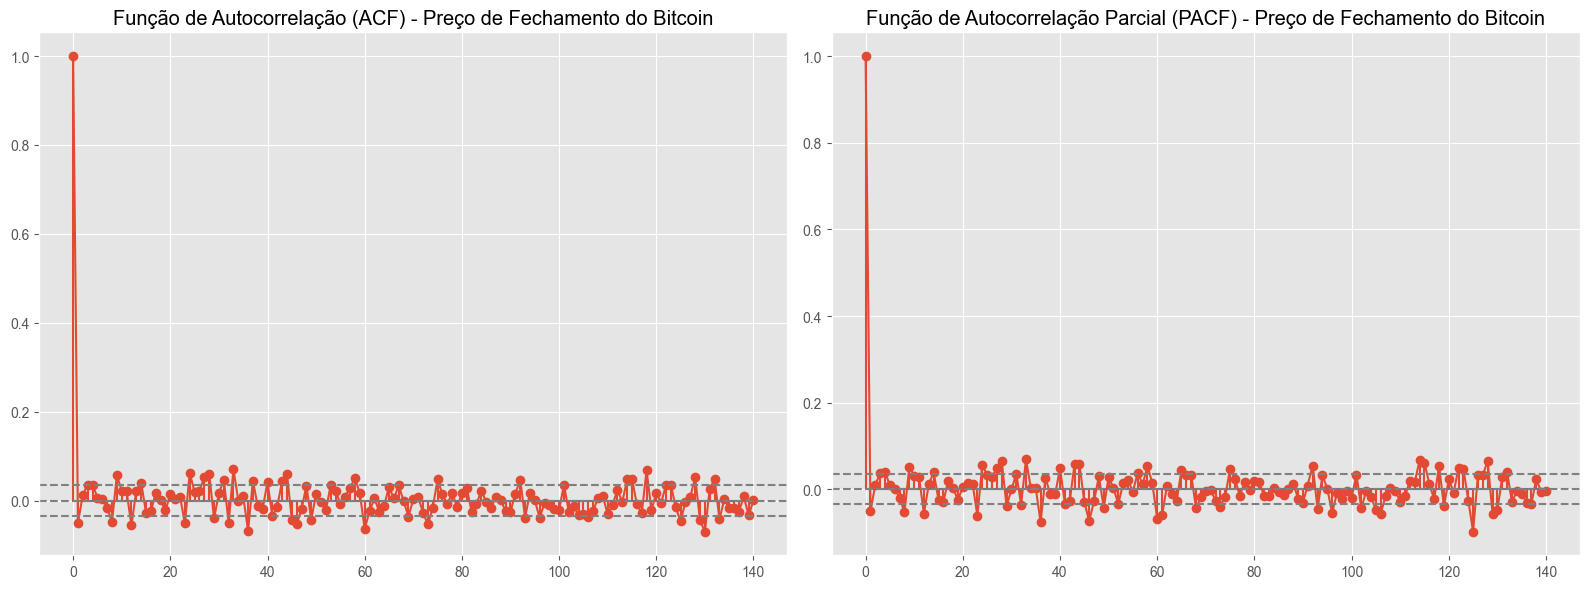

In [40]:
# Removendo qualquer linha com NaN resultante da diferenciação
bitcoin_trat_df_clean = bitcoin_trat_df.dropna()

# A série 'Close_diff' já está diferenciada e é estacionária
differenced_series = bitcoin_trat_df_clean['Close_diff'].values

lag_acf = acf(differenced_series, nlags=140)
lag_pacf = pacf(differenced_series, nlags=140, method='ols')

# Plot ACF:
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.stem(lag_acf)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(differenced_series)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(differenced_series)), linestyle='--', color='gray')
plt.title('Função de Autocorrelação (ACF) - Preço de Fechamento do Bitcoin')

# Plot PACF:
plt.subplot(122)
plt.stem(lag_pacf) 
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(differenced_series)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(differenced_series)), linestyle='--', color='gray')
plt.title('Função de Autocorrelação Parcial (PACF) - Preço de Fechamento do Bitcoin')
plt.tight_layout()


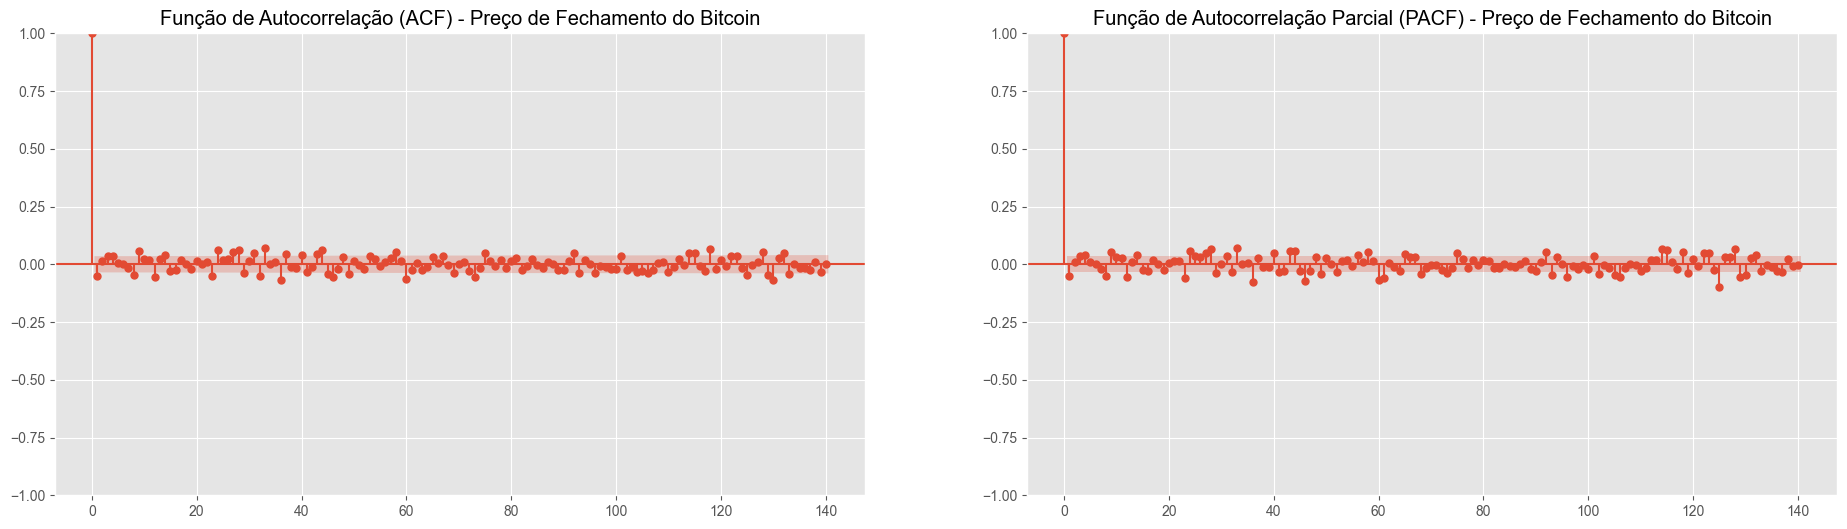

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(23, 6))

# A série 'Close_diff' já está diferenciada e é estacionária
differenced_series = bitcoin_trat_df_clean['Close_diff']

# Plot ACF:
plot_acf(differenced_series,ax=axes[0], lags=140, alpha=0.05)
axes[0].set_title('Função de Autocorrelação (ACF) - Preço de Fechamento do Bitcoin')

# Plot PACF:
plot_pacf(differenced_series, ax=axes[1], lags=140, alpha=0.05, method='ols')
axes[1].set_title('Função de Autocorrelação Parcial (PACF) - Preço de Fechamento do Bitcoin')
plt.show()


# Treinamento do Modelo

In [ ]:
# Jarque–Bera test
# https://en.wikipedia.org/wiki/Jarque%E2%80%93Bera_test 

## Modelo de Regressão

Testes de diagnóstico:<br>
Omnibus e Jarque-Bera (JB): Testes que avaliam a normalidade dos resíduos. Valores de probabilidade próximos de zero rejeitam a hipótese de normalidade.<br>
Skew (Assimetria): Próximo de zero, o que normalmente indicaria simetria, mas deve ser considerado juntamente com os outros testes.<br>
Kurtosis: Muito maior que 3, sugerindo caudas pesadas e um pico mais acentuado do que a distribuição normal.<br>
Durbin-Watson: Próximo de 2, indicando não há autocorrelação significativa nos resíduos.<br><br>
Estatísticas Diagnósticas:<br>
Durbin-Watson: Próximo de 2, o que sugere que não há autocorrelação significativa nos resíduos.<br>
Jarque-Bera (JB): O teste sugere que os resíduos não são normalmente distribuídos.<br>
Skew: Uma assimetria positiva indica que a distribuição dos resíduos é ligeiramente inclinada para a direita.<br>
Kurtosis: Um valor muito alto indica caudas mais pesadas do que uma distribuição dos resíduos.<br><br>

### Regressão simples 

In [42]:
# Criando uma variável de tempo
bitcoin_trat_df['t'] = range(1, len(bitcoin_trat_df) + 1)

# Removendo qualquer linha com NaN resultante da diferenciação
bitcoin_trat_df_clean = bitcoin_trat_df.dropna()

# Ajustando o modelo de regressão linear
modelo_lin = ols('Close_diff ~ t', data=bitcoin_trat_df_clean).fit()

# Resumo do modelo
modelo_lin_summary = modelo_lin.summary()

modelo_lin_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Close_diff   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9706
Date:                Thu, 18 Apr 2024   Prob (F-statistic):              0.325
Time:                        16:39:02   Log-Likelihood:                -25743.
No. Observations:                3137   AIC:                         5.149e+04
Df Residuals:                    3135   BIC:                         5.150e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -13.1854     37.333     -0.353      0.724     -86.384      60.013
t              0.0172      0.017      0.985      0.325      -0.017       0.051
==============================================================================
Omnibus:                      647.687   Durbin-Watson:                   2.100
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            21869.218
Skew:                          -0.131   Prob(JB):                         0.00
Kurtosis:                      15.932   Cond. No.                     5.04e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.04e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [43]:
# Realizando o teste de Shapiro-Wilk nos resíduos do modelo
shapiro_test_residuos = shapiro(modelo_lin.resid)

# Resultado do teste de Shapiro-Wilk
shapiro_result_residuos = {
    'Statistic': shapiro_test_residuos[0],
    'p-value': shapiro_test_residuos[1]
}

shapiro_result_residuos

{'Statistic': 0.7418169975280762, 'p-value': 0.0}

R-squared: 0.000 - O R-quadrado é zero, o que indica que o modelo não explica nenhuma variação  e 1 é quando o modelo explica 100% a realidade.<br>
F-statistic: 1.509 com um valor-p de 0.219 - O teste F é usado para avaliar a significância geral do modelo. Um valor-p maior que 0.05 sugere que o modelo não é significativamente diferente de um modelo sem nenhum preditor.<br><br>
Coeficientes:<br>
Intercept: Não é significativo, como indicado pelo valor-p de 0.608.<br>
t (tempo): O coeficiente é positivo, mas não é estatisticamente significativo (valor-p de 0.219).<br><br>

### Regressão Multilinear 

In [46]:
import statsmodels.formula.api as smf

### cho

In [47]:
# Preparando variáveis categóricas com variáveis dummy
bitcoin_trat_df_clean = pd.get_dummies(bitcoin_trat_df, columns=['MonthName', 'WeekdayName', 'Quarter', 'halving_btc'])

# Removendo qualquer linha com NaN resultante da diferenciação
bitcoin_trat_df_clean = bitcoin_trat_df_clean.dropna()

# Selecionando as colunas para o modelo, incluindo as variáveis dummy geradas
selected_columns = ['Lag_1_Open', 'Lag_1_High', 'Lag_1_Low', 'Lag_1_Volume', 'RSI', 'EMA_15', 'EMA_30', 'EMA_200', 'OBV', 
                    'MA50', 'MA200', 'Lag_1_Volume', 'Lag_1_Volatility', 'Volatility_30', 'Volatility_90', 
                    'CCI', 'Lag_1', 'Lag_7', 'Lag_30', 'Lag_60', 'Lag_365'] + \
                   [col for col in bitcoin_trat_df_clean.columns if 'MonthName_' in col] + \
                   [col for col in bitcoin_trat_df_clean.columns if 'WeekdayName_' in col] + \
                   [col for col in bitcoin_trat_df_clean.columns if 'Quarter_' in col] + \
                   [col for col in bitcoin_trat_df_clean.columns if 'halving_btc_' in col]

# Normalizando as características
scaler = StandardScaler()
bitcoin_trat_df_clean[selected_columns] = scaler.fit_transform(bitcoin_trat_df_clean[selected_columns])

# Separando os dados em conjuntos de treino e teste
train_df, test_df = train_test_split(bitcoin_trat_df_clean, test_size=0.2, random_state=42)

# Construindo a fórmula para o modelo de regressão múltipla
formula = 'Close_diff ~ ' + ' + '.join(selected_columns)

# Ajustando o modelo de regressão múltipla no conjunto de treinamento
modelo_lin_mult_complex = smf.ols(formula, data=train_df).fit()

# Previsões no conjunto de teste
test_df['predicted_close_diff'] = modelo_lin_mult_complex.predict(test_df)

# Cálculo do MAE e RMSE
mae = mean_absolute_error(test_df['Close_diff'], test_df['predicted_close_diff'])
rmse = np.sqrt(mean_squared_error(test_df['Close_diff'], test_df['predicted_close_diff']))

# Exibindo os resultados
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

# Resumo do modelo
modelo_lin_mult_complex_summary = modelo_lin_mult_complex.summary()
print(modelo_lin_mult_complex_summary)

MAE: 413.9314547304734
RMSE: 707.04027236532
                            OLS Regression Results                            
Dep. Variable:             Close_diff   R-squared:                       0.366
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     36.53
Date:                Thu, 18 Apr 2024   Prob (F-statistic):          3.25e-212
Time:                        16:39:43   Log-Likelihood:                -20036.
No. Observations:                2509   AIC:                         4.015e+04
Df Residuals:                    2469   BIC:                         4.039e+04
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

In [48]:
#Teste de Variância Reescalonada
# Obtenha os resíduos
residuals = modelo_lin_mult_complex.resid

# Execute o teste de Breusch-Pagan
bp_test = het_breuschpagan(residuals, modelo_lin_mult_complex.model.exog)

# Imprima os resultados
print('Valores do Teste de Breusch-Pagan:', bp_test)

Valores do Teste de Breusch-Pagan: (506.1111108573907, 3.038880969046563e-78, 15.997256090116878, 1.54490732230516e-93)


In [49]:
# Realizando o teste de Shapiro-Wilk nos resíduos do modelo
shapiro_test_residuos = shapiro(modelo_lin_mult_complex.resid)

# Resultado do teste de Shapiro-Wilk
shapiro_result_residuos = {
    'Statistic': shapiro_test_residuos[0],
    'p-value': shapiro_test_residuos[1]
}

shapiro_result_residuos

{'Statistic': 0.835098147392273, 'p-value': 2.802596928649634e-45}

Para um modelo de regressão voltado para séries temporais, especialmente se estiver utilizando métodos como regressão linear múltipla vale destacar que a variável a ser predita precisa ser estacionária. Portanto vamos utilizar a variável Close_diff, vale lembrar que utilizar uma variável estacionária como a variável dependente ajuda a evitar problemas como autocorrelação residual, o que pode levar a inferências incorretas sobre os efeitos das variáveis independentes. 

Por fim vale lembrar que modelos de regressão tendem a não performar tão bem com dados financeiros. 

Resultado do modelo
R² foi de 37.3% da variação na variável Close_diff é explicada pelas variáveis independentes no modelo. Este é um valor razoável, considerando que dados financeiros costumam ser bastante ruidosos e difíceis de modelar perfeitamente.

F-statistic
O teste F é significativo, o que sugere que o modelo como um todo tem poder explicativo.

EMA_15, OBV, e CCI possuem coeficientes com p-valores significativos
Lag_1 e Lag_7 também mostram coeficientes significativos e grandes em magnitude, sugerindo que os preços passados têm um forte impacto. Isso corrobora com os testes de Hurst

O teste de Durbin-Watson teve como resultado 1.998, este valor está muito próximo de 2, o que indica que há pouca ou nenhuma autocorrelação entre os resíduoss.

Normalidade dos Resídus:

Teste de Shapiro-Wilk: Um p-valor de 0.0 e uma estatística de 0.8304 indicam que os resíduos não são normalmente distribuí O teste de elo.
Omnibus e Jarqu corrobora o de Shapiro-Wilk, ou seja,  aera: Ambos rejeitam a normalidade dos resíduos, indicando a presença de curtose e assimetria significativas.

### Modelo de regressão multilinear utilizando sklearn

In [50]:
# Criando uma variável de tempo
bitcoin_trat_df['t'] = range(1, len(bitcoin_trat_df) + 1)
#bitcoin_trat_df.reset_index(inplace=True)

# Preparando variáveis categóricas com variáveis dummy
bitcoin_trat_df_clean = pd.get_dummies(bitcoin_trat_df, columns=['MonthName', 'WeekdayName', 'Quarter', 'halving_btc'])

# Removendo qualquer linha com NaN resultante da diferenciação
bitcoin_trat_df_clean = bitcoin_trat_df_clean.dropna()

# Selecionando as colunas para o modelo, incluindo as variáveis dummy geradas
selected_columns = ['Lag_1_Open', 'Lag_1_High', 'Lag_1_Low', 'Lag_1_Volume', 'RSI', 'EMA_15', 'EMA_30', 'EMA_200', 'OBV', 
                    'MA50', 'MA200', 'Lag_1_Volume', 'Lag_1_Volatility', 'Volatility_30', 'Volatility_90', 
                    'CCI', 'Lag_1', 'Lag_7', 'Lag_30', 'Lag_60', 'Lag_365'] + \
                   [col for col in bitcoin_trat_df_clean.columns if 'MonthName_' in col] + \
                   [col for col in bitcoin_trat_df_clean.columns if 'WeekdayName_' in col] + \
                   [col for col in bitcoin_trat_df_clean.columns if 'Quarter_' in col] + \
                   [col for col in bitcoin_trat_df_clean.columns if 'halving_btc_' in col]

# Normalizando as características
scaler = StandardScaler()
features = scaler.fit_transform(bitcoin_trat_df_clean[selected_columns])
target = bitcoin_trat_df_clean['Close_diff']

# Criando o modelo de regressão linear
model = LinearRegression()

# Configurando a validação cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Aplicando a validação cruzada para MAE e RMSE
mae_scores = -cross_val_score(model, features, target, cv=kf, scoring='neg_mean_absolute_error')
rmse_scores = np.sqrt(-cross_val_score(model, features, target, cv=kf, scoring='neg_mean_squared_error'))

# Calculando R² médio durante a validação cruzada
r2_scores = cross_val_score(model, features, target, cv=kf, scoring='r2')

# Exibindo os resultados da validação cruzada
print(f"Validação Cruzada MAE: {mae_scores.mean()} (std: {mae_scores.std()})")
print(f"Validação Cruzada RMSE: {rmse_scores.mean()} (std: {rmse_scores.std()})")
print(f"Validação Cruzada R²: {r2_scores.mean()} (std: {r2_scores.std()})")

# Treinamento do modelo com todo o conjunto de dados para análise final
model.fit(features, target)
predictions = model.predict(features)

# Estatísticas de diagnóstico usando statsmodels
X2 = sm.add_constant(features)  # Adicionando uma constante
model_sm = sm.OLS(target, X2).fit()

# Teste de Shapiro-Wilk e Jarque-Bera para normalidade dos resíduos
residuals = target - predictions
shapiro_test = shapiro(residuals)
jb_test = jarque_bera(residuals)

# Durbin-Watson statistic para autocorrelação
durbin_watson_stat = sm.stats.durbin_watson(residuals)
print(f"Shapiro-Wilk Test: {shapiro_test}")
print(f"Jarque-Bera Test: {jb_test}")
print(f"Durbin-Watson statistic: {durbin_watson_stat}")


Validação Cruzada MAE: 434.7771460182283 (std: 27.45663761692672)
Validação Cruzada RMSE: 723.2961338183694 (std: 53.99730770856328)
Validação Cruzada R²: 0.3306650090214089 (std: 0.0210062761311764)
Shapiro-Wilk Test: ShapiroResult(statistic=0.8304794430732727, pvalue=0.0)
Jarque-Bera Test: SignificanceResult(statistic=17987.57226808563, pvalue=0.0)
Durbin-Watson statistic: 1.5784493818499434


O R² médio de 0.326 indica que apenas cerca de 32.6% da variabilidade da variável dependente é explicada pelo modelo. Isso pode ser considerado baixo, dependendo das expectativas e da complexidade do fenômeno que está sendo modelado (neste caso, o preço do Bitcoin). A variação no R² entre os folds também sugere que o modelo pode ter desempenho inconsistente dependendo da segmentação dos dados.

MAE indica que, em média, o erro absoluto das previsões do modelo é de cerca de 434.48. O desvio padrão relativamente baixo sugere que o desempenho do modelo é consistente entre os diferentes folds da validação cruzada.

RMSE é maior que o MAE, o que é esperado pois ele penaliza mais os erros maiores. Um RMSE de 723.19 também sugere erros consideráveis nas previsões do modelo. 

Shapiro-Wilk: O teste indica que os resíduos não seguem uma distribuição normal. 
Teste de Jarque-Bera: O teste reforça a conclusão do teste de Shapiro-Wilk, mostrando uma significativa não normalidade nos resíduos.

Durbin-Watson: Este valor sugere a presença de autocorrelação positiva nos resíduos. Valores ideais de Durbin-Watson estão próximos de 2. Um valor de 1.582 indica que as observações consecutivas são mais correlacionadas do que se esperaria sob a hipótese de independência

### Conclusão dos modelos de regressão linear

## Modelo Alisamento Exponencial (Holt-Winters)

In [51]:
# Ordenar os dados pela data, para garantir a ordem temporal
bitcoin_trat_df.sort_values('Date', inplace=True)

# Removendo qualquer linha com NaN resultante da diferenciação
bitcoin_trat_df_clean = bitcoin_trat_df.dropna()

# A variável que você quer prever
target = 'Close_diff'

# Separar os dados em conjuntos de treinamento e teste
train_size = int(len(bitcoin_trat_df_clean) * 0.8)
train_data = bitcoin_trat_df_clean.iloc[:train_size]
test_data = bitcoin_trat_df_clean.iloc[train_size:]

# Ajustar um modelo de alisamento exponencial simples ao conjunto de treinamento
model_simple_exp = SimpleExpSmoothing(train_data[target]).fit()

# Realizar previsões no conjunto de teste
predictions_simple_exp = model_simple_exp.forecast(len(test_data))

# Calcular o Erro Quadrático Médio (EQM) para o modelo de alisamento exponencial simples
mse_simple_exp = mean_squared_error(test_data[target], predictions_simple_exp)

# Calcular MAE e RMSE
mae_simple_exp = mean_absolute_error(test_data[target], predictions_simple_exp)
rmse_simple_exp = np.sqrt(mean_squared_error(test_data[target], predictions_simple_exp))

# Calculando os resíduos para o modelo de alisamento exponencial simples
residuos_simple_exp = test_data[target] - predictions_simple_exp

# Teste de Shapiro-Wilk nos resíduos do modelo de alisamento exponencial simples
shapiro_test_residuos_simple_exp = shapiro(residuos_simple_exp)

print(f'MSE do alisamento exponencial simples: {mse_simple_exp}')
print(f'MAE do alisamento exponencial simples: {mae_simple_exp}')
print(f'RMSE do alisamento exponencial simples: {rmse_simple_exp}')
print(f'Teste de Shapiro-Wilk para resíduos (alisamento exponencial simples): {shapiro_test_residuos_simple_exp}')

# Ajustar um modelo de alisamento exponencial considerando tendência e sazonalidade
# Dados os dados, assumimos uma tendência aditiva e sazonalidade aditiva com período sazonal de 12 (meses)
model_exp_smoothing = ExponentialSmoothing(
    train_data[target],
    trend="add",
    seasonal="add",
    seasonal_periods=24
).fit()

# Realizar previsões no conjunto de teste
predictions_exp_smoothing = model_exp_smoothing.forecast(len(test_data))

# Calcular o Erro Quadrático Médio (EQM) para o modelo de alisamento exponencial com tendência e sazonalidade
mse_exp_smoothing = mean_squared_error(test_data[target], predictions_exp_smoothing)

# Para o modelo com tendência e sazonalidade
mae_exp_smoothing = mean_absolute_error(test_data[target], predictions_exp_smoothing)
rmse_exp_smoothing = np.sqrt(mean_squared_error(test_data[target], predictions_exp_smoothing))

# Calculando os resíduos para o modelo de alisamento exponencial com tendência e sazonalidade
residuos_exp_smoothing = test_data[target] - predictions_exp_smoothing

# Teste de Shapiro-Wilk nos resíduos do modelo de alisamento exponencial com tendência e sazonalidade
shapiro_test_residuos_exp_smoothing = shapiro(residuos_exp_smoothing)

print(f'\n\nMSE do alisamento exponencial com tendência e sazonalidade: {mse_exp_smoothing}')
print(f'MAE do alisamento exponencial com tendência e sazonalidade: {mae_exp_smoothing}')
print(f'RMSE do alisamento exponencial com tendência e sazonalidade: {rmse_exp_smoothing}')
print(f'Teste de Shapiro-Wilk para resíduos (alisamento exponencial com tendência e sazonalidade): {shapiro_test_residuos_exp_smoothing}')

MSE do alisamento exponencial simples: 968376.5121347065
MAE do alisamento exponencial simples: 580.9187772523233
RMSE do alisamento exponencial simples: 984.0612339355242
Teste de Shapiro-Wilk para resíduos (alisamento exponencial simples): ShapiroResult(statistic=0.8382245302200317, pvalue=9.417082276339194e-25)


MSE do alisamento exponencial com tendência e sazonalidade: 958898.4382844146
MAE do alisamento exponencial com tendência e sazonalidade: 576.0525624534672
RMSE do alisamento exponencial com tendência e sazonalidade: 979.2335974038139
Teste de Shapiro-Wilk para resíduos (alisamento exponencial com tendência e sazonalidade): ShapiroResult(statistic=0.8381185531616211, pvalue=9.264199060755099e-25)


Métricas de Desempenho
MSE (Mean Squared Error)

Alisamento Exponencial Simples: 960,573.19
Alisamento Exponencial com Tendência e Sazonalidade: 951,504.69
Análise: O MSE é bastante alto em ambos os casos, o que indica que os modelos têm erros significativos. O modelo com tendência e sazonalidade tem um MSE ligeiramente menor, sugerindo uma pequena melhoria ao incorporar esses componentes.
MAE (Mean Absolute Error)

Simples: 577.49
Com Tendência e Sazonalidade: 572.79
Análise: O MAE também é alto, refletindo erros absolutos significativos na previsão dos valores. A redução no MAE no modelo com componentes adicionais é mínima, mas sugere que o modelo está ligeiramente mais alinhado com a magnitude dos dados.
RMSE (Root Mean Squared Error)

Simples: 980.09
Com Tendência e Sazonalidade: 975.45
Análise: O RMSE, similar ao MSE, também é alto, indicando erros substanciais nas previsões. A melhoria no RMSE é consistente com a observada no MSE, sugerindo que o modelo com tendência e sazonalidade pode estar capturando melhor a estrutura subjacente dos dados.ente dos dados.

### Alternativa removendo seasonal e seasonal periods

In [52]:
# Ordenar os dados pela data, para garantir a ordem temporal
bitcoin_trat_df.sort_values('Date', inplace=True)

# Removendo qualquer linha com NaN resultante da diferenciação
bitcoin_trat_df_clean = bitcoin_trat_df.dropna()

# A variável que você quer prever
target = 'Close_diff'

# Separar os dados em conjuntos de treinamento e teste
train_size = int(len(bitcoin_trat_df_clean) * 0.8)
train_data = bitcoin_trat_df_clean.iloc[:train_size]
test_data = bitcoin_trat_df_clean.iloc[train_size:]

# Ajustar um modelo de alisamento exponencial duplo considerando apenas tendência
model_exp_smoothing = ExponentialSmoothing(
    train_data[target],
    trend="add",
    seasonal=None,
    seasonal_periods=None
).fit()

# Realizar previsões no conjunto de teste
predictions_exp_smoothing = model_exp_smoothing.forecast(len(test_data))

# Calcular o Erro Quadrático Médio (EQM) para o modelo de alisamento exponencial com tendência e sazonalidade
mse_exp_smoothing = mean_squared_error(test_data[target], predictions_exp_smoothing)

# Para o modelo com tendência e sazonalidade
mae_exp_smoothing = mean_absolute_error(test_data[target], predictions_exp_smoothing)
rmse_exp_smoothing = np.sqrt(mean_squared_error(test_data[target], predictions_exp_smoothing))

# Calculando os resíduos para o modelo de alisamento exponencial com tendência e sazonalidade
residuos_exp_smoothing = test_data[target] - predictions_exp_smoothing

# Teste de Shapiro-Wilk nos resíduos do modelo de alisamento exponencial com tendência e sazonalidade
shapiro_test_residuos_exp_smoothing = shapiro(residuos_exp_smoothing)

print(f'MSE do alisamento exponencial com tendência e sazonalidade: {mse_exp_smoothing}')
print(f'MAE do alisamento exponencial com tendência e sazonalidade: {mae_exp_smoothing}')
print(f'RMSE do alisamento exponencial com tendência e sazonalidade: {rmse_exp_smoothing}')
print(f'Teste de Shapiro-Wilk para resíduos: {shapiro_test_residuos_exp_smoothing}')

MSE do alisamento exponencial com tendência e sazonalidade: 965797.7131461335
MAE do alisamento exponencial com tendência e sazonalidade: 579.3522832838675
RMSE do alisamento exponencial com tendência e sazonalidade: 982.7500766451934
Teste de Shapiro-Wilk para resíduos: ShapiroResult(statistic=0.8381587266921997, pvalue=9.321812530891784e-25)


Shapiro-Wilk: O resultado do teste permite nos dizer que os resíduos de ambos os modelos são significativamente não normais.

## Modelo ARIMA

### Primeira Versão do ARIMA (1,1,0)
Utilizando a variavel diferenciada (transformada em uma série estocástica) 

ADF Statistic: -6.523200
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Test RMSE: 1511.8984251112647
AIC:58481.27734295246
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3500
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -29238.639
Date:                Fri, 19 Apr 2024   AIC                          58481.277
Time:                        11:14:54   BIC                          58493.598
Sample:                             0   HQIC                         58485.674
                               - 3500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5294      0.006    -83.213      0.000      -

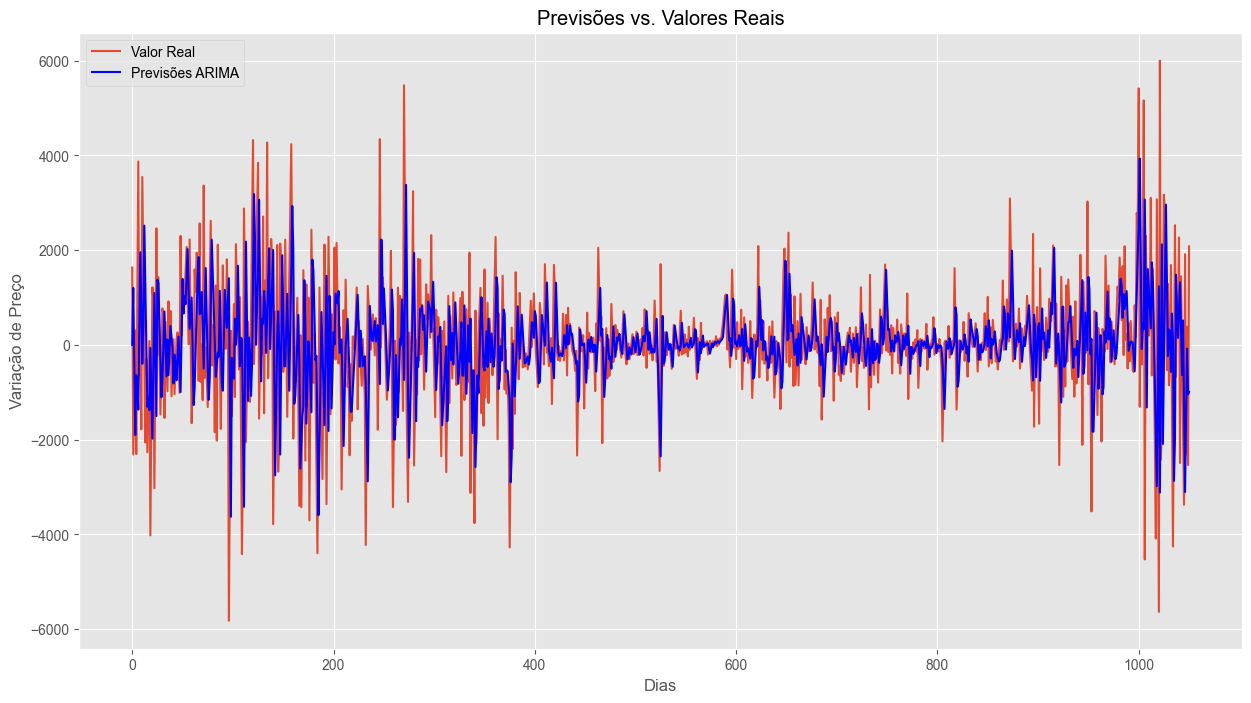

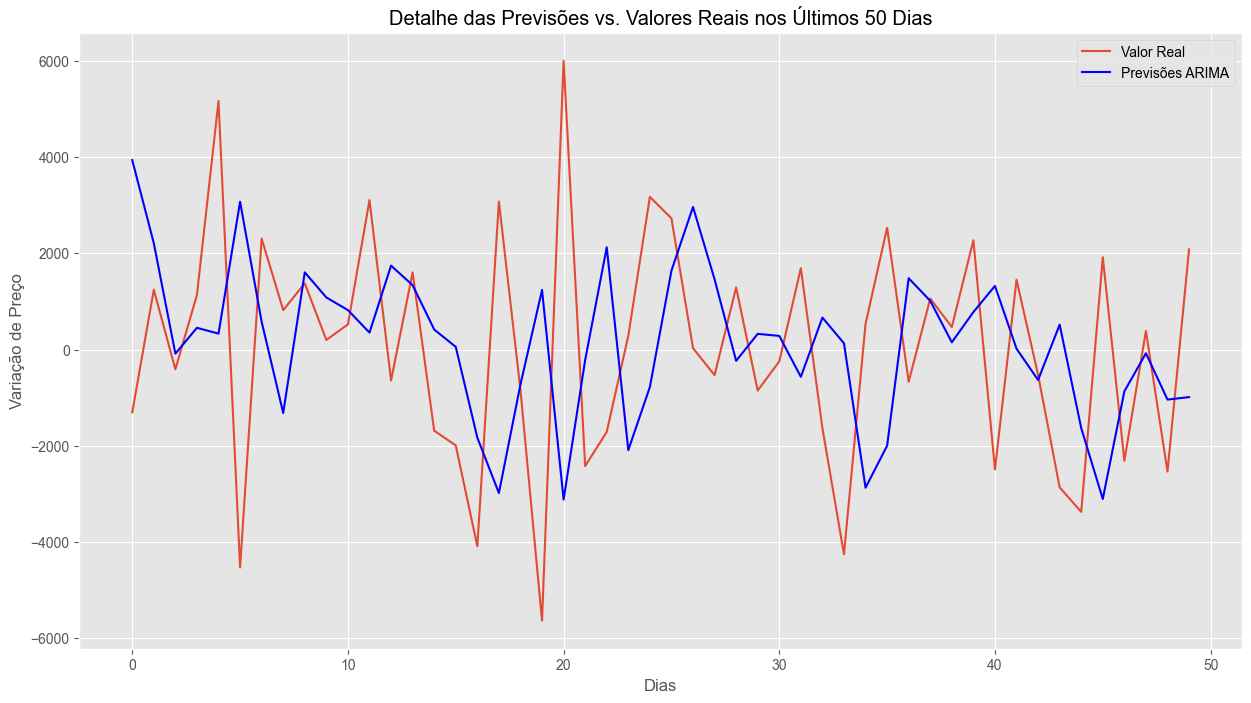

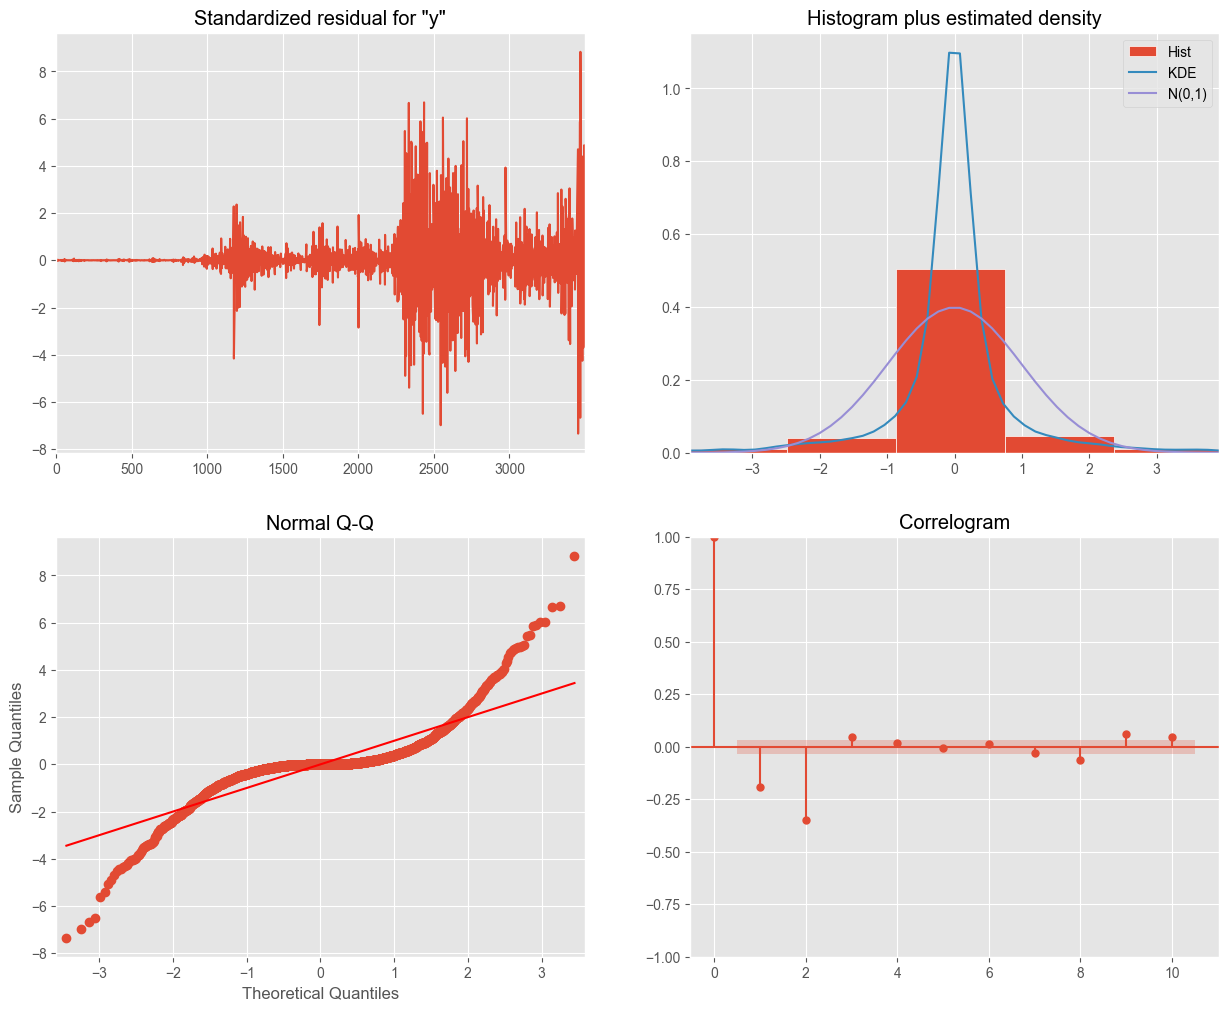

In [109]:
# Supondo que 'bitcoin_trat_df' já está carregado e contém a coluna 'Close_diff'
bitcoin_trat_df.sort_values('Date', inplace=True)
bitcoin_trat_df_clean = bitcoin_trat_df.dropna(subset=['Close_diff'])

# Seleção da variável de interesse e divisão dos dados
price = bitcoin_trat_df_clean['Close_diff'].values
size = int(len(price) * 0.7)
train, test = price[:size], price[size:]
history = list(train)

# Teste Dickey-Fuller Aumentado (ADF) para teste de random walk
result = adfuller(train)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


# Validação passo a passo com o modelo ARIMA
predictions = []
for t in range(len(test)):
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

# Avaliação das previsões
rmse = sqrt(mean_squared_error(test, predictions))
print(f'Test RMSE: {rmse}')

print(f'AIC:{model_fit.aic}')
print(model_fit.summary())

# Plotando os resultados incluindo o passeio aleatório
plt.figure(figsize=(15, 8))
plt.plot(test, label='Valor Real')
plt.plot(predictions, color='blue', label='Previsões ARIMA')

plt.xlabel('Dias')
plt.ylabel('Variação de Preço')
plt.title('Previsões vs. Valores Reais')
plt.legend()
plt.show()

# Plotar os últimos 50 dias para uma análise mais detalhada
plt.figure(figsize=(15, 8))
plt.plot(test[-50:], label='Valor Real')
plt.plot(predictions[-50:], color='blue', label='Previsões ARIMA')
plt.xlabel('Dias')
plt.ylabel('Variação de Preço')
plt.title('Detalhe das Previsões vs. Valores Reais nos Últimos 50 Dias')
plt.legend()
plt.show()

model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

### Segunda Versão do ARIMA (2,1,0)

In [110]:
# Supondo que 'bitcoin_trat_df' já está carregado e contém a coluna 'Close_diff'
bitcoin_trat_df.sort_values('Date', inplace=True)
bitcoin_trat_df_clean = bitcoin_trat_df.dropna(subset=['Close_diff'])

# Seleção da variável de interesse e divisão dos dados
price = bitcoin_trat_df_clean['Close_diff'].values
size = int(len(price) * 0.7)
train, test = price[:size], price[size:]
history = list(train)  

# Teste Dickey-Fuller Aumentado (ADF) para teste de random walk
result = adfuller(train)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


# Validação passo a passo com o modelo ARIMA
predictions = []
for t in range(len(test)):
    model = ARIMA(history, order=(2,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

# Avaliação das previsões
rmse = sqrt(mean_squared_error(test, predictions))
print(f'Test RMSE: {rmse}')

print(f'AIC:{model_fit.aic}')
print(model_fit.summary())

# Plotando os resultados incluindo o passeio aleatório
plt.figure(figsize=(15, 8))
plt.plot(test, label='Valor Real')
plt.plot(predictions, color='blue', label='Previsões ARIMA')
plt.xlabel('Dias')
plt.ylabel('Variação de Preço')
plt.title('Previsões vs. Valores Reais)
plt.legend()
plt.show()

# Plotar os últimos 50 dias para uma análise mais detalhada
plt.figure(figsize=(15, 8))
plt.plot(test[-50:], label='Valor Real')
plt.plot(predictions[-50:], color='blue', label='Previsões ARIMA')
plt.xlabel('Dias')
plt.ylabel('Variação de Preço')
plt.title('Detalhe das Previsões vs. Valores Reais nos Últimos 50 Dias')
plt.legend()
plt.show()

model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

SyntaxError: unterminated string literal (detected at line 44) (2872763295.py, line 44)

### Terceira Versão do ARIMA (3,1,0)

ADF Statistic: -6.523200
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Test RMSE: 1342.206445782257
AIC:57725.397154221544
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3500
Model:                 ARIMA(3, 1, 0)   Log Likelihood              -28858.699
Date:                Fri, 19 Apr 2024   AIC                          57725.397
Time:                        11:13:38   BIC                          57750.038
Sample:                             0   HQIC                         57734.191
                               - 3500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8204      0.007   -111.284      0.000      -

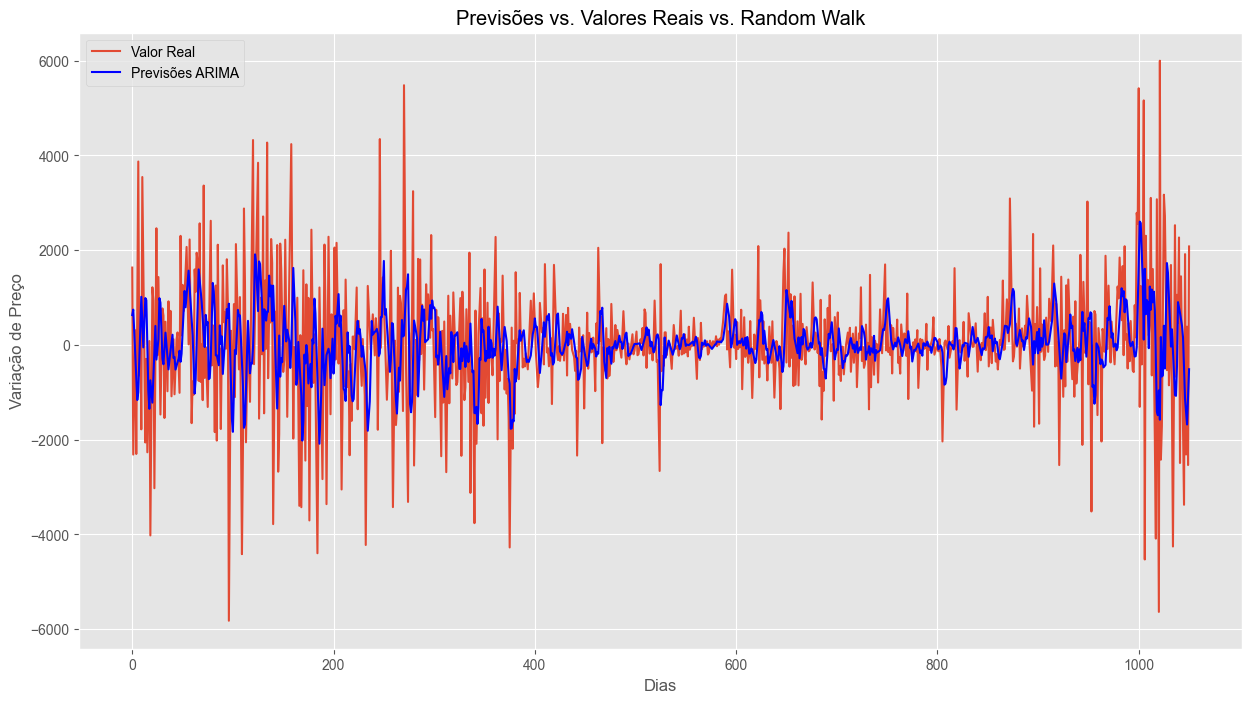

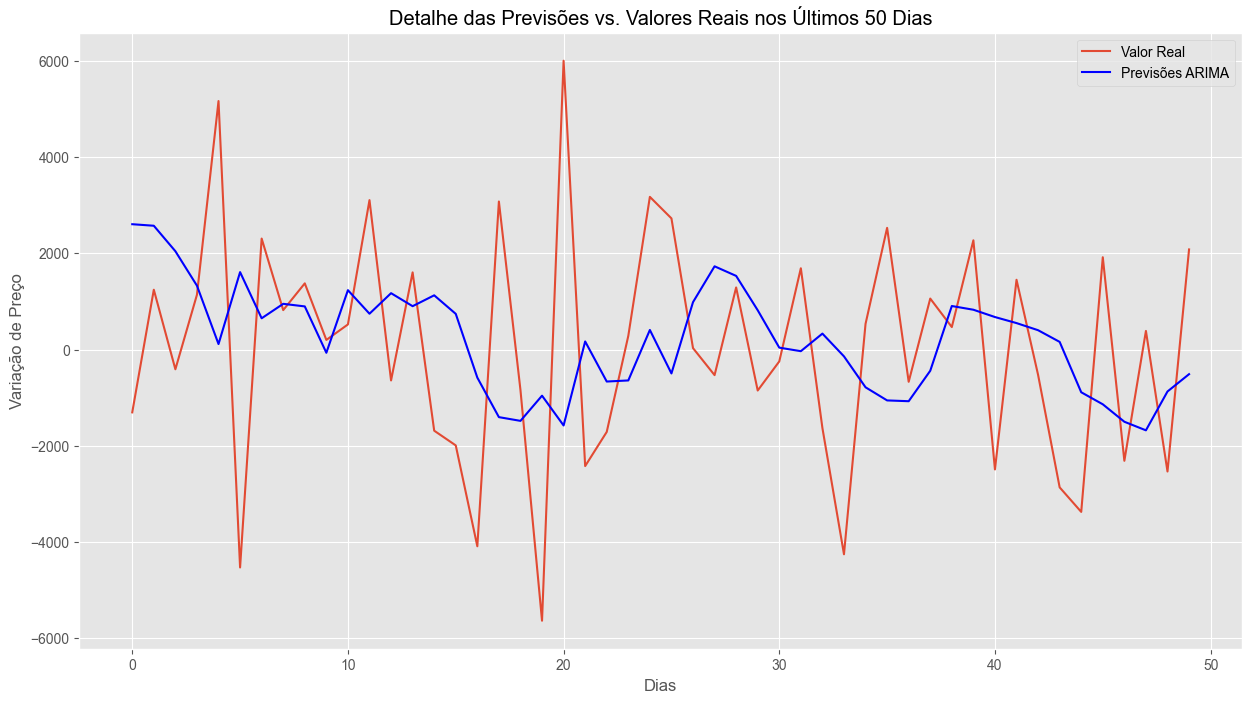

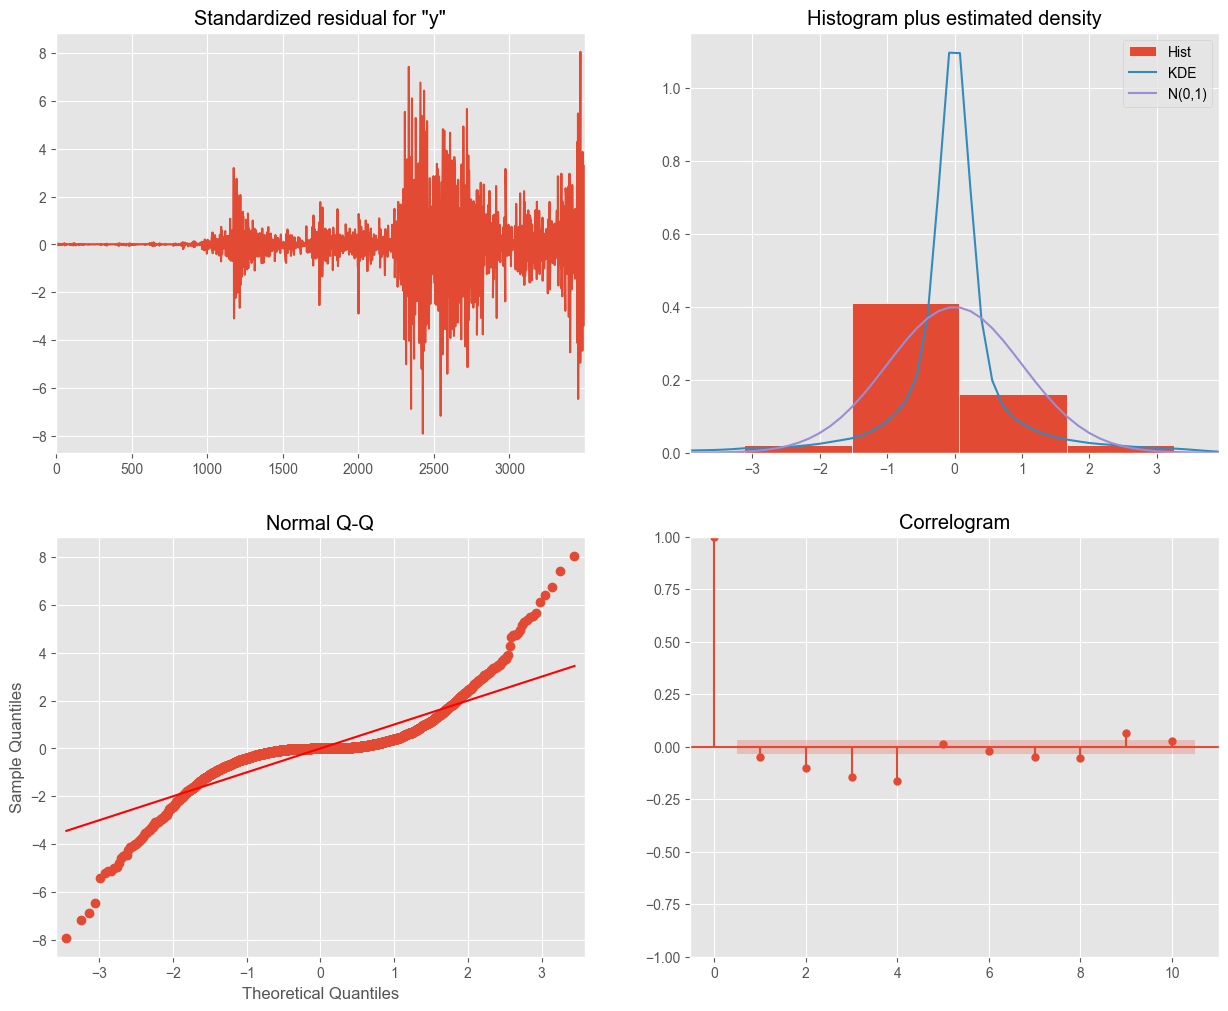

In [107]:
# Supondo que 'bitcoin_trat_df' já está carregado e contém a coluna 'Close_diff'
bitcoin_trat_df.sort_values('Date', inplace=True)
bitcoin_trat_df_clean = bitcoin_trat_df.dropna(subset=['Close_diff'])

# Seleção da variável de interesse e divisão dos dados
price = bitcoin_trat_df_clean['Close_diff'].values
size = int(len(price) * 0.7)
train, test = price[:size], price[size:]
history = list(train)  

# Teste Dickey-Fuller Aumentado (ADF) para teste de random walk
result = adfuller(train)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


# Validação passo a passo com o modelo ARIMA
predictions = []
for t in range(len(test)):
    model = ARIMA(history, order=(3,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

# Avaliação das previsões
rmse = sqrt(mean_squared_error(test, predictions))
print(f'Test RMSE: {rmse}')

print(f'AIC:{model_fit.aic}')
print(model_fit.summary())

# Plotando os resultados incluindo o passeio aleatório
plt.figure(figsize=(15, 8))
plt.plot(test, label='Valor Real')
plt.plot(predictions, color='blue', label='Previsões ARIMA')
plt.xlabel('Dias')
plt.ylabel('Variação de Preço')
plt.title('Previsões vs. Valores Reais vs. Random Walk')
plt.legend()
plt.show()

# Plotar os últimos 50 dias para uma análise mais detalhada
plt.figure(figsize=(15, 8))
plt.plot(test[-50:], label='Valor Real')
plt.plot(predictions[-50:], color='blue', label='Previsões ARIMA')
plt.xlabel('Dias')
plt.ylabel('Variação de Preço')
plt.title('Detalhe das Previsões vs. Valores Reais nos Últimos 50 Dias')
plt.legend()
plt.show()

model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

### Quarta Versão do ARIMA (5,1,0)

ADF Statistic: -6.523200
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
Test RMSE: 1308.897963786973
AIC:57514.28586717346
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3500
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -28751.143
Date:                Fri, 19 Apr 2024   AIC                          57514.286
Time:                        11:12:33   BIC                          57551.247
Sample:                             0   HQIC                         57527.477
                               - 3500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9004      0.008   -117.403      0.000      -0

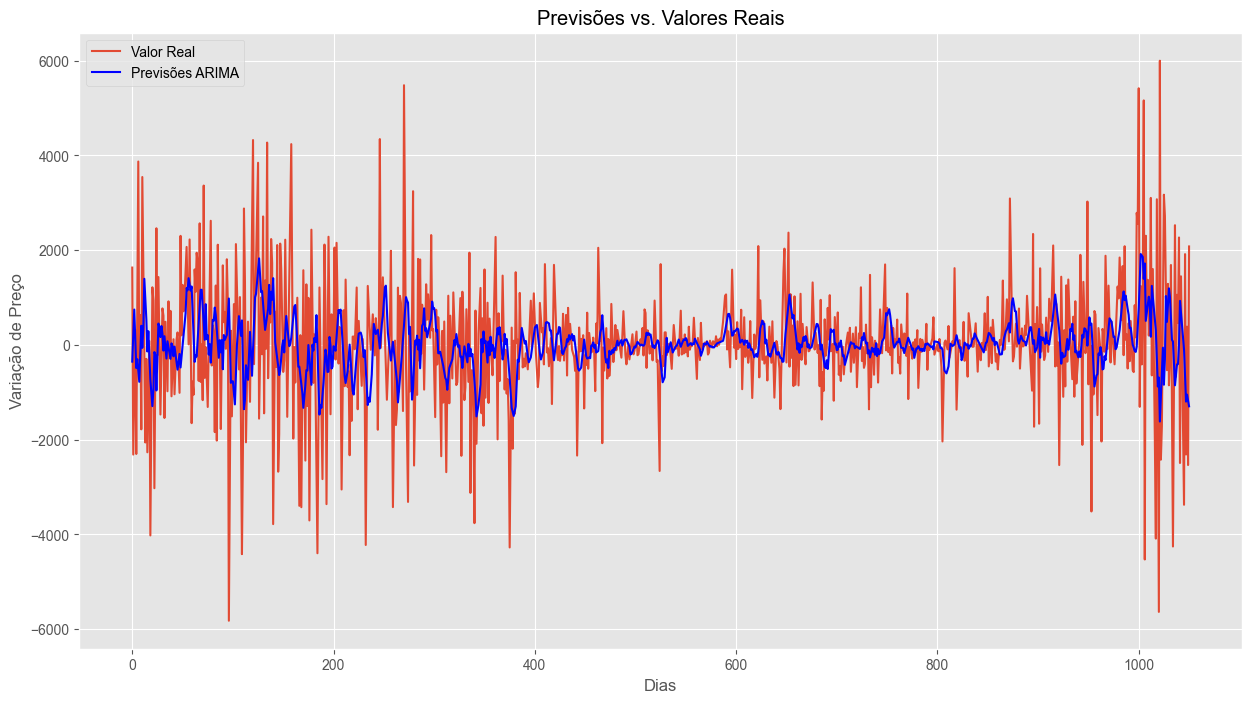

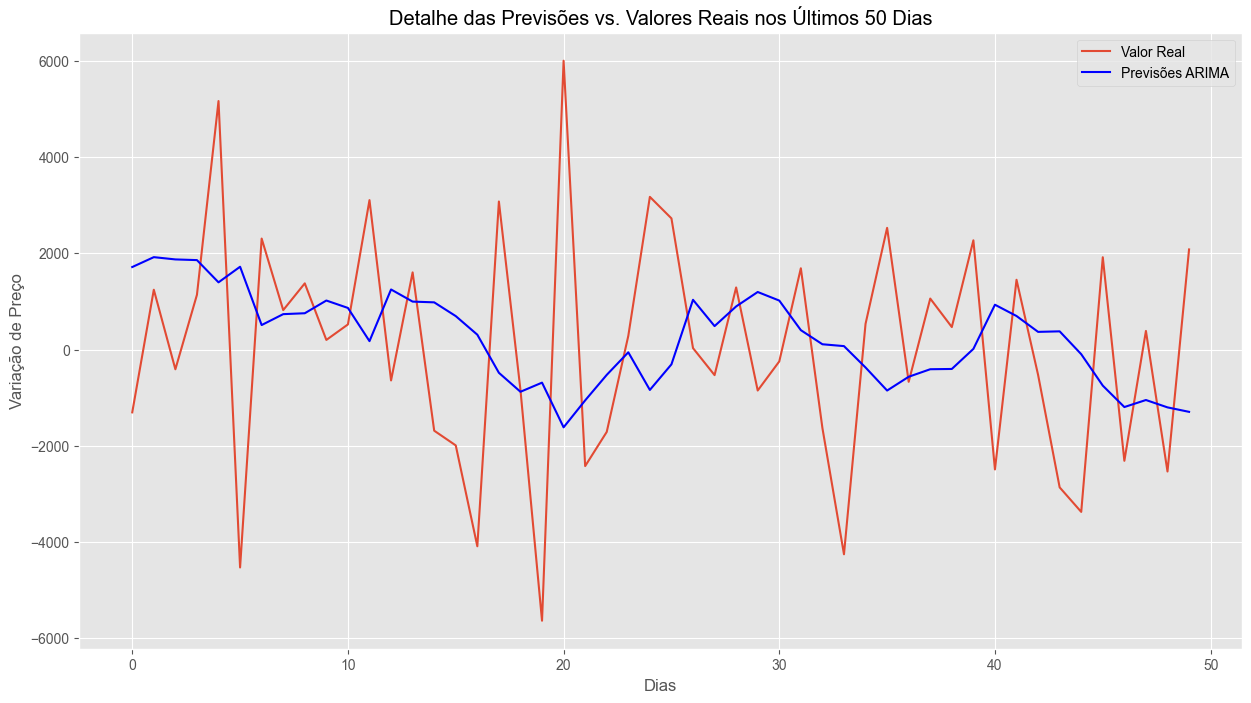

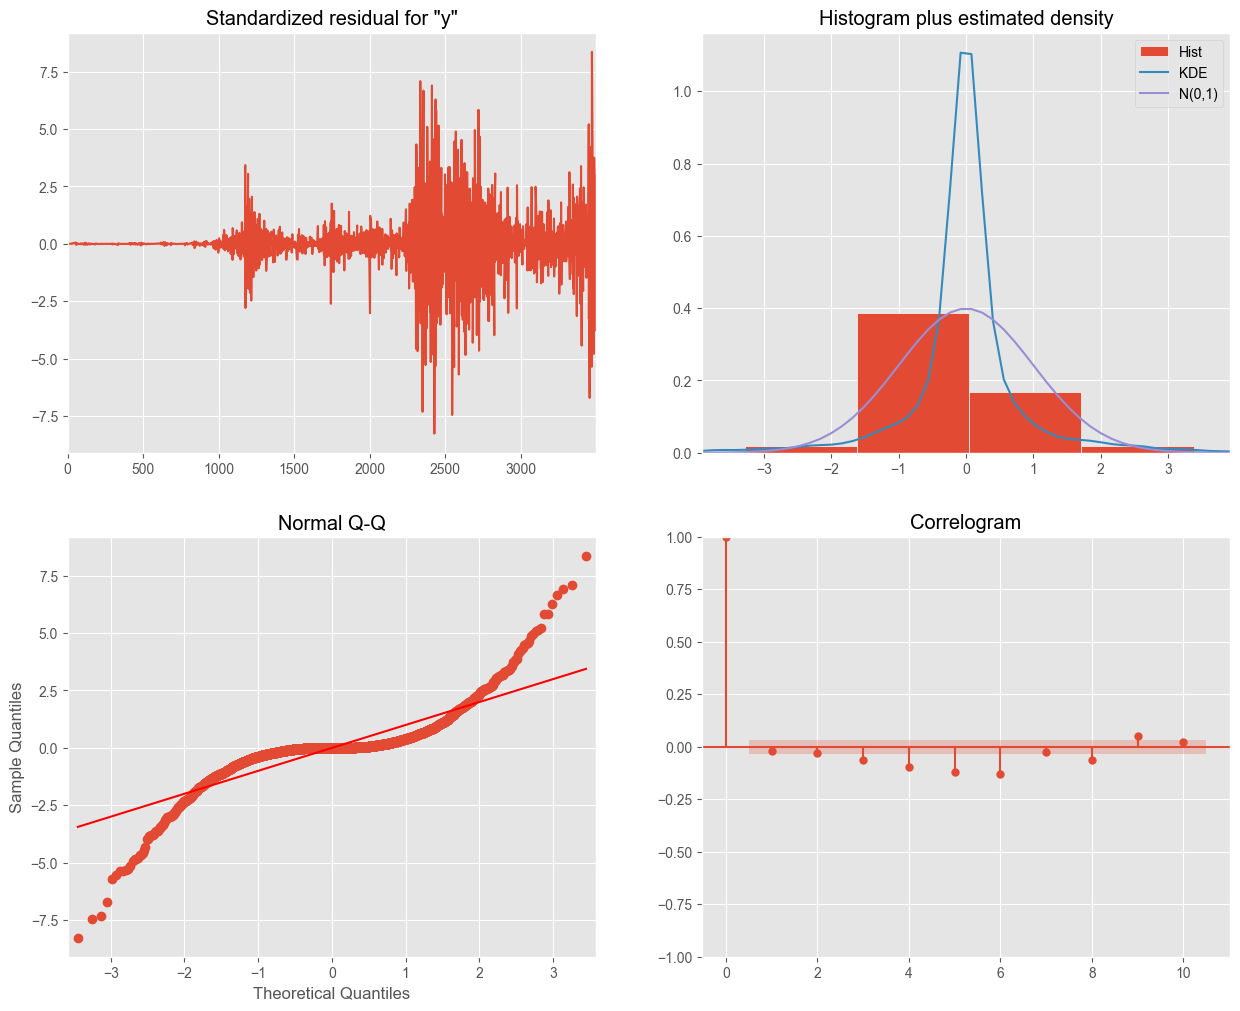

In [106]:
# Supondo que 'bitcoin_trat_df' já está carregado e contém a coluna 'Close_diff'
bitcoin_trat_df.sort_values('Date', inplace=True)
bitcoin_trat_df_clean = bitcoin_trat_df.dropna(subset=['Close_diff'])

# Seleção da variável de interesse e divisão dos dados
price = bitcoin_trat_df_clean['Close_diff'].values
size = int(len(price) * 0.7)
train, test = price[:size], price[size:]
history = list(train)  

# Teste Dickey-Fuller Aumentado (ADF) para teste de random walk
result = adfuller(train)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


# Validação passo a passo com o modelo ARIMA
predictions = []
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

# Avaliação das previsões
rmse = sqrt(mean_squared_error(test, predictions))
print(f'Test RMSE: {rmse}')

print(f'AIC:{model_fit.aic}')
print(model_fit.summary())

# Plotando os resultados incluindo o passeio aleatório
plt.figure(figsize=(15, 8))
plt.plot(test, label='Valor Real')
plt.plot(predictions, color='blue', label='Previsões ARIMA')
plt.xlabel('Dias')
plt.ylabel('Variação de Preço')
plt.title('Previsões vs. Valores Reais')
plt.legend()
plt.show()

# Plotar os últimos 50 dias para uma análise mais detalhada
plt.figure(figsize=(15, 8))
plt.plot(test[-50:], label='Valor Real')
plt.plot(predictions[-50:], color='blue', label='Previsões ARIMA')
plt.xlabel('Dias')
plt.ylabel('Variação de Preço')
plt.title('Detalhe das Previsões vs. Valores Reais nos Últimos 50 Dias')
plt.legend()
plt.show()

model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

### Auto ARIMAX

monthname
weekdayname
quarter
halving_btc
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=42830.006, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=42061.451, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=42828.007, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=41736.066, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=41544.350, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.95 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=41542.351, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=41734.066, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.62 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.38 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0]          
Total fit time: 3.664 seconds
   

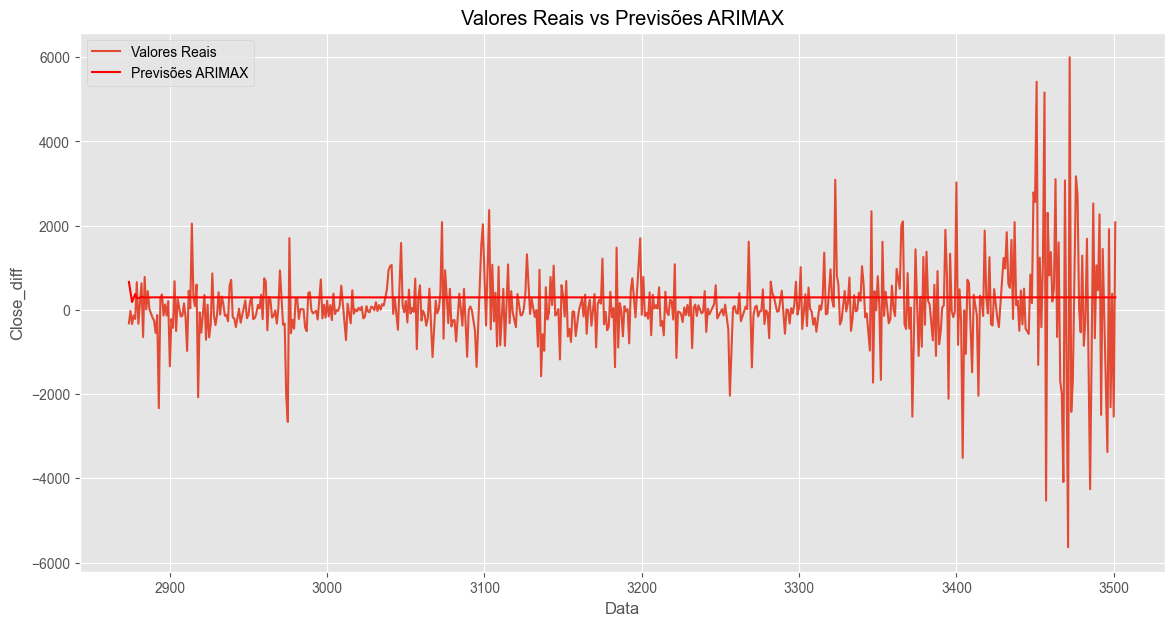

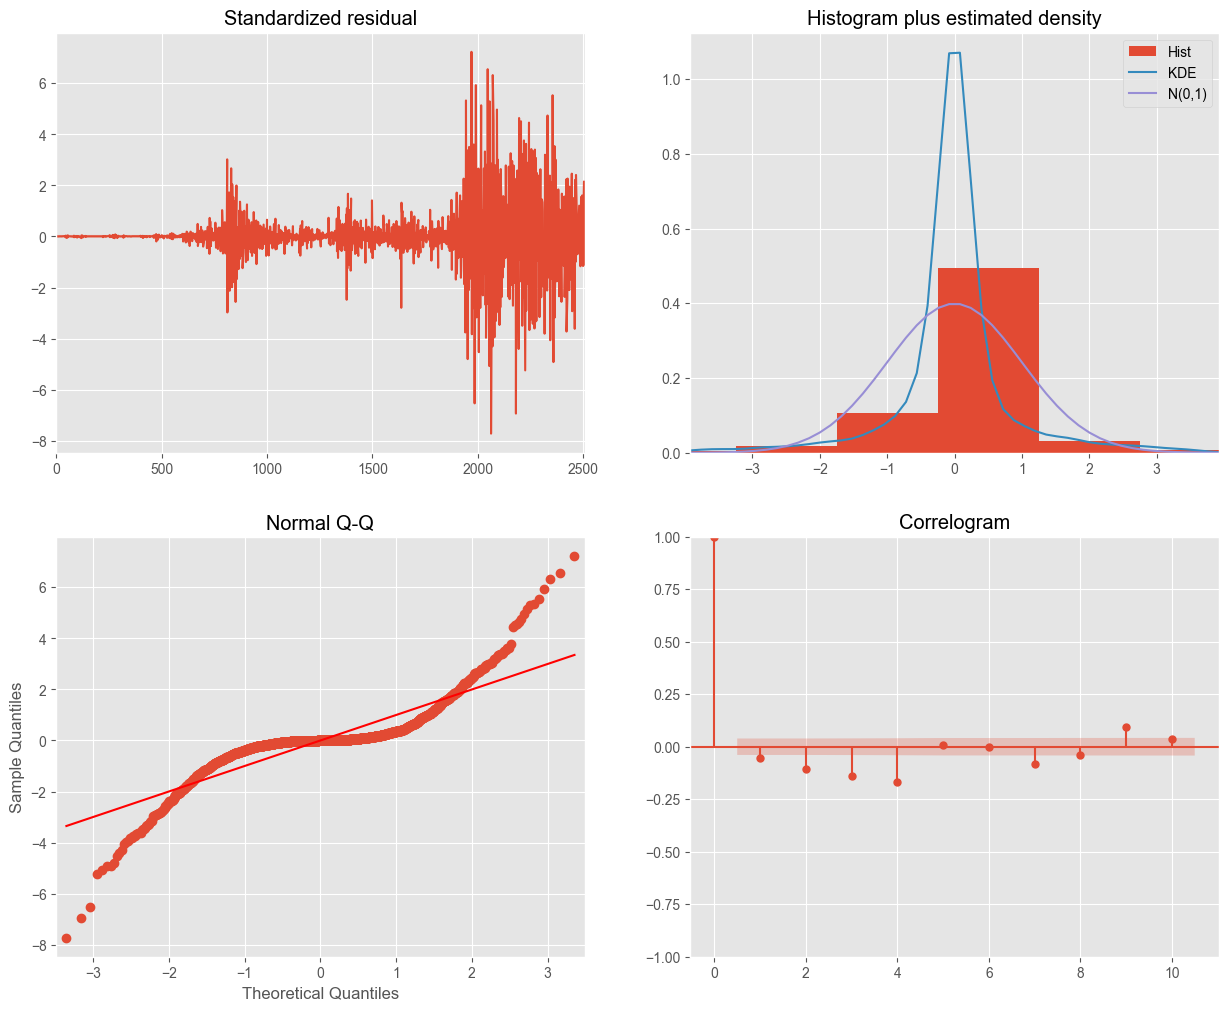

In [57]:
df = bitcoin_trat_df[['Lag_1_Open', 'Lag_1_High', 'Lag_1_Low', 'Lag_1_Volume', 'RSI', 'EMA_15', 'EMA_30', 'EMA_200', 'OBV', 
         'MA50', 'MA200', 'Lag_1_Volume', 'Lag_1_Volatility', 'Volatility_30', 'Volatility_90', 'Close_diff',
        'CCI', 'Lag_1', 'Lag_7', 'Lag_30', 'Lag_60', 'Lag_365','MonthName', 'WeekdayName', 'Quarter', 'halving_btc']]


list_dummies = ['MonthName', 'WeekdayName', 'Quarter', 'halving_btc']

diretorio = 'modelo/encoders'
# Salvando Encondings para predição do modelo
for column in list_dummies:
    enc = preprocessing.OneHotEncoder(handle_unknown='ignore')
    enc.fit(df[[column]])
    columns = df[column].unique()
    print(column.lower())

    # Salvando o encoder
    with open(os.path.join(diretorio, 'encoder_' + column.lower() + '.pkl'), 'wb') as file:
        pickle.dump(enc, file)

    # Salvando a lista de categorias
    with open(os.path.join(diretorio, 'list_' + column.lower() + '.pkl'), 'wb') as file:
        pickle.dump(columns, file)

# Transformando em dummies as variaveis categoricas
final_data = pd.DataFrame()

for column in list_dummies:
    enc_path = os.path.join(diretorio, 'encoder_' + column.lower() + '.pkl')
    encoder = load_pickle(enc_path)
    enc_df = get_one_hot_enc(feature_col=df[column], enc=encoder, column_name=column)
    final_data = pd.concat([final_data, enc_df], axis=1)

df_list = list(['Lag_1_Open', 'Lag_1_High', 'Lag_1_Low', 'Lag_1_Volume', 'RSI', 'EMA_15', 'EMA_30', 'EMA_200', 
               'OBV', 'MA50', 'MA200', 'Lag_1_Volume', 'Lag_1_Volatility', 'Volatility_30', 
               'Volatility_90','CCI', 'Lag_1', 'Lag_7', 'Lag_30', 'Lag_60', 'Lag_365', 'Close_diff'])

for i in df_list:
    final_data[f'{i}'] = bitcoin_trat_df[f'{i}'].values

# Selecionar colunas para o modelo ARIMAX
exogenous_columns = list(final_data.drop(columns = ["Close_diff"]).columns)

# Remover qualquer linha com NaN e selecionar colunas para o modelo
final_data.dropna(inplace=True)
exogenous_columns = final_data.columns.difference(['Close_diff'])

X = final_data[exogenous_columns]
y = final_data['Close_diff']

# Dividir os dados em conjuntos de treinamento e teste
train_size = int(len(y) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Treinar o modelo ARIMA com variáveis exógenas (sem componentes sazonais)
arimax_model = auto_arima(y_train, exogenous=X_train, start_p=1, start_q=1,
                           max_p=3, max_q=3, seasonal=False, d=1, trace=True,
                           error_action='ignore', suppress_warnings=True, stepwise=True)

# Imprimir o sumário do modelo
print(arimax_model.summary())

# Realizar previsões
predictions_arimax = arimax_model.predict(n_periods=len(y_test), exogenous=X_test)
mse_arimax = mean_squared_error(y_test, predictions_arimax)
print(f'MSE do modelo ARIMAX: {mse_arimax}')

## Modelo de espaço de estados (SARIMA)

### Auto Sarima

In [68]:
# Ordenar os dados pela data
bitcoin_trat_df.sort_values('Date', inplace=True)
bitcoin_trat_df_clean = bitcoin_trat_df.dropna()

# Selecionar a variável de interesse
y = bitcoin_trat_df_clean['Close_diff']

# Dividir os dados em conjuntos de treinamento e teste
train_size = int(len(y) * 0.8)
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Utilizar auto_arima para encontrar os melhores parâmetros p, d, q e P, D, Q
model = auto_arima(y_train, start_p=0, start_q=0, max_p=3, max_q=3,
                   start_P=0, start_Q=0, max_P=1, max_Q=1,
                   seasonal=True, m=12, d=1, D=1, trace=True,
                   error_action='ignore',  
                   suppress_warnings=True, 
                   stepwise=True)

# Imprimir o sumário do melhor modelo SARIMA encontrado
print(model.summary())

# Realizar previsões
predictions_sarima = model.predict(n_periods=len(y_test))
predictions_sarima = pd.Series(predictions_sarima, index=y_test.index)

# Calcular métricas de erro
mse_sarima = mean_squared_error(y_test, predictions_sarima)
print(f'MSE do modelo SARIMA: {mse_sarima}')

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=44562.349, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=42821.116, Time=1.65 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.19 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=43787.829, Time=0.11 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.26 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=1.64 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=43519.121, Time=0.30 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=42512.622, Time=2.32 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=43493.042, Time=0.16 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=3.23 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=inf, Time=2.28 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=42342.703, Time=2.79 sec
 ARIMA(3,1,0)(0,1,0)[12]             : AIC=43242.820, Time=0.18 sec
 ARIMA(3,1,0)(1,1,1)[12]             : AIC=inf, Time=4.33 sec
 ARIMA(3,1,0)(0,1,1)[12]             : AI

### Primeira Versão do SARIMA (Sem refit) (3, 1, 0)(1, 1, 0, 12)

In [59]:
# Ordenar os dados pela data
bitcoin_trat_df.sort_values('Date', inplace=True)
bitcoin_trat_df_clean = bitcoin_trat_df.dropna()

# Selecionar a variável de interesse
y = bitcoin_trat_df_clean['Close_diff']

# Dividir os dados em conjuntos de treinamento e teste
train_size = int(len(y) * 0.8)
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]


# Parâmetros fixos para o modelo SARIMA
order = (3, 1, 0)
seasonal_order = (1, 1, 0, 12)

# Treinar o modelo uma única vez com todo o conjunto de treinamento
model = SARIMAX(y_train,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False)
model_fit = model.fit(disp=0)

warnings.filterwarnings("ignore")
# Realizar previsões passo a passo
predictions = []
history = list(y_train)  # Histórico inicial com o conjunto de treinamento
for t in range(len(y_test)):
    output = model_fit.forecast(steps=1)  # Previsão de 1 passo à frente
    yhat = output[0]
    predictions.append(yhat)
    obs = y_test.iloc[t]
    history.append(obs)  # Atualizar histórico com a observação real
    model_fit = model_fit.append([obs], refit=False)  # Atualizar modelo com novos dados sem retreinar, passando uma lista


In [ ]:
#                                      SARIMAX Results                                      
# ==========================================================================================
# Dep. Variable:                         Close_diff   No. Observations:                 3137
# Model:             SARIMAX(3, 1, 0)x(1, 1, 0, 12)   Log Likelihood              -26440.225
# Date:                            Thu, 18 Apr 2024   AIC                          52890.451
# Time:                                    16:46:09   BIC                          52920.661
# Sample:                                09-17-2015   HQIC                         52901.297
#                                      - 04-18-2024                                         
# Covariance Type:                              opg                                         
# ==============================================================================
#                 coef    std err          z      P>|z|      [0.025      0.975]
# ------------------------------------------------------------------------------
# ar.L1         -0.7538      0.010    -75.191      0.000      -0.773      -0.734
# ar.L2         -0.5144      0.011    -45.423      0.000      -0.537      -0.492
# ar.L3         -0.2591      0.010    -26.467      0.000      -0.278      -0.240
# ar.S.L12      -0.5546      0.008    -73.763      0.000      -0.569      -0.540
# sigma2      1.366e+06   1.57e+04     86.940      0.000    1.34e+06     1.4e+06
# ===================================================================================
# Ljung-Box (L1) (Q):                  32.10   Jarque-Bera (JB):             12674.57
# Prob(Q):                              0.00   Prob(JB):                         0.00
# Heteroskedasticity (H):              11.58   Skew:                             0.40
# Prob(H) (two-sided):                  0.00   Kurtosis:                        12.86
# ===================================================================================

Test RMSE: 1288.3393255370277
AIC:52890.45060732022


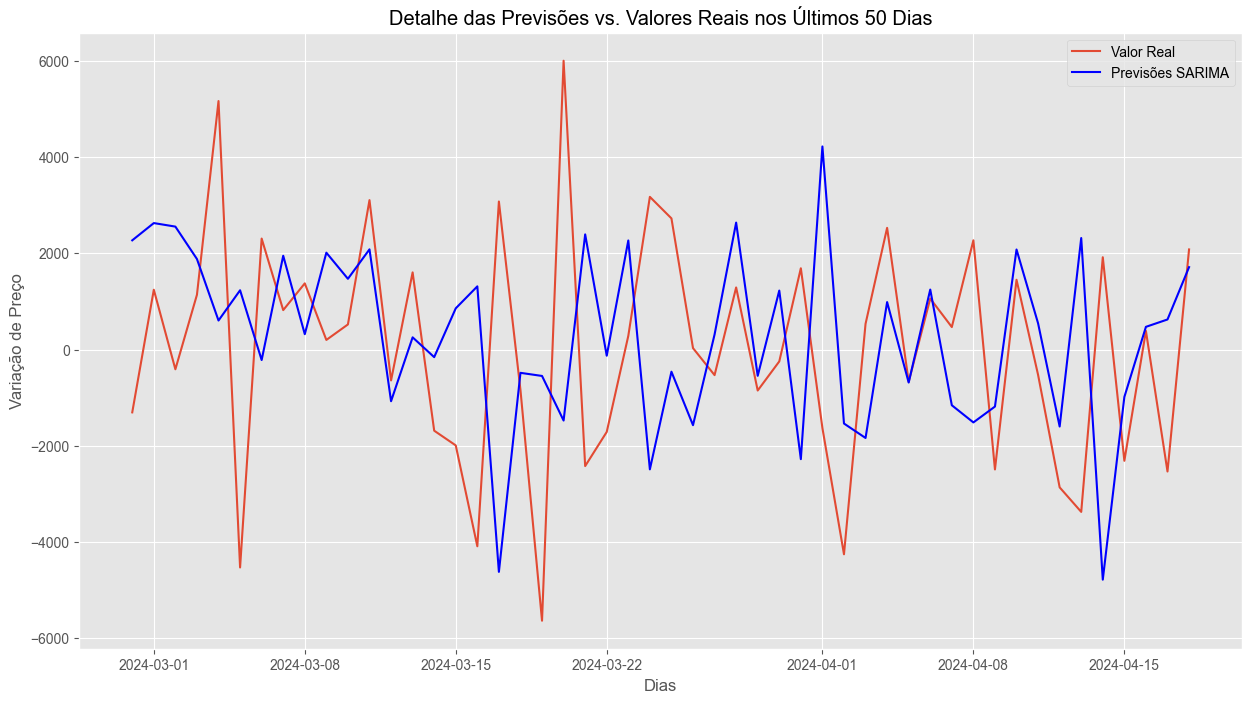

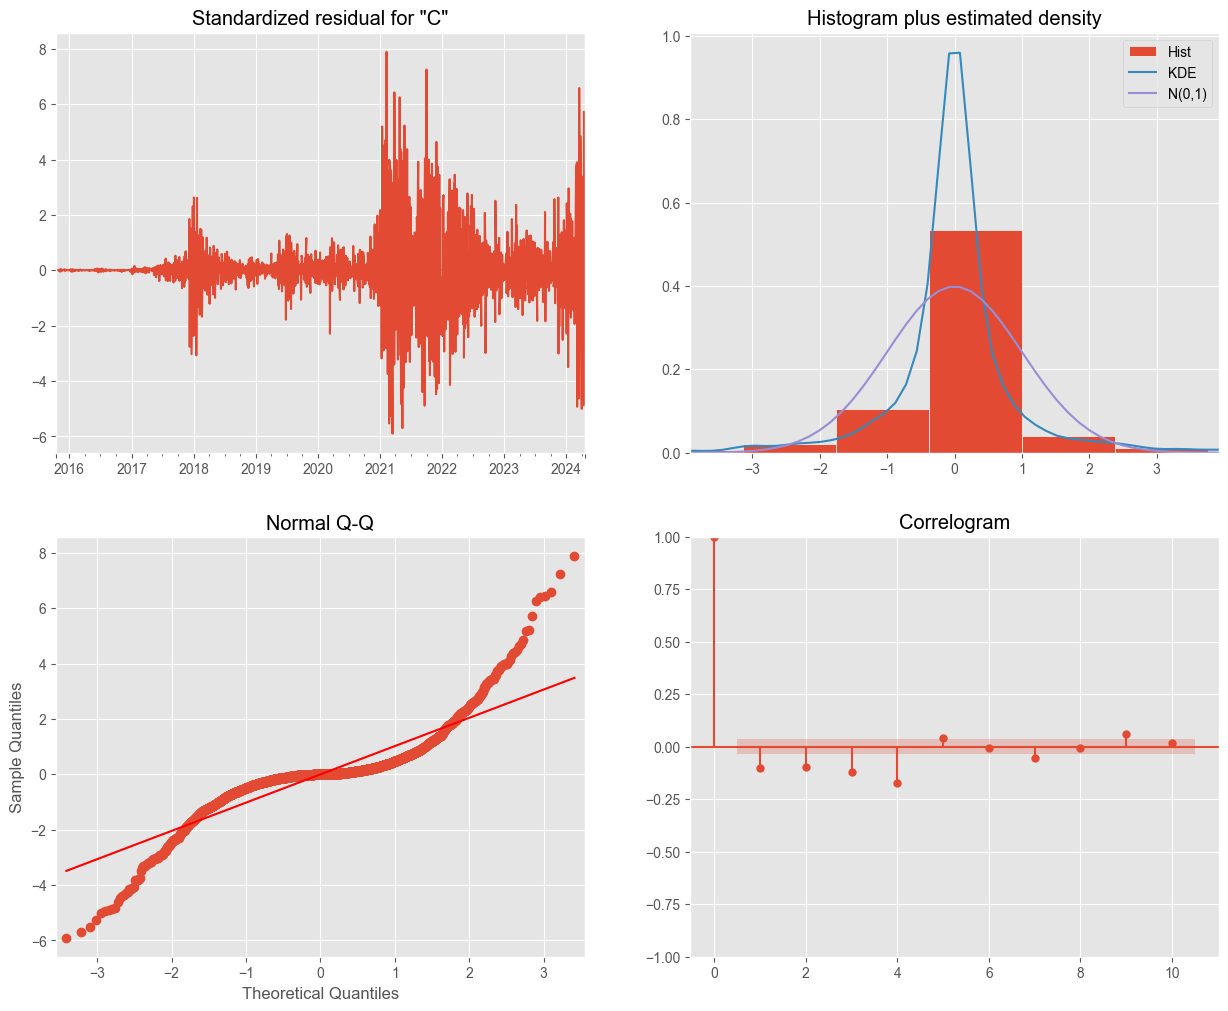

In [61]:
# Avaliação das previsões
rmse = sqrt(mean_squared_error(y_test, predictions))
print(f'Test RMSE: {rmse}')
print(f'AIC:{model_fit.aic}')


# Plotar os últimos 50 dias para uma análise mais detalhada
plt.figure(figsize=(15, 8))
plt.plot(y_test.index[-50:], y_test[-50:], label='Valor Real')
plt.plot(y_test.index[-50:], predictions[-50:], color='blue', label='Previsões SARIMA')
plt.xlabel('Dias')
plt.ylabel('Variação de Preço')
plt.title('Detalhe das Previsões vs. Valores Reais nos Últimos 50 Dias')
plt.legend()
plt.show()

# Diagnóstico do modelo
model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

### Segunda versão do SARIMA (Com refit)

Test RMSE: 1287.113211155452
AIC:52882.54391133094
                                     SARIMAX Results                                      
Dep. Variable:                         Close_diff   No. Observations:                 3137
Model:             SARIMAX(3, 1, 0)x(1, 1, 0, 12)   Log Likelihood              -26436.272
Date:                            Thu, 18 Apr 2024   AIC                          52882.544
Time:                                    16:53:52   BIC                          52912.754
Sample:                                09-17-2015   HQIC                         52893.391
                                     - 04-18-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7977      0.008    -95.915      0.000      -0.

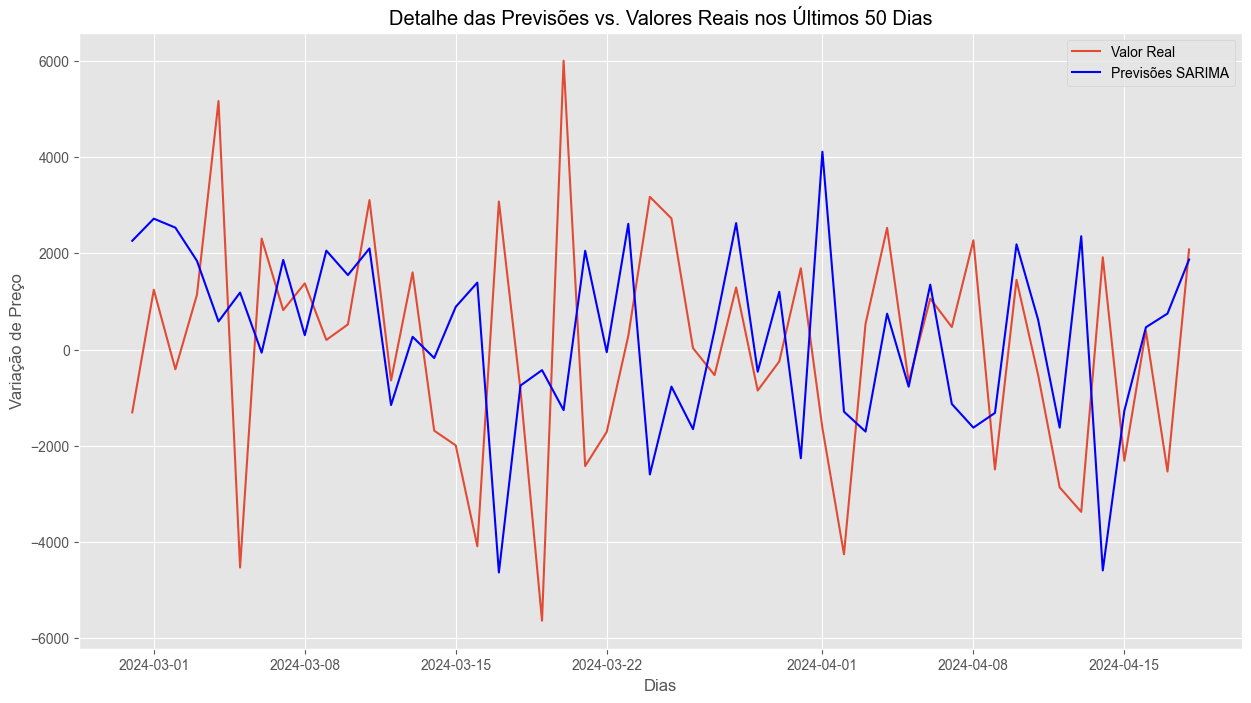

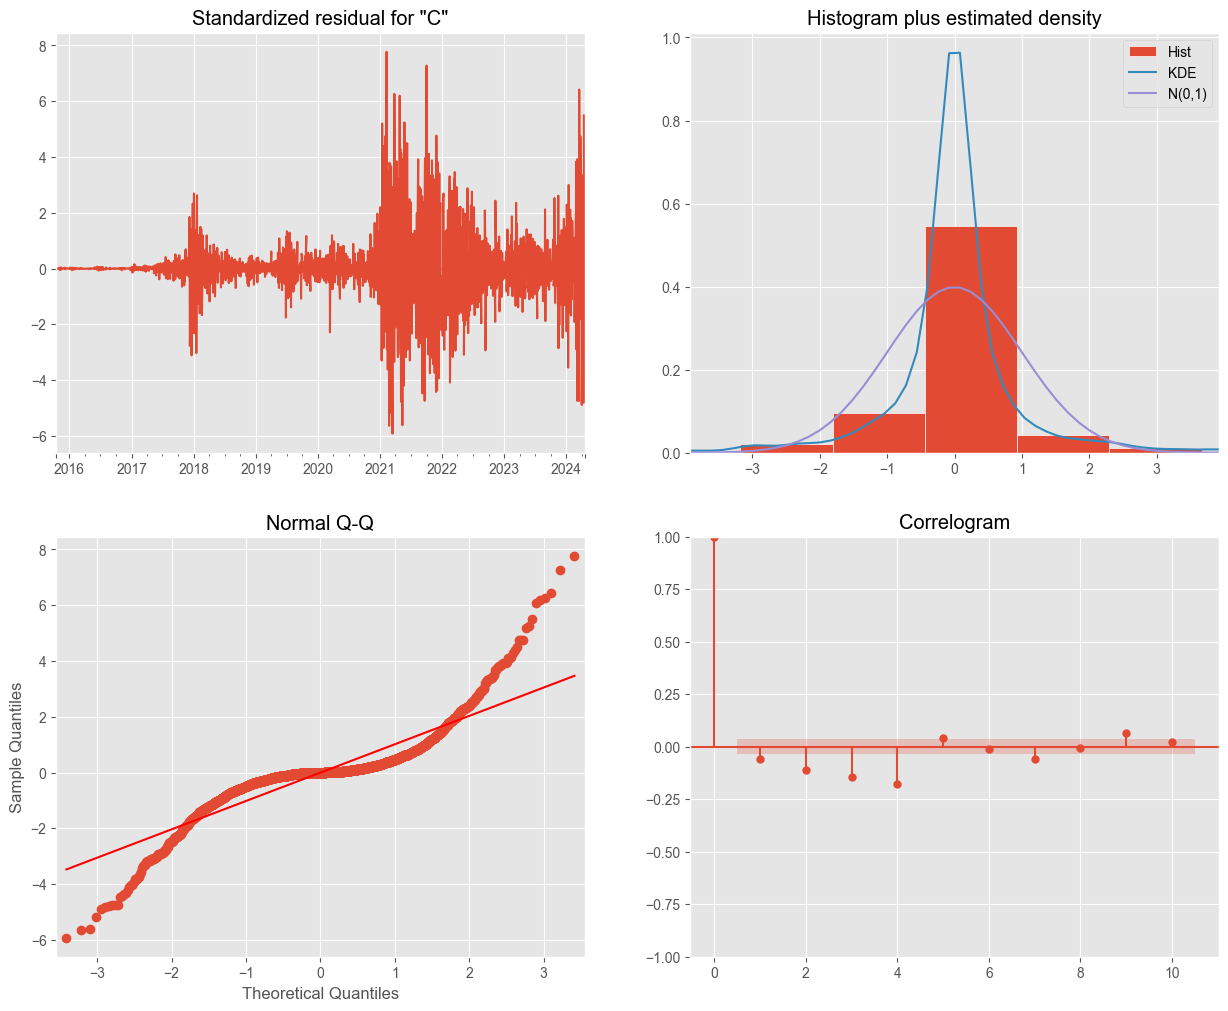

In [62]:
# Ordenar os dados pela data
bitcoin_trat_df.sort_values('Date', inplace=True)
bitcoin_trat_df_clean = bitcoin_trat_df.dropna()

# Selecionar a variável de interesse
y = bitcoin_trat_df_clean['Close_diff']

# Dividir os dados em conjuntos de treinamento e teste
train_size = int(len(y) * 0.8)
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]


# Parâmetros fixos para o modelo SARIMA
order = (3, 1, 0)
seasonal_order = (1, 1, 0, 12)

# Treinar o modelo uma única vez com todo o conjunto de treinamento
model = SARIMAX(y_train,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False)
model_fit = model.fit(disp=0)

warnings.filterwarnings("ignore")
# Realizar previsões passo a passo
predictions = []
history = list(y_train)  # Histórico inicial com o conjunto de treinamento
for t in range(len(y_test)):
    output = model_fit.forecast(steps=1)  # Previsão de 1 passo à frente
    yhat = output[0]
    predictions.append(yhat)
    obs = y_test.iloc[t]
    history.append(obs)  # Atualizar histórico com a observação real
    model_fit = model_fit.append([obs], refit=True)  # Atualizar modelo com novos dados sem retreinar, passando uma lista

# Avaliação das previsões
rmse = sqrt(mean_squared_error(y_test, predictions))
print(f'Test RMSE: {rmse}')
print(f'AIC:{model_fit.aic}')
print(model_fit.summary())

# Plotar os últimos 50 dias para uma análise mais detalhada
plt.figure(figsize=(15, 8))
plt.plot(y_test.index[-50:], y_test[-50:], label='Valor Real')
plt.plot(y_test.index[-50:], predictions[-50:], color='blue', label='Previsões SARIMA')
plt.xlabel('Dias')
plt.ylabel('Variação de Preço')
plt.title('Detalhe das Previsões vs. Valores Reais nos Últimos 50 Dias')
plt.legend()
plt.show()

# Diagnóstico do modelo
model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

### Auto SARIMAX

In [74]:
df = bitcoin_trat_df[['Lag_1_Open', 'Lag_1_High', 'Lag_1_Low', 'Lag_1_Volume', 'RSI', 'EMA_15', 'EMA_30', 'EMA_200', 'OBV', 
         'MA50', 'MA200', 'Lag_1_Volume', 'Lag_1_Volatility', 'Volatility_30', 'Volatility_90', 'Close_diff',
        'CCI', 'Lag_1', 'Lag_7', 'Lag_30', 'Lag_60', 'Lag_365','MonthName', 'WeekdayName', 'Quarter', 'halving_btc']]


list_dummies = ['MonthName', 'WeekdayName', 'Quarter', 'halving_btc']

diretorio = 'modelo/encoders'
# Salvando Encondings para predição do modelo
for column in list_dummies:
    enc = preprocessing.OneHotEncoder(handle_unknown='ignore')
    enc.fit(df[[column]])
    columns = df[column].unique()
    print(column.lower())

    # Salvando o encoder
    with open(os.path.join(diretorio, 'encoder_' + column.lower() + '.pkl'), 'wb') as file:
        pickle.dump(enc, file)

    # Salvando a lista de categorias
    with open(os.path.join(diretorio, 'list_' + column.lower() + '.pkl'), 'wb') as file:
        pickle.dump(columns, file)

# Transformando em dummies as variaveis categoricas
final_data = pd.DataFrame()

for column in list_dummies:
    enc_path = os.path.join(diretorio, 'encoder_' + column.lower() + '.pkl')
    encoder = load_pickle(enc_path)
    enc_df = get_one_hot_enc(feature_col=df[column], enc=encoder, column_name=column)
    final_data = pd.concat([final_data, enc_df], axis=1)

df_list = list(['Lag_1_Open', 'Lag_1_High', 'Lag_1_Low', 'Lag_1_Volume', 'RSI', 'EMA_15', 'EMA_30', 'EMA_200', 
               'OBV', 'MA50', 'MA200', 'Lag_1_Volume', 'Lag_1_Volatility', 'Volatility_30', 
               'Volatility_90','CCI', 'Lag_1', 'Lag_7', 'Lag_30', 'Lag_60', 'Lag_365', 'Close_diff'])

for i in df_list:
    final_data[f'{i}'] = bitcoin_trat_df[f'{i}'].values

# Selecionar colunas para o modelo ARIMAX
exogenous_columns = list(final_data.drop(columns = ["Close_diff"]).columns)

# Remover qualquer linha com NaN e selecionar colunas para o modelo
final_data.dropna(inplace=True)
exogenous_columns = final_data.columns.difference(['Close_diff'])

X = final_data[exogenous_columns]
y = final_data['Close_diff']

# Dividir os dados em conjuntos de treinamento e teste
train_size = int(len(y) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Treinar o modelo SARIMA com variáveis exógenas
sarimax_model = auto_arima(y_train, exogenous=X_train, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12, seasonal=True, d=1, D=1, trace=True,
                           error_action='ignore', suppress_warnings=True, stepwise=True)

# Imprimir o sumário do modelo
print(sarimax_model.summary())

# Realizar previsões
predictions_sarimax = sarimax_model.predict(n_periods=len(y_test), exogenous=X_test)
mse_sarimax = mean_squared_error(y_test, predictions_sarimax)
print(f'MSE do modelo SARIMAX: {mse_sarimax}')

monthname
weekdayname
quarter
halving_btc
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=4.13 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=44562.349, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=42821.116, Time=1.65 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.19 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=43787.829, Time=0.11 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=42603.699, Time=5.75 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=8.51 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.25 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=43344.615, Time=1.82 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=42307.526, Time=7.70 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=42512.622, Time=2.31 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=10.92 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=3.20 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=42122.305, Time=8.32 se

## Modelo XGboost (OVERFITTING)

In [101]:
df = bitcoin_trat_df[['Lag_1_Open', 'Lag_1_High', 'Lag_1_Low', 'Lag_1_Volume', 'RSI', 'EMA_15', 'EMA_30', 'EMA_200', 'OBV', 
         'MA50', 'MA200', 'Lag_1_Volume', 'Lag_1_Volatility', 'Volatility_30', 'Volatility_90', 'Close',
        'CCI',  'Lag_7', 'Lag_30', 'Lag_60', 'Lag_365','MonthName', 'WeekdayName', 'Quarter', 'halving_btc']]


list_dummies = ['MonthName', 'WeekdayName', 'Quarter', 'halving_btc']

if not os.path.exists('modelo/encoders'):
    os.makedirs('modelo/encoders')

diretorio = 'modelo/encoders'
# Salvando Encondings para predição do modelo
for column in list_dummies:
    enc = preprocessing.OneHotEncoder(handle_unknown='ignore')
    enc.fit(df[[column]])
    columns = df[column].unique()
    print(column.lower())

    # Salvando o encoder
    with open(os.path.join(diretorio, 'encoder_' + column.lower() + '.pkl'), 'wb') as file:
        pickle.dump(enc, file)

    # Salvando a lista de categorias
    with open(os.path.join(diretorio, 'list_' + column.lower() + '.pkl'), 'wb') as file:
        pickle.dump(columns, file)

# Transformando em dummies as variaveis categoricas
final_data = pd.DataFrame()

for column in list_dummies:
    enc_path = os.path.join(diretorio, 'encoder_' + column.lower() + '.pkl')
    encoder = load_pickle(enc_path)
    enc_df = get_one_hot_enc(feature_col=df[column], enc=encoder, column_name=column)
    final_data = pd.concat([final_data, enc_df], axis=1)

df_list = list(['Lag_1_Volume', 'RSI', 
               'Volatility_30', 
               'Volatility_90','CCI','Lag_365', 'Close'])

for i in df_list:
    final_data[f'{i}'] = bitcoin_trat_df[f'{i}'].values

# Selecionar colunas para o modelo ARIMAX
exogenous_columns = list(final_data.drop(columns = ["Close"]).columns)

# Remover qualquer linha com NaN
final_data = final_data.dropna()

# Seleção das features(variaveis) preditoras
dt_ax = final_data.drop(columns = ["Close"])

# Seleção da variavel a ser predita a probabilidade
dt_ay = final_data[['Close']].copy()

#normalização dos dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(dt_ax)
X_scaled_df = pd.DataFrame(X_scaled, columns=dt_ax.columns)

# Segmentação em Treino (75%) e Teste (25%)
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, dt_ay, random_state=13, test_size=0.25)

# Executando a otimização
trials = Trials()
best_hyperparams = fmin(fn=hipertuning, 
                        space=space, 
                        algo=tpe.suggest, 
                        max_evals=5, 
                        trials=trials)

# Obtendo os melhores hiperparâmetros
best_hyperparams = space_eval(space, best_hyperparams)
print("Melhores hiperparâmetros:", best_hyperparams)

# Melhores Parametros
print("Melhor min_child_weight:", best_hyperparams['min_child_weight'])
print("Melhor Max_Depth:", best_hyperparams['max_depth'])
print("Melhor gamma:", best_hyperparams['gamma'])
print("Melhor reg_lambda:", best_hyperparams['reg_lambda'])
print("Melhor reg_alpha:", best_hyperparams['reg_alpha'])
print("Melhor colsample_bytree:", best_hyperparams['colsample_bytree'])

monthname
weekdayname
quarter
halving_btc
Média MSE:                                                                                                             
11767168.606336985                                                                                                     
Média MSE:                                                                                                             
8682561.471455708                                                                                                      
Média MSE:                                                                                                             
8891049.8056278                                                                                                        
Média MSE:                                                                                                             
8277418.29514004                                                                                                      

R-squared:  0.9833503354562427
Shapiro-Wilk Test Statistic (residuals) 0.7930064797401428, p-value: 2.0012924858907698e-30
Valores do Teste de Breusch-Pagan: {'LM Statistic': 68.92539953742863, 'LM-Test p-value': 0.00024575129540912614, 'F-Statistic': 2.8061887586970826, 'F-Test p-value': 5.155239204342506e-06}
Skewness of residuals:  1.2075660996415079
Kurtosis of residuals:  11.639133609375609
Durbin-Watson:  1.9532628839918946
AIC: 7097.880502881061
MSE: 5141177.201048975
MAE: 1225.0781254276349
RMSE: 2267.416415449305


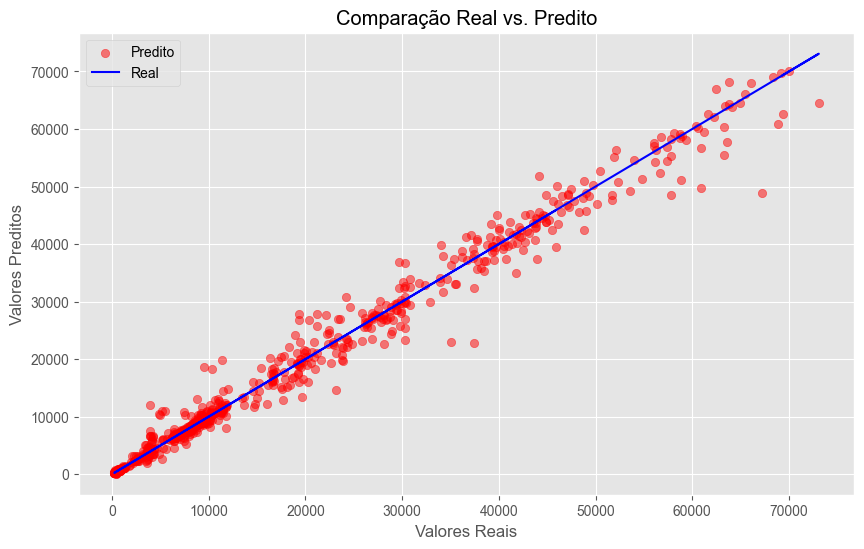

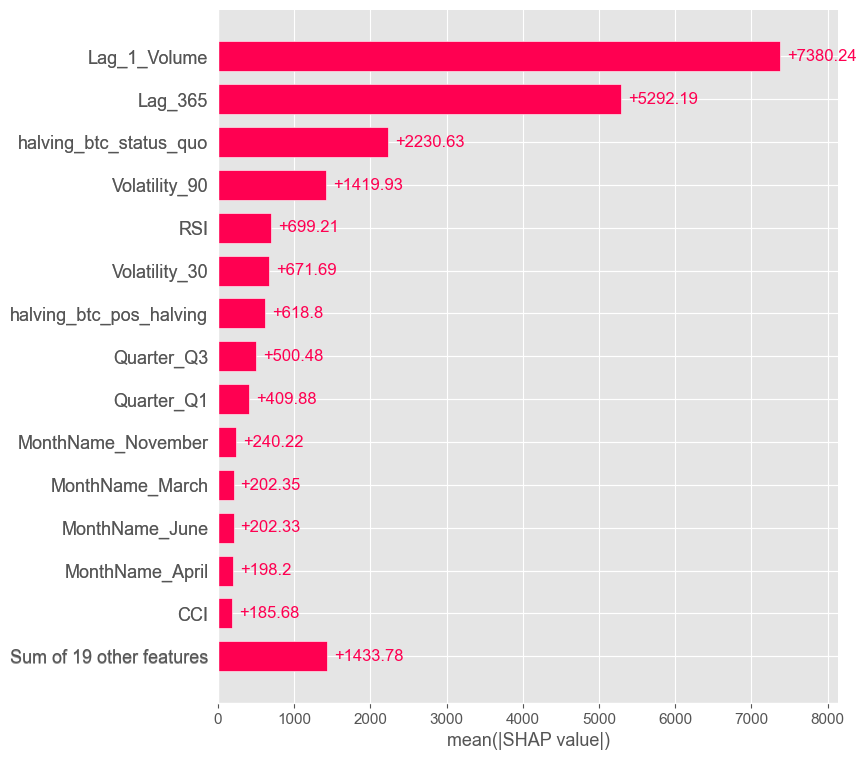

In [102]:
# Modelo com os melhores hiperparâmetros
model_temporal = xgb.XGBRegressor(
    max_depth=int(best_hyperparams['max_depth']), 
    reg_lambda=best_hyperparams['reg_lambda'], 
    reg_alpha=best_hyperparams['reg_alpha'], 
    gamma=best_hyperparams['gamma'], 
    min_child_weight=int(best_hyperparams['min_child_weight']),
    colsample_bytree=best_hyperparams['colsample_bytree'], 
    random_state=0,  
    seed=0)

# Treino do modelo utilizando dados do SMOTE 
modelo = model_temporal.fit(X_train, y_train)

# Previsões
y_pred = modelo.predict(X_test)

# Calculando MSE, MAE e RMSE
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)  # Raiz quadrada do MSE para obter o RMSE

n = len(y_test)  # Número de observações
k = modelo.get_booster().num_boosted_rounds()  # Número de árvores usadas no modelo

# Preparando os resíduos
y_pred_series = pd.Series(y_pred, index=y_test.index)
residuals = y_test['Close'] - y_pred_series

r_squared = r2_score(y_test, y_pred)
print("R-squared: ", r_squared)

# Realizando o teste de Shapiro-Wilk
shapiro_test = shapiro(residuals)
print(f"Shapiro-Wilk Test Statistic (residuals) {shapiro_test.statistic}, p-value: {shapiro_test.pvalue}")

# Certifique-se de que y_pred é uma série Pandas com o mesmo índice que y_test
y_pred_series = pd.Series(y_pred, index=y_test.index)

# Calculando os resíduos
residuals = y_test['Close'] - y_pred_series

# Primeiro, adicione uma constante aos preditores se ainda não tiver feito isso
X_test_const = add_constant(X_test)

#Teste de Variância Reescalonada
# Realizando o teste de Breusch-Pagan nos resíduos e X_test com constante
bp_test = het_breuschpagan(residuals, X_test_const)
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print('Valores do Teste de Breusch-Pagan:',dict(zip(labels, bp_test)))

# Calculando skewness e kurtosis
skewness = skew(residuals)
kurtosis_val = kurtosis(residuals)

print("Skewness of residuals: ", skewness)
print("Kurtosis of residuals: ", kurtosis_val)

# Cálculo do teste Durbin-Watson
dw = durbin_watson(residuals)
print("Durbin-Watson: ", dw)

aic = n * np.log(mse / n) + 2 * k
print(f"AIC: {aic}")

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

# Plotar valores reais vs preditos
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='red', label='Predito')
plt.plot(y_test, y_test, color='blue', label='Real')  # Linha perfeita
plt.title('Comparação Real vs. Predito')
plt.xlabel('Valores Reais')
plt.ylabel('Valores Preditos')
plt.legend()
plt.grid(True)
plt.show()

#Shap
explainer = shap.Explainer(modelo)
shap_values = explainer(X_test)
shap_importance = shap_values.abs.mean(0).values
sorted_idx = shap_importance.argsort()
shap.plots.bar(shap_values, max_display=15)

## Prophet

In [95]:
bitcoin_trat_df_proft = bitcoin_trat_df.reset_index()
bitcoin_trat_df_proft = bitcoin_trat_df_proft[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})

# Initialize and fit the Prophet model
model = Prophet(daily_seasonality=True)
model.fit(bitcoin_trat_df_proft)

# Criar um DataFrame futuro para previsões
future = model.make_future_dataframe(periods=30)  # Adicionar 365 dias para previsão

# Usar o modelo para fazer previsões
forecast = model.predict(future)

11:00:03 - cmdstanpy - INFO - Chain [1] start processing
11:00:04 - cmdstanpy - INFO - Chain [1] done processing


R-squared: 0.8987875551655364
Valores do Teste de Breusch-Pagan: {'LM Statistic': 921.7627885631708, 'LM-Test p-value': 1.8235355816439692e-202, 'F-Statistic': 1250.3384361992732, 'F-Test p-value': 1.864184377072099e-234}
Durbin-Watson: 0.022108476893840035
Shapiro-Wilk Test: ShapiroResult(statistic=0.9456916451454163, pvalue=4.111898983808036e-34)
Skewness: -0.8509147178079467
Kurtosis: 2.1690530500877614
MSE: 31453780.64020711
MAE: 3991.415823015767
RMSE: 5608.367020818726


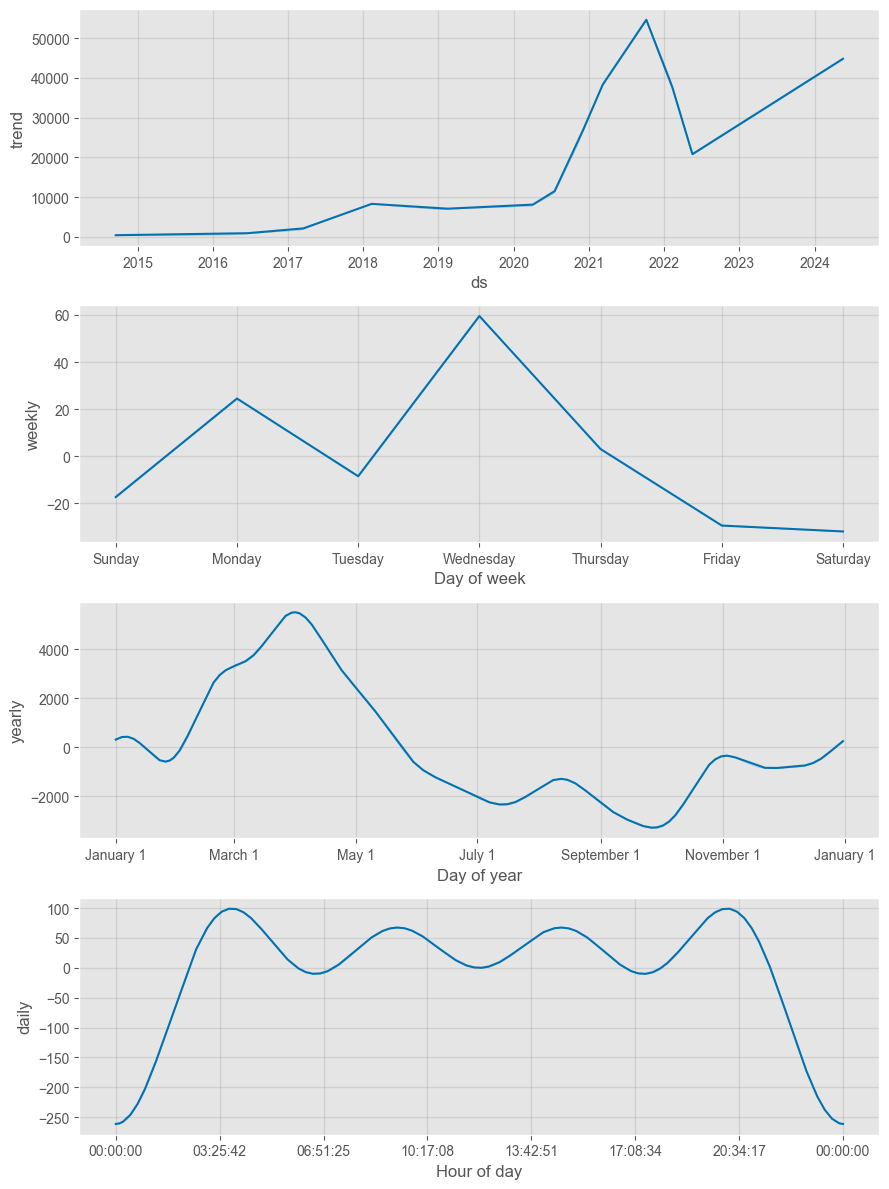

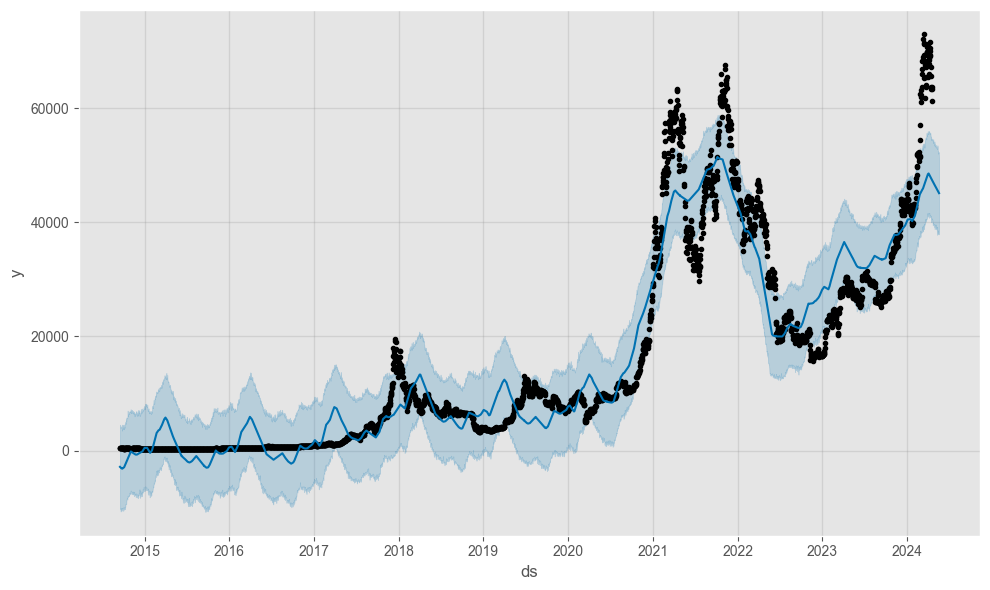

In [67]:
# Criar um DataFrame futuro para previsões e fazer previsões
future = model.make_future_dataframe(periods=30)  # Adicionar 30 dias para previsão
forecast = model.predict(future)

# Juntar os dados originais com as previsões para os mesmos períodos
forecast_filtered = forecast[['ds', 'yhat']][:len(bitcoin_trat_df_proft)]
residuals = forecast_filtered['yhat'] - bitcoin_trat_df_proft['y']

# R-squared
r_squared = np.corrcoef(bitcoin_trat_df_proft['y'], forecast_filtered['yhat'])[0, 1]**2

# Shapiro-Wilk Test
shapiro_test = stats.shapiro(residuals.dropna())

# Skewness and Kurtosis
skewness = stats.skew(residuals.dropna())
kurtosis = stats.kurtosis(residuals.dropna())

# MSE, MAE, RMSE
mse = mean_squared_error(bitcoin_trat_df_proft['y'], forecast_filtered['yhat'])
mae = mean_absolute_error(bitcoin_trat_df_proft['y'], forecast_filtered['yhat'])
rmse = np.sqrt(mse)

print(f"R-squared: {r_squared}")

# Adicionar uma constante ao DataFrame para o teste Breusch-Pagan
exog = sm.add_constant(forecast_filtered['yhat'])

bp_test = het_breuschpagan(residuals, exog)
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print('Valores do Teste de Breusch-Pagan:',dict(zip(labels, bp_test)))

# Skewness and Kurtosis
skewness = stats.skew(residuals)
kurtosis = stats.kurtosis(residuals)


# Durbin-Watson Test
dw_test = sm.stats.stattools.durbin_watson(residuals)
print(f"Durbin-Watson: {dw_test}")

# Print results

print(f"Shapiro-Wilk Test: {shapiro_test}")
print(f"Skewness: {skewness}")
print(f"Kurtosis: {kurtosis}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

# Visualizar os componentes do modelo
model.plot_components(forecast)
plt.show()
model.plot(forecast)
plt.show()

## GARCH

In [ ]:
# https://www.kaggle.com/code/hassanoukhouya/bitcoin-modeling-and-forecasting-with-the-garch#Make-forecast-with-GARCH-models
# https://github.com/liberadori/Time-Series-Analysis-Homework/blob/master/time_series_analysis.ipynb